# DSCI552: HW3
### Alain Tamazian
### ID#: 2073746513

------------------

In [1]:
# Cell for all imports necessary for HW3

import csv
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import ExtraTreesClassifier
import statistics
from warnings import filterwarnings
from warnings import simplefilter
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

# Note: this notebook takes a Very long time to run


---------------
## 1.a
AReM Data Set

The dataset contains 7 folders that represent seven types of activities. In each folder, there are multiple files each of which represents an instant of a human performing an activity. Each file containis 6 time series collected from activities of the same person, which are called avg rss12, var rss12, avg rss13, var rss13, vg rss23, and ar rss23. There are 88 instances in the dataset, each of which contains 6 time series and each time series has 480 consecutive values.

https://archive.ics.uci.edu/ml/datasets/Activity+Recognition+system+based+on+Multisensor+data+fusion+(AReM)

In [2]:
root_file = "../data/AReM"

clean_filesL = []

# cleaning dataset4 from bending2; it has a delimeter problem from we need to fix

unclean_file1 = "../data/AReM/bending2/dataset4.csv"

fileIn = open(unclean_file1)

csv_fileL = list(fileIn)

fileIn.close()

csv_fileL_fixed = csv_fileL

index = 5
for line in csv_fileL_fixed[5:]:
    csv_fileL_fixed[index] = ",".join(line.split())
    index += 1

# Creating a new cleaned dataset
path_name1 = "../data/AReM/bending2"
file_name1 = "dataset4_cleaned.csv"
complete_name1 = os.path.join(path_name1, file_name1)

clean_filesL.append(complete_name1)

fileOut = open(complete_name1, "w")
for line in csv_fileL_fixed:
    print(line.strip(), file=fileOut)
fileOut.close()

unclean_filesL = ["../data/AReM/cycling/dataset9.csv", "../data/AReM/cycling/dataset14.csv"]
for unclean_file in unclean_filesL:
    # cleaning datasets that have an extra "," at the very end
    
    fileIn = csv.reader(open(unclean_file))
    csv_fileL = list(fileIn)
    del csv_fileL[-1][-1]

    # Creating a new cleaned dataset
    path_name = unclean_file[: unclean_file.find("/", unclean_file.find("/", 13))]
    file_name = unclean_file[unclean_file.find("/", 13)+1: unclean_file.find(".", 3)] + "_cleaned.csv"
    
    complete_name = os.path.join(path_name, file_name)
    clean_filesL.append(complete_name)
    
    with open(complete_name, "w") as new_file:
        fileOut = csv.writer(new_file)
        fileOut.writerows(csv_fileL)

unclean_filesL.append(unclean_file1)


----------------
## 1.b
Keep datasets 1 and 2 in folders bending1 and bending 2, as well as datasets 1, 2, and 3 in other folders as test data and other datasets as train data.

In [3]:
# https://docs.python.org/3/library/os.html
# https://www.tutorialspoint.com/python/os_walk.htm
# https://www.geeksforgeeks.org/os-walk-python/

# We need a way to move through a file system: os.walk()

test_set_filesL = []

train_set_filesL = []

for (root,dirs,files) in os.walk(root_file, topdown=True):
    activity_dirs = dirs
    break

activity_pathsL = [os.path.join(root_file, dirs) for dirs in activity_dirs]
# print(activity_pathsL)
# print()

for path in activity_pathsL:
    if "bending" in path:
        for (root,dirs,files) in os.walk(path, topdown=True):
            for file in files:
                if ("dataset1.csv" in file) or ("dataset2.csv" in file):
                    file_path = os.path.join(path, file)
                    test_set_filesL.append(file_path)
                elif ".csv" in file:
                    file_path = os.path.join(path, file)
                    train_set_filesL.append(file_path)
    else:
        for (root,dirs,files) in os.walk(path, topdown=True):
            for file in files:
                if ("dataset1.csv" in file) or ("dataset2.csv" in file) or ("dataset3.csv" in file):
                    file_path = os.path.join(path, file)
                    test_set_filesL.append(file_path)
                elif ".csv" in file:
                    file_path = os.path.join(path, file)
                    train_set_filesL.append(file_path)                    

# removing the non-cleaned dataset; I initially left it for posterity's sake
# Wasn't sure if it would be fine to simply change/clean the existing csv
for file in unclean_filesL:
    train_set_filesL.remove(file)

    

-----------
## 1.c.i
Feature Extraction

Classification of time series usually needs extracting features from them. In this problem, we focus on time-domain features.

i. Research what types of time-domain features are usually used in time series classification and list them (examples are minimum, maximum, mean, etc).

>Common statistical (time-domain) features used for time series classification are: min, max, mean, median, Q1, Q3, and standard deviation.

-----------
## 1.c.ii
Feature Extraction

Classification of time series usually needs extracting features from them. In this problem, we focus on time-domain features.

Extract the time-domain features minimum, maximum, mean, median, standard deviation, first quartile, and third quartile for all of the 6 time series in each instance. You are free to normalize/standardize features or use them directly.

In [4]:
stats = ["min", "max", "mean", "median", "Q1", "Q3", "stdev"]
subs = ["₁", "₂", "₃", "₄", "₅", "₆"]
stat_colL = []

for sub in subs:
    for stat in stats:
#         print(stat+sub)
        stat_colL.append(stat+sub)

# print(stat_colL)

stat_colL.insert(0, "file")
stat_colL.insert(0, "folder")

pd.set_option('display.max_columns', None)


trainTS_df = pd.DataFrame(columns=stat_colL)
testTS_df = pd.DataFrame(columns=stat_colL)

setsT = [(train_set_filesL, trainTS_df), (test_set_filesL, testTS_df)]


for set_filesL, ts_df in setsT:
    
    ts_df.index.name = "Instance"

    inst = 0
    # loop through all test dataset "csv" files
    for file in set_filesL:

        file_df = pd.read_csv(file, skiprows=4)

        folder_name = file[13: file.find("/", file.find("/", 13))]
        file_name = file[file.find("/", 13)+1:]

        instance_valsL = []
        instance_valsL.append([folder_name])
        instance_valsL.append([file_name])

        # loop through the 6 time series 
        for ts_name in list(file_df.columns)[1:]:

            df = file_df[ts_name]

            # statistical attribute values for a single time series
            attr_valsL = []

            attr_valsL.append(df.min())
            attr_valsL.append(df.max())
            attr_valsL.append(df.mean())
            attr_valsL.append(df.quantile(.50))
            attr_valsL.append(df.quantile(.25))
            attr_valsL.append(df.quantile(.75))
            attr_valsL.append(df.std())

            instance_valsL.append(attr_valsL)

        # flattening the list to input into single dataframe row
        instance_valsL_flat = [item for sublist in instance_valsL for item in sublist]

        ts_df.loc[0+inst] = instance_valsL_flat
        inst += 1

    ts_df.index +=1
        

allTS_df = pd.concat([trainTS_df, testTS_df], ignore_index=True)
allTS_df.index +=1
display(allTS_df)

                            

folder          file   min₁   max₁      mean₁  median₁    Q1₁      Q3₁  \
1   bending1  dataset7.csv  36.25  48.00  43.969125   44.500  43.31  44.6700   
2   bending1  dataset6.csv  37.00  48.00  43.454958   43.250  42.50  45.0000   
3   bending1  dataset4.csv  33.00  47.75  42.179813   43.500  39.15  45.0000   
4   bending1  dataset5.csv  33.00  45.75  41.678063   41.750  41.33  42.7500   
5   bending1  dataset3.csv  35.00  47.40  43.954500   44.330  43.00  45.0000   
..       ...           ...    ...    ...        ...      ...    ...      ...   
84     lying  dataset2.csv  24.75  48.33  44.182937   48.000  48.00  48.0000   
85     lying  dataset3.csv  48.00  48.25  48.004167   48.000  48.00  48.0000   
86   cycling  dataset1.csv  24.25  45.00  37.177042   36.250  34.50  40.2500   
87   cycling  dataset2.csv  28.75  44.75  37.561188   36.875  35.25  40.2500   
88   cycling  dataset3.csv  22.00  44.67  37.058708   36.000  34.50  40.0625   

      stdev₁  min₂   max₂     mean₂  median₂   Q1₂   Q3₂    stdev₂  min₃  \
1   1.618364   0.0   1.50  0.413125     0.47  0.43  0.50  0.263111  1.50   
2   1.386098   0.0   1.58  0.378083     0.47  0.00  0.50  0.315566  5.75   
3   3.670666   0.0   3.00  0.696042     0.50  0.00  1.12  0.630860  8.50   
4   2.243490   0.0   2.83  0.535979     0.50  0.43  0.71  0.405469  3.00   
5   1.558835   0.0   1.70  0.426250     0.47  0.00  0.50  0.338690  6.50   
..       ...   ...    ...       ...      ...   ...   ...       ...   ...   
84  7.495615   0.0   3.11  0.101875     0.00  0.00  0.00  0.346756  1.00   
85  0.032038   0.0   0.43  0.007167     0.00  0.00  0.00  0.055106  0.00   
86  3.581301   0.0   8.58  2.374208     1.92  1.30  3.13  1.601799  5.50   
87  3.226507   0.0   9.91  2.080688     1.70  1.12  2.87  1.639258  6.50   
88  3.710180   0.0  14.17  2.438146     1.92  1.25  3.35  1.996887  6.33   

     max₃      mean₃  median₃    Q1₃      Q3₃    stdev₃  min₄   max₄  \
1   26.33  15.868021   16.250  14.25  18.0000  3.742420   0.0   5.17   
2   27.00  15.793333   15.000  13.00  18.2700  3.847638   0.0  10.03   
3   30.00  22.183625   23.000  20.50  24.3725  3.810469   0.0   5.15   
4   28.25  19.006562   19.125  16.50  22.0625  4.087107   0.0   6.42   
5   29.75  22.122354   23.000  19.75  24.0000  3.030943   0.0   4.44   
..    ...        ...      ...    ...      ...       ...   ...    ...   
84  16.50   6.679958    6.250   5.67   7.5000  1.936492   0.0   5.91   
85  13.00   4.900563    5.500   3.00   6.2500  2.566429   0.0   2.86   
86  26.75  16.531083   16.670  14.25  19.0000  3.430906   0.0   8.05   
87  24.67  16.567042   17.000  14.00  19.5000  3.691401   0.0   8.32   
88  24.00  16.388312   16.500  13.75  19.0000  3.537950   0.0   9.74   

       mean₄  median₄   Q1₄     Q3₄    stdev₄   min₅   max₅      mean₅  \
1   0.666354     0.47  0.00  0.9400  0.788985  11.33  30.75  22.103750   
2   0.849354     0.50  0.43  1.1200  0.995761   8.00  33.50  23.034792   
3   0.989917     0.83  0.43  1.3000  0.953730  20.00  38.67  33.493917   
4   0.841875     0.50  0.43  1.1200  0.928801  23.67  37.50  29.857083   
5   0.497313     0.43  0.00  0.8300  0.550657  29.00  38.50  35.588458   
..       ...      ...   ...     ...       ...    ...    ...        ...   
84  0.584104     0.43  0.00  0.7100  0.749945   0.00  12.75   4.376292   
85  0.397313     0.43  0.00  0.5000  0.447127   0.00  12.00   7.624896   
86  2.910604     2.62  1.64  3.9175  1.600137   7.00  25.50  19.607250   
87  3.033875     2.95  1.79  4.0300  1.625415  10.50  24.33  19.518896   
88  2.980688     2.86  1.79  4.0000  1.612059   7.50  24.25  18.125958   

    median₅      Q1₅      Q3₅    stdev₅  min₆  max₆     mean₆  median₆  \
1    21.670  20.5000  23.7500  3.318301   0.0  2.96  0.555313     0.49   
2    23.500  22.2500  24.0000  2.488862   0.0  5.26  0.679646     0.50   
3    35.000  30.4575  36.3300  3.849448   0.0  2.18  0.613521     0.50   
4    30.000  28.4575  31.2500  2.411026   0.0  1.79  0.383292     0.43   
5    36.

>Mean₁ represents the mean of the first time series <br>
>Max₂ represents the max of the second time series <br>
>And so on

-----------
## 1.c.iii
Feature Extraction

Classification of time series usually needs extracting features from them. In this problem, we focus on time-domain features.

Estimate the standard deviation of each of the time-domain features you extracted from the data. Then, use Python’s bootstrapped or any other method to build a 90% bootsrap confidence interval for the standard deviation of each feature.

In [5]:
ts_summary = allTS_df.describe()
display(ts_summary)

print()
attr_stdev = ts_summary.loc["std"]

# print(attr_stdev.keys())

print("Estimated standard deviation of each of the time-domain features")
display(attr_stdev)

min₁       max₁      mean₁    median₁       Q1₁        Q3₁  \
count  88.000000  88.000000  88.000000  88.000000  88.00000  88.000000   
mean   29.036705  45.473068  38.917357  38.856705  37.01983  41.197216   
std     9.569975   4.394362   5.335718   5.440054   6.15359   5.138925   
min     0.000000  30.000000  24.562958  24.250000  23.18750  26.500000   
25%    21.875000  44.585000  34.845755  35.447500  31.62750  38.250000   
50%    28.625000  45.750000  39.433792  39.415000  39.20000  40.250000   
75%    36.270000  47.750000  43.013250  43.250000  42.00000  45.000000   
max    48.000000  56.250000  48.004167  48.000000  48.00000  54.000000   

          stdev₁  min₂       max₂      mean₂    median₂        Q1₂        Q3₂  \
count  88.000000  88.0  88.000000  88.000000  88.000000  88.000000  88.000000   
mean    2.988893   0.0   6.290114   1.459119   1.288068   0.745398   1.976080   
std     1.772153   0.0   5.062729   1.574164   1.412244   0.946386   2.125266   
min     0.032038   0.0   0.430000   0.007167   0.000000   0.000000   0.000000   
25%     1.468289   0.0   1.767500   0.366630   0.430000   0.000000   0.500000   
50%     3.212700   0.0   4.500000   0.489365   0.500000   0.430000   0.500000   
75%     4.552490   0.0  10.930000   2.731505   2.185000   1.300000   3.766250   
max     7.684146   0.0  17.240000   4.576562   4.260000   2.870000   6.105000   

          stdev₂       min₃       max₃      mean₃    median₃        Q1₃  \
count  88.000000  88.000000  88.000000  88.000000  88.000000  88.000000   
mean    0.987459   3.101477  22.810909  14.278229  14.613352  12.110682   
std     0.884105   2.956462   4.875137   4.008380   4.036396   4.220658   
min     0.055106   0.000000  11.330000   4.382208   4.500000   2.500000   
25%     0.320845   0.000000  21.000000  12.760526  12.740000  10.250000   
50%     0.455526   2.250000  23.500000  15.299646  15.330000  13.250000   
75%     1.900389   6.000000  25.580000  16.531083  16.690000  14.250000   
max     2.625516   8.500000  35.000000  22.183625  23.000000  20.500000   

             Q3₃     stdev₃  min₄       max₄      mean₄    median₄        Q1₄  \
count  88.000000  88.000000  88.0  88.000000  88.000000  88.000000  88.000000   
mean   16.733722   3.577925   0.0   6.761250   1.502218   1.313352   0.719034   
std     4.171628   0.946710   0.0   2.183625   1.166114   1.145586   0.843620   
min     6.000000   1.745801   0.0   2.490000   0.332063   0.000000   0.000000   
25%    15.000000   2.946473   0.0   5.165000   0.614672   0.470000   0.000000   
50%    17.585000   3.457400   0.0   6.070000   0.837208   0.500000   0.430000   
75%    19.000000   3.987098   0.0   9.000000   2.988917   2.860000   1.705625   
max    24.372500   7.638935   0.0  11.420000   3.365375   3.200000   2.170000   

             Q3₄     stdev₄       min₅       max₅      mean₅    median₅  \
count  88.000000  88.000000  88.000000  88.000000  88.000000  88.000000   
mean    1.998920   1.067130   4.676364  24.320114  16.035170  16.239602   
std     1.552504   0.458242   6.124001   5.741238   5.675593   5.813782   
min     0.470000   0.409145   0.000000  12.000000   4.303979   2.250000   
25%     0.830000   0.716983   0.000000  21.000000  13.390958  13.447500   
50%     1.120000   0.903342   2.500000  23.500000  15.993198  16.125000   
75%     4.007500   1.600137   6.812500  25.500000  17.376687  17.812500   
max     4.440000   1.861730  29.000000  40.330000  35.588458  36.000000   

             Q1₅       Q3₅     stdev₅       min₆       max₆      mean₆  \
count  88.000000  88.00000  88.000000  88.000000  88.000000  88.000000   
mean   13.826761  18.52821   3.537752   0.004886   6.461932   1.620686   
std     6.096465   5.53172   1.024898   0.045838   2.518921   1.154812   
min     1.000000   5.54250   1.745970   0.000000   1.790000   0.383292   
25%    11.295000  16.64250   2.942275   0.000000   4.500000   0.730656   
50%    14.000000  18.28125   3.265060   0.000000   6.310000   0.930188   
75%    15.50000


Estimated standard deviation of each of the time-domain features


min₁       9.569975
max₁       4.394362
mean₁      5.335718
median₁    5.440054
Q1₁        6.153590
Q3₁        5.138925
stdev₁     1.772153
min₂       0.000000
max₂       5.062729
mean₂      1.574164
median₂    1.412244
Q1₂        0.946386
Q3₂        2.125266
stdev₂     0.884105
min₃       2.956462
max₃       4.875137
mean₃      4.008380
median₃    4.036396
Q1₃        4.220658
Q3₃        4.171628
stdev₃     0.946710
min₄       0.000000
max₄       2.183625
mean₄      1.166114
median₄    1.145586
Q1₄        0.843620
Q3₄        1.552504
stdev₄     0.458242
min₅       6.124001
max₅       5.741238
mean₅      5.675593
median₅    5.813782
Q1₅        6.096465
Q3₅        5.531720
stdev₅     1.024898
min₆       0.045838
max₆       2.518921
mean₆      1.154812
median₆    1.086474
Q1₆        0.758584
Q3₆        1.523599
stdev₆     0.517617
Name: std, dtype: float64

In [6]:
# https://towardsdatascience.com/calculating-confidence-interval-with-bootstrapping-872c657c058d
# https://towardsdatascience.com/bootstrap-and-statistical-inference-in-python-a06d098a8bfd?gi=f08a3573e583
# My bootstrapping code and methadology is based on the example in the links above

print("The 90% bootstrap confidence interval for the standard deviation of each feature.")

# We iterate through each time-domain feature and find their bootstrapped stdev CI
for stat_col in stat_colL[2:]:
    
    # bootstrap replicates for the instance values (of each feature)
    bs_stdevL = []
    
    # 10,000 was commonly used online as a standard for the number of bootstrap iterations
    for i in range(10000):
        # sample the data with replacement; I kept the same number of n (instances)
        sample = allTS_df[stat_col].sample(n=allTS_df.shape[0], replace=True)

        stdev = sample.std()
        bs_stdevL.append(stdev)
    
    bs_stdev_np = np.array(bs_stdevL)
    bs_stdev_ci = np.percentile(bs_stdev_np, [5, 95])
    
    bs_stdev_ci = [round(i, 4) for i in list(bs_stdev_ci)]
    
    print(stat_col, bs_stdev_ci)


The 90% bootstrap confidence interval for the standard deviation of each feature.
min₁ [8.2422, 10.7762]
max₁ [3.3197, 5.3046]
mean₁ [4.7126, 5.8705]
median₁ [4.7942, 6.0001]
Q1₁ [5.5678, 6.6418]
Q3₁ [4.3291, 5.8482]
stdev₁ [1.5659, 1.9538]
min₂ [0.0, 0.0]
max₂ [4.6268, 5.4053]
mean₂ [1.3929, 1.7066]
median₂ [1.2377, 1.5432]
Q1₂ [0.8307, 1.0365]
Q3₂ [1.8925, 2.2978]
stdev₂ [0.8018, 0.9416]
min₃ [2.7588, 3.105]
max₃ [4.1726, 5.4588]
mean₃ [3.4192, 4.4876]
median₃ [3.4279, 4.5373]
Q1₃ [3.6385, 4.6986]
Q3₃ [3.5464, 4.6867]
stdev₃ [0.7627, 1.1241]
min₄ [0.0, 0.0]
max₄ [1.9705, 2.3604]
mean₄ [1.0765, 1.2218]
median₄ [1.0529, 1.2015]
Q1₄ [0.7738, 0.8912]
Q3₄ [1.431, 1.6272]
stdev₄ [0.4211, 0.4861]
min₅ [4.4029, 7.548]
max₅ [4.7339, 6.549]
mean₅ [4.397, 6.7317]
median₅ [4.5107, 6.904]
Q1₅ [4.7985, 7.2107]
Q3₅ [4.3564, 6.513]
stdev₅ [0.8046, 1.219]
min₆ [0.0, 0.0785]
max₆ [2.2467, 2.7611]
mean₆ [1.0622, 1.2154]
median₆ [0.9943, 1.1485]
Q1₆ [0.6895, 0.8075]
Q3₆ [1.3991, 1.6006]
stdev₆ [0.4791, 

-----------
## 1.c.iv
Feature Extraction

Classification of time series usually needs extracting features from them. In this problem, we focus on time-domain features.

Use your judgement to select the three most important time-domain features (one option may be min, mean, and max).

folder          file   min₁   max₁      mean₁  median₁    Q1₁      Q3₁  \
1   bending1  dataset7.csv  36.25  48.00  43.969125   44.500  43.31  44.6700   
2   bending1  dataset6.csv  37.00  48.00  43.454958   43.250  42.50  45.0000   
3   bending1  dataset4.csv  33.00  47.75  42.179813   43.500  39.15  45.0000   
4   bending1  dataset5.csv  33.00  45.75  41.678063   41.750  41.33  42.7500   
5   bending1  dataset3.csv  35.00  47.40  43.954500   44.330  43.00  45.0000   
..       ...           ...    ...    ...        ...      ...    ...      ...   
84     lying  dataset2.csv  24.75  48.33  44.182937   48.000  48.00  48.0000   
85     lying  dataset3.csv  48.00  48.25  48.004167   48.000  48.00  48.0000   
86   cycling  dataset1.csv  24.25  45.00  37.177042   36.250  34.50  40.2500   
87   cycling  dataset2.csv  28.75  44.75  37.561188   36.875  35.25  40.2500   
88   cycling  dataset3.csv  22.00  44.67  37.058708   36.000  34.50  40.0625   

      stdev₁  min₂   max₂     mean₂  median₂   Q1₂   Q3₂    stdev₂  min₃  \
1   1.618364   0.0   1.50  0.413125     0.47  0.43  0.50  0.263111  1.50   
2   1.386098   0.0   1.58  0.378083     0.47  0.00  0.50  0.315566  5.75   
3   3.670666   0.0   3.00  0.696042     0.50  0.00  1.12  0.630860  8.50   
4   2.243490   0.0   2.83  0.535979     0.50  0.43  0.71  0.405469  3.00   
5   1.558835   0.0   1.70  0.426250     0.47  0.00  0.50  0.338690  6.50   
..       ...   ...    ...       ...      ...   ...   ...       ...   ...   
84  7.495615   0.0   3.11  0.101875     0.00  0.00  0.00  0.346756  1.00   
85  0.032038   0.0   0.43  0.007167     0.00  0.00  0.00  0.055106  0.00   
86  3.581301   0.0   8.58  2.374208     1.92  1.30  3.13  1.601799  5.50   
87  3.226507   0.0   9.91  2.080688     1.70  1.12  2.87  1.639258  6.50   
88  3.710180   0.0  14.17  2.438146     1.92  1.25  3.35  1.996887  6.33   

     max₃      mean₃  median₃    Q1₃      Q3₃    stdev₃  min₄   max₄  \
1   26.33  15.868021   16.250  14.25  18.0000  3.742420   0.0   5.17   
2   27.00  15.793333   15.000  13.00  18.2700  3.847638   0.0  10.03   
3   30.00  22.183625   23.000  20.50  24.3725  3.810469   0.0   5.15   
4   28.25  19.006562   19.125  16.50  22.0625  4.087107   0.0   6.42   
5   29.75  22.122354   23.000  19.75  24.0000  3.030943   0.0   4.44   
..    ...        ...      ...    ...      ...       ...   ...    ...   
84  16.50   6.679958    6.250   5.67   7.5000  1.936492   0.0   5.91   
85  13.00   4.900563    5.500   3.00   6.2500  2.566429   0.0   2.86   
86  26.75  16.531083   16.670  14.25  19.0000  3.430906   0.0   8.05   
87  24.67  16.567042   17.000  14.00  19.5000  3.691401   0.0   8.32   
88  24.00  16.388312   16.500  13.75  19.0000  3.537950   0.0   9.74   

       mean₄  median₄   Q1₄     Q3₄    stdev₄   min₅   max₅      mean₅  \
1   0.666354     0.47  0.00  0.9400  0.788985  11.33  30.75  22.103750   
2   0.849354     0.50  0.43  1.1200  0.995761   8.00  33.50  23.034792   
3   0.989917     0.83  0.43  1.3000  0.953730  20.00  38.67  33.493917   
4   0.841875     0.50  0.43  1.1200  0.928801  23.67  37.50  29.857083   
5   0.497313     0.43  0.00  0.8300  0.550657  29.00  38.50  35.588458   
..       ...      ...   ...     ...       ...    ...    ...        ...   
84  0.584104     0.43  0.00  0.7100  0.749945   0.00  12.75   4.376292   
85  0.397313     0.43  0.00  0.5000  0.447127   0.00  12.00   7.624896   
86  2.910604     2.62  1.64  3.9175  1.600137   7.00  25.50  19.607250   
87  3.033875     2.95  1.79  4.0300  1.625415  10.50  24.33  19.518896   
88  2.980688     2.86  1.79  4.0000  1.612059   7.50  24.25  18.125958   

    median₅      Q1₅      Q3₅    stdev₅  min₆  max₆     mean₆  median₆  \
1    21.670  20.5000  23.7500  3.318301   0.0  2.96  0.555313     0.49   
2    23.500  22.2500  24.0000  2.488862   0.0  5.26  0.679646     0.50   
3    35.000  30.4575  36.3300  3.849448   0.0  2.18  0.613521     0.50   
4    30.000  28.4575  31.2500  2.411026   0.0  1.79  0.383292     0.43   
5    36.

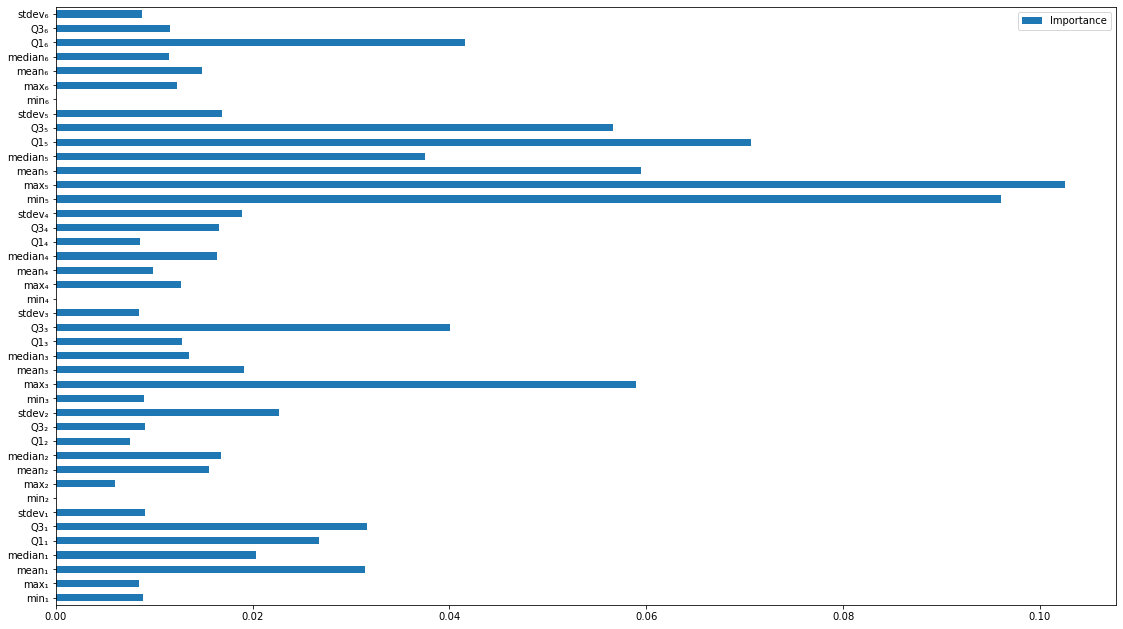

Feature  Importance
min₁        min₁    0.008898
max₁        max₁    0.008447
mean₁      mean₁    0.031444
median₁  median₁    0.020309
Q1₁          Q1₁    0.026741
Q3₁          Q3₁    0.031609
stdev₁    stdev₁    0.009072
min₂        min₂    0.000000
max₂        max₂    0.006061
mean₂      mean₂    0.015610
median₂  median₂    0.016748
Q1₂          Q1₂    0.007534
Q3₂          Q3₂    0.009028
stdev₂    stdev₂    0.022706
min₃        min₃    0.008989
max₃        max₃    0.058973
mean₃      mean₃    0.019109
median₃  median₃    0.013555
Q1₃          Q1₃    0.012854
Q3₃          Q3₃    0.040063
stdev₃    stdev₃    0.008443
min₄        min₄    0.000000
max₄        max₄    0.012780
mean₄      mean₄    0.009929
median₄  median₄    0.016362
Q1₄          Q1₄    0.008575
Q3₄          Q3₄    0.016587
stdev₄    stdev₄    0.018946
min₅        min₅    0.096079
max₅        max₅    0.102578
mean₅      mean₅    0.059468
median₅  median₅    0.037528
Q1₅          Q1₅    0.070674
Q3₅          Q3₅    0.056648
stdev₅    stdev₅    0.016884
min₆        min₆    0.000000
max₆        max₆    0.012330
mean₆      mean₆    0.014883
median₆  median₆    0.011517
Q1₆          Q1₆    0.041618
Q3₆          Q3₆    0.011626
stdev₆    stdev₆    0.008795

Average importance of Min feature: 0.019
Average importance of Max feature: 0.0335
Average importance of Mean feature: 0.0251
Average importance of Median feature: 0.0193
Average importance of Q1 feature: 0.028
Average importance of Q3 feature: 0.0276
Average importance of Stdev feature: 0.0141


In [7]:
# https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e?gi=21c066e4b7b8

# I am interpretting the "most important" here with regard to the features' importance for binary classifcation (as bending or not) 
# The following classifications will be regarding this, so I chose to determine importance for the "bending" class

# creating a labeled dataset
allTS_lbld_df = allTS_df.copy()

num_rows = allTS_df.shape[0]
bending_label = []
for i in range(num_rows):
    if "bending" in allTS_df.iloc[i]["folder"]:
        bending_label.append(1)
    else:
        bending_label.append(0)

# adding the "bending" label column to the dataframe 
allTS_lbld_df["bending_lbl"] = bending_label
print()
display(allTS_lbld_df)


# measuring feature importance; I applied the method from the link above

# features
x = allTS_lbld_df.iloc[:,2:-1]  
# response variable (label)
y = allTS_lbld_df.iloc[:,-1]    

# We use the ExtraTrees classifier because it has the built-in feature_importance attribute
model = ExtraTreesClassifier()
model.fit(x,y)

#plot graph of feature importances for better visualization
importance_df = pd.DataFrame(model.feature_importances_, index=x.columns)
importance_df.rename(columns = {0:"Importance"}, inplace = True)

fig, ax = plt.subplots()
fig.set_size_inches(19, 11)

importance_df.plot(kind="barh", ax=ax)
plt.show()

importance_df.insert(0, "Feature", x.columns)
importance_df.reset_index()
display(importance_df)

min_impL = []
max_impL = []
mean_impL = []
median_impL = []
q1_impL = []
q3_impL = []
stdev_impL = []

i = 0
for attr in x.columns:
    if "min" in attr:
        min_impL.append(importance_df.iloc[i]["Importance"])
    elif "max" in attr:
        max_impL.append(importance_df.iloc[i]["Importance"])
    elif "mean" in attr:
        mean_impL.append(importance_df.iloc[i]["Importance"])
    elif "median" in attr:
        median_impL.append(importance_df.iloc[i]["Importance"])
    elif "Q1" in attr:
        q1_impL.append(importance_df.iloc[i]["Importance"])
    elif "Q3" in attr:
        q3_impL.append(importance_df.iloc[i]["Importance"])
    elif "stdev" in attr:
        stdev_impL.append(importance_df.iloc[i]["Importance"])
    i += 1

    
print("Average importance of Min feature:", round(statistics.mean(min_impL), 4))
print("Average importance of Max feature:", round(statistics.mean(max_impL), 4))
print("Average importance of Mean feature:", round(statistics.mean(mean_impL), 4))
print("Average importance of Median feature:", round(statistics.mean(median_impL), 4))
print("Average importance of Q1 feature:", round(statistics.mean(q1_impL), 4))
print("Average importance of Q3 feature:", round(statistics.mean(q3_impL), 4))
print("Average importance of Stdev feature:", round(statistics.mean(stdev_impL), 4))



>Based on our previous sampling, these answers may be a little inconsistent. <br>
>However, it is clear that min and stdev aren't that important, as they consistently have the lowest importance score <br>
> Max on the other hand, is always the best <br>
>So, we can (more or less) confidently reject min and stdev, and select max <br>
>Choosing two of the remaining 3 features is harder; their scores are always pretty close, and very variable depending on the sample <br>

>Based on the values available when I wrote this, the three most important time-domain features appear to be: max, mean, Q3.

folder          file   min₁   max₁      mean₁  median₁    Q1₁      Q3₁  \
1   bending1  dataset7.csv  36.25  48.00  43.969125   44.500  43.31  44.6700   
2   bending1  dataset6.csv  37.00  48.00  43.454958   43.250  42.50  45.0000   
3   bending1  dataset4.csv  33.00  47.75  42.179813   43.500  39.15  45.0000   
4   bending1  dataset5.csv  33.00  45.75  41.678063   41.750  41.33  42.7500   
5   bending1  dataset3.csv  35.00  47.40  43.954500   44.330  43.00  45.0000   
..       ...           ...    ...    ...        ...      ...    ...      ...   
84     lying  dataset2.csv  24.75  48.33  44.182937   48.000  48.00  48.0000   
85     lying  dataset3.csv  48.00  48.25  48.004167   48.000  48.00  48.0000   
86   cycling  dataset1.csv  24.25  45.00  37.177042   36.250  34.50  40.2500   
87   cycling  dataset2.csv  28.75  44.75  37.561188   36.875  35.25  40.2500   
88   cycling  dataset3.csv  22.00  44.67  37.058708   36.000  34.50  40.0625   

      stdev₁  min₂   max₂     mean₂  median₂   Q1₂   Q3₂    stdev₂  min₃  \
1   1.618364   0.0   1.50  0.413125     0.47  0.43  0.50  0.263111  1.50   
2   1.386098   0.0   1.58  0.378083     0.47  0.00  0.50  0.315566  5.75   
3   3.670666   0.0   3.00  0.696042     0.50  0.00  1.12  0.630860  8.50   
4   2.243490   0.0   2.83  0.535979     0.50  0.43  0.71  0.405469  3.00   
5   1.558835   0.0   1.70  0.426250     0.47  0.00  0.50  0.338690  6.50   
..       ...   ...    ...       ...      ...   ...   ...       ...   ...   
84  7.495615   0.0   3.11  0.101875     0.00  0.00  0.00  0.346756  1.00   
85  0.032038   0.0   0.43  0.007167     0.00  0.00  0.00  0.055106  0.00   
86  3.581301   0.0   8.58  2.374208     1.92  1.30  3.13  1.601799  5.50   
87  3.226507   0.0   9.91  2.080688     1.70  1.12  2.87  1.639258  6.50   
88  3.710180   0.0  14.17  2.438146     1.92  1.25  3.35  1.996887  6.33   

     max₃      mean₃  median₃    Q1₃      Q3₃    stdev₃  min₄   max₄  \
1   26.33  15.868021   16.250  14.25  18.0000  3.742420   0.0   5.17   
2   27.00  15.793333   15.000  13.00  18.2700  3.847638   0.0  10.03   
3   30.00  22.183625   23.000  20.50  24.3725  3.810469   0.0   5.15   
4   28.25  19.006562   19.125  16.50  22.0625  4.087107   0.0   6.42   
5   29.75  22.122354   23.000  19.75  24.0000  3.030943   0.0   4.44   
..    ...        ...      ...    ...      ...       ...   ...    ...   
84  16.50   6.679958    6.250   5.67   7.5000  1.936492   0.0   5.91   
85  13.00   4.900563    5.500   3.00   6.2500  2.566429   0.0   2.86   
86  26.75  16.531083   16.670  14.25  19.0000  3.430906   0.0   8.05   
87  24.67  16.567042   17.000  14.00  19.5000  3.691401   0.0   8.32   
88  24.00  16.388312   16.500  13.75  19.0000  3.537950   0.0   9.74   

       mean₄  median₄   Q1₄     Q3₄    stdev₄   min₅   max₅      mean₅  \
1   0.666354     0.47  0.00  0.9400  0.788985  11.33  30.75  22.103750   
2   0.849354     0.50  0.43  1.1200  0.995761   8.00  33.50  23.034792   
3   0.989917     0.83  0.43  1.3000  0.953730  20.00  38.67  33.493917   
4   0.841875     0.50  0.43  1.1200  0.928801  23.67  37.50  29.857083   
5   0.497313     0.43  0.00  0.8300  0.550657  29.00  38.50  35.588458   
..       ...      ...   ...     ...       ...    ...    ...        ...   
84  0.584104     0.43  0.00  0.7100  0.749945   0.00  12.75   4.376292   
85  0.397313     0.43  0.00  0.5000  0.447127   0.00  12.00   7.624896   
86  2.910604     2.62  1.64  3.9175  1.600137   7.00  25.50  19.607250   
87  3.033875     2.95  1.79  4.0300  1.625415  10.50  24.33  19.518896   
88  2.980688     2.86  1.79  4.0000  1.612059   7.50  24.25  18.125958   

    median₅      Q1₅      Q3₅    stdev₅  min₆  max₆     mean₆  median₆  \
1    21.670  20.5000  23.7500  3.318301   0.0  2.96  0.555313     0.49   
2    23.500  22.2500  24.0000  2.488862   0.0  5.26  0.679646     0.50   
3    35.000  30.4575  36.3300  3.849448   0.0  2.18  0.613521     0.50   
4    30.000  28.4575  31.2500  2.411026   0.0  1.79  0.383292     0.43   
5    36.

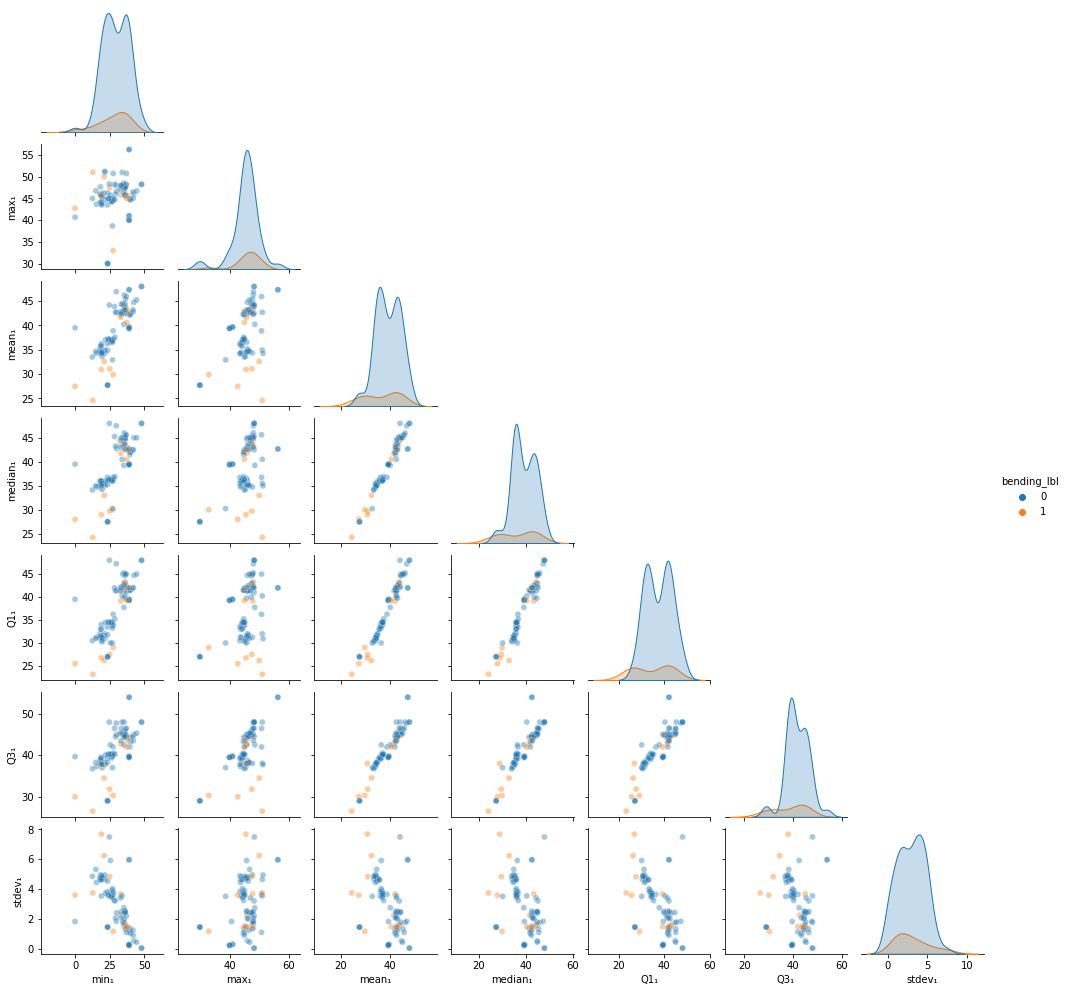

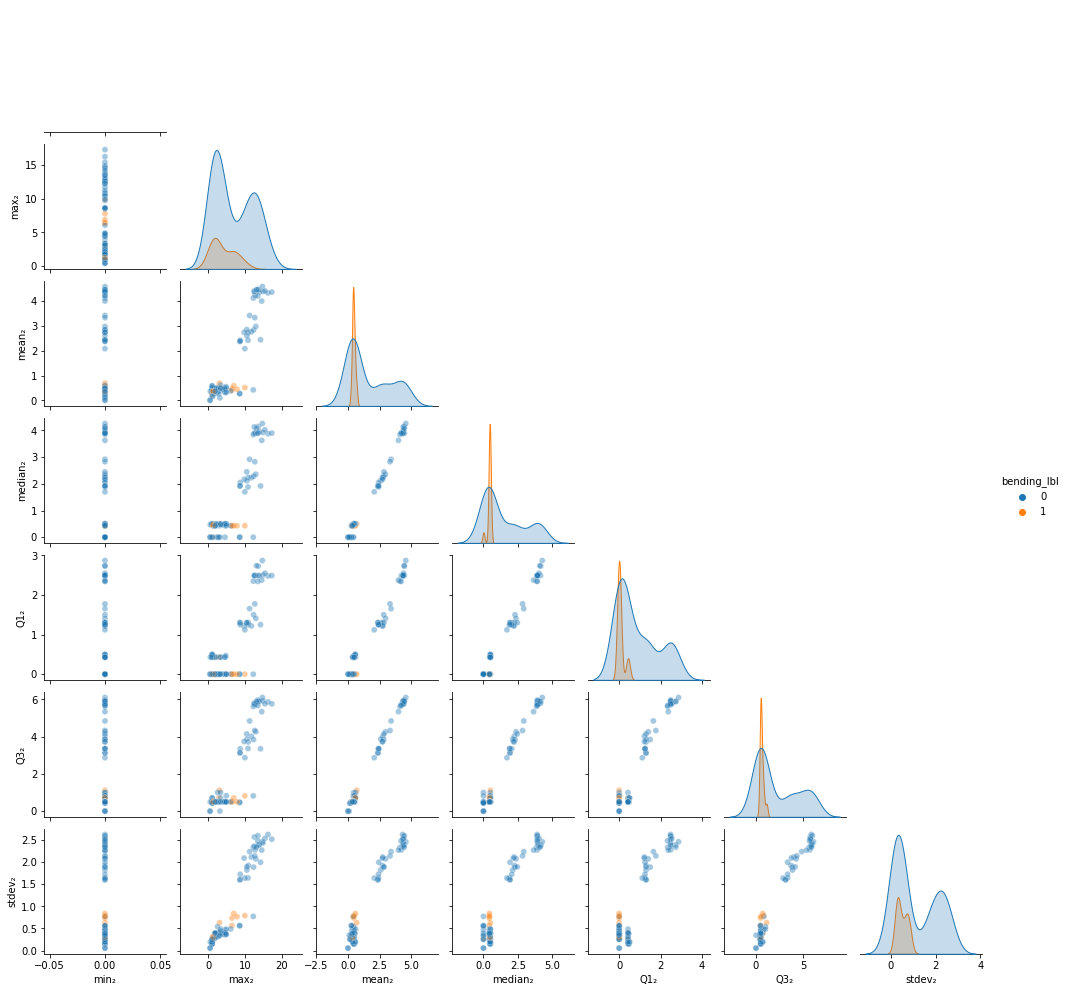

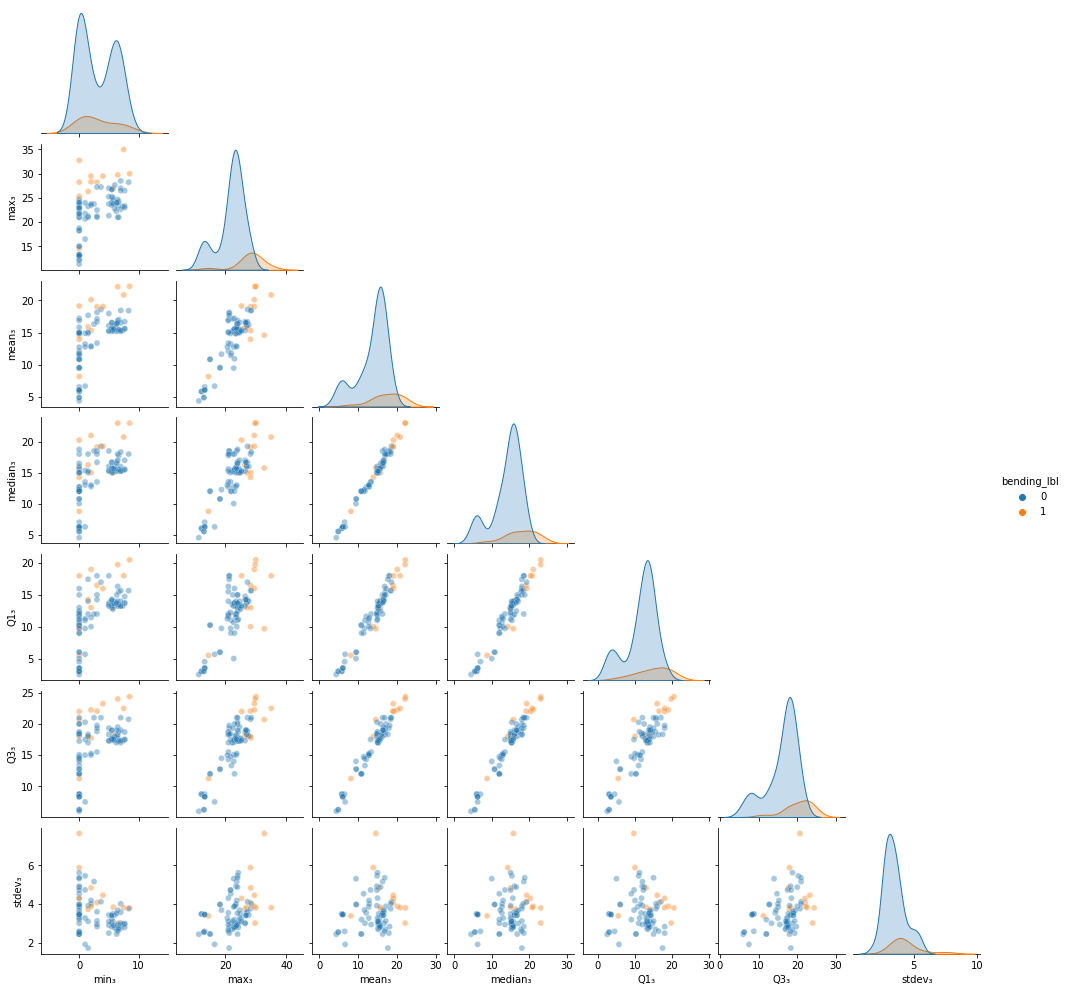

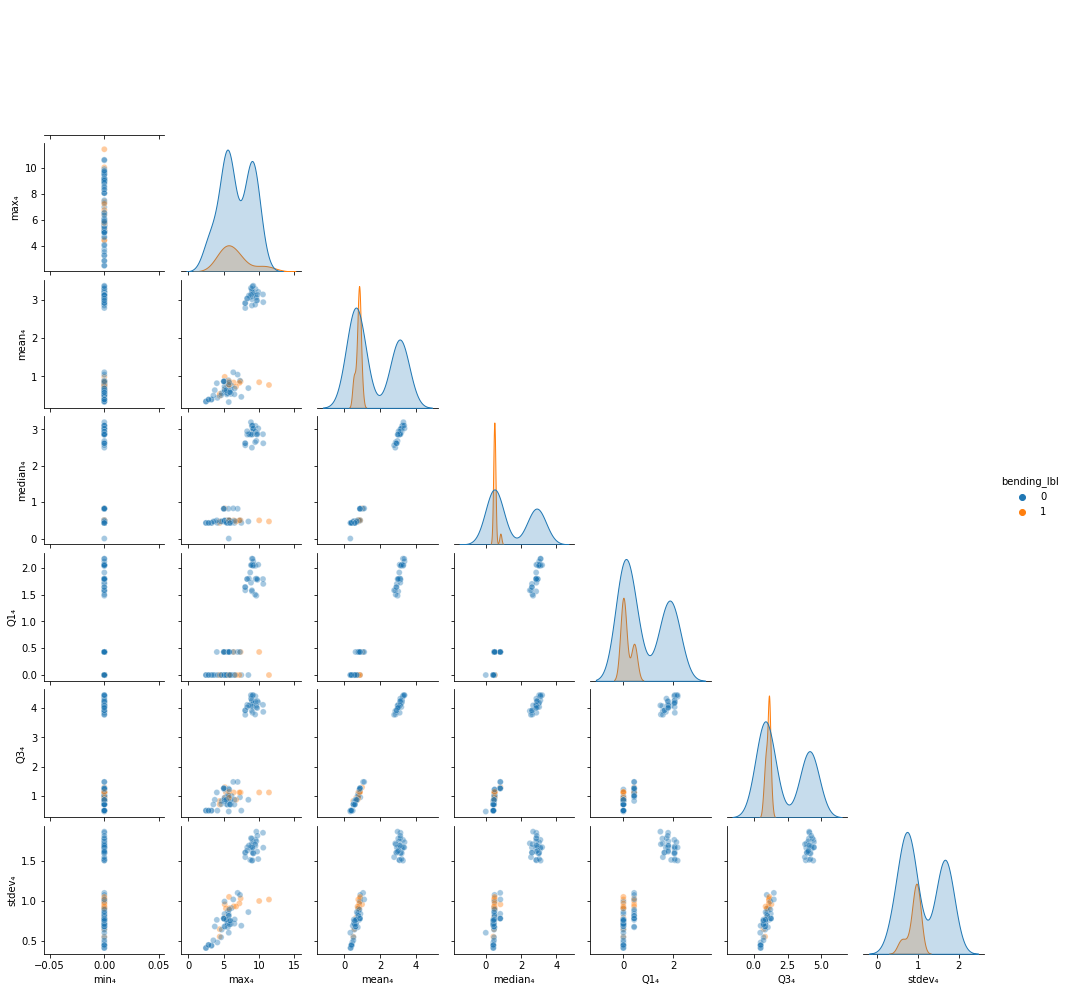

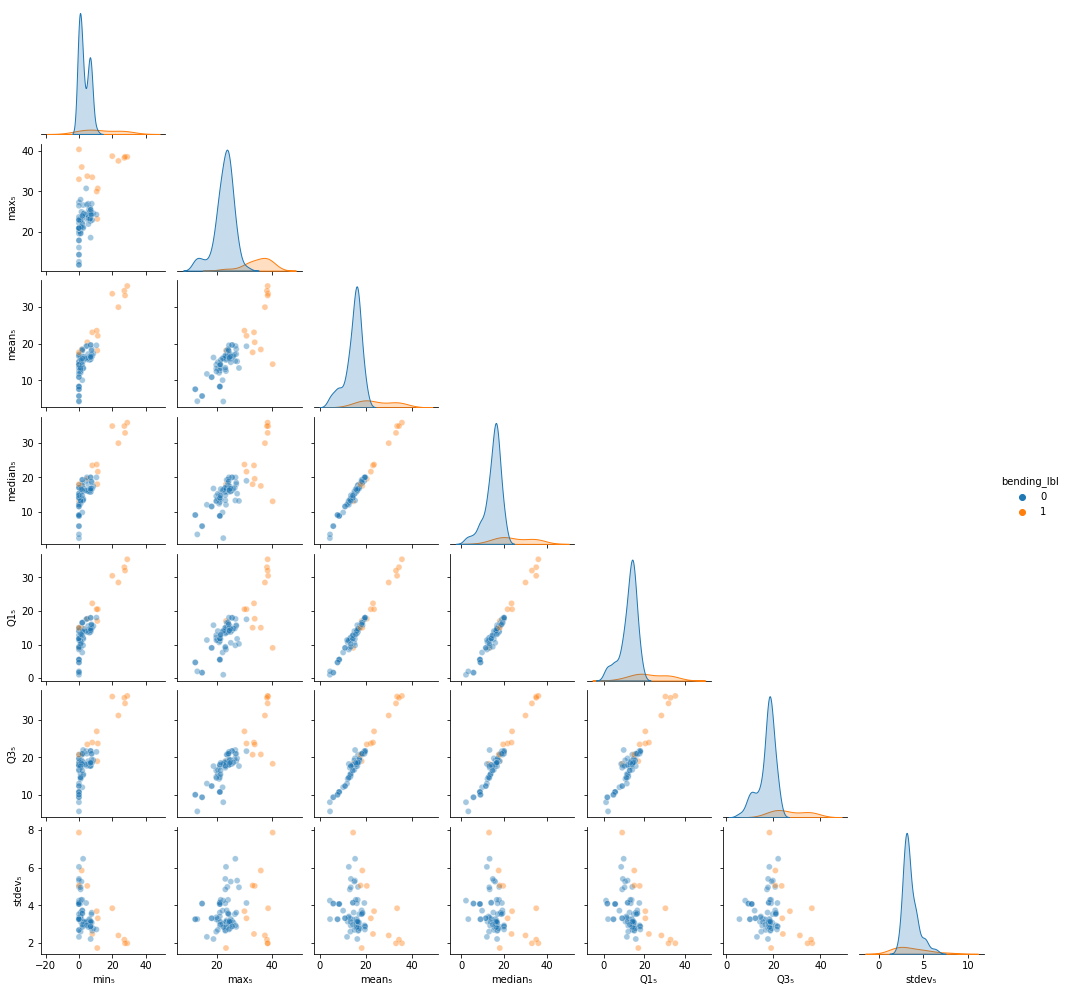

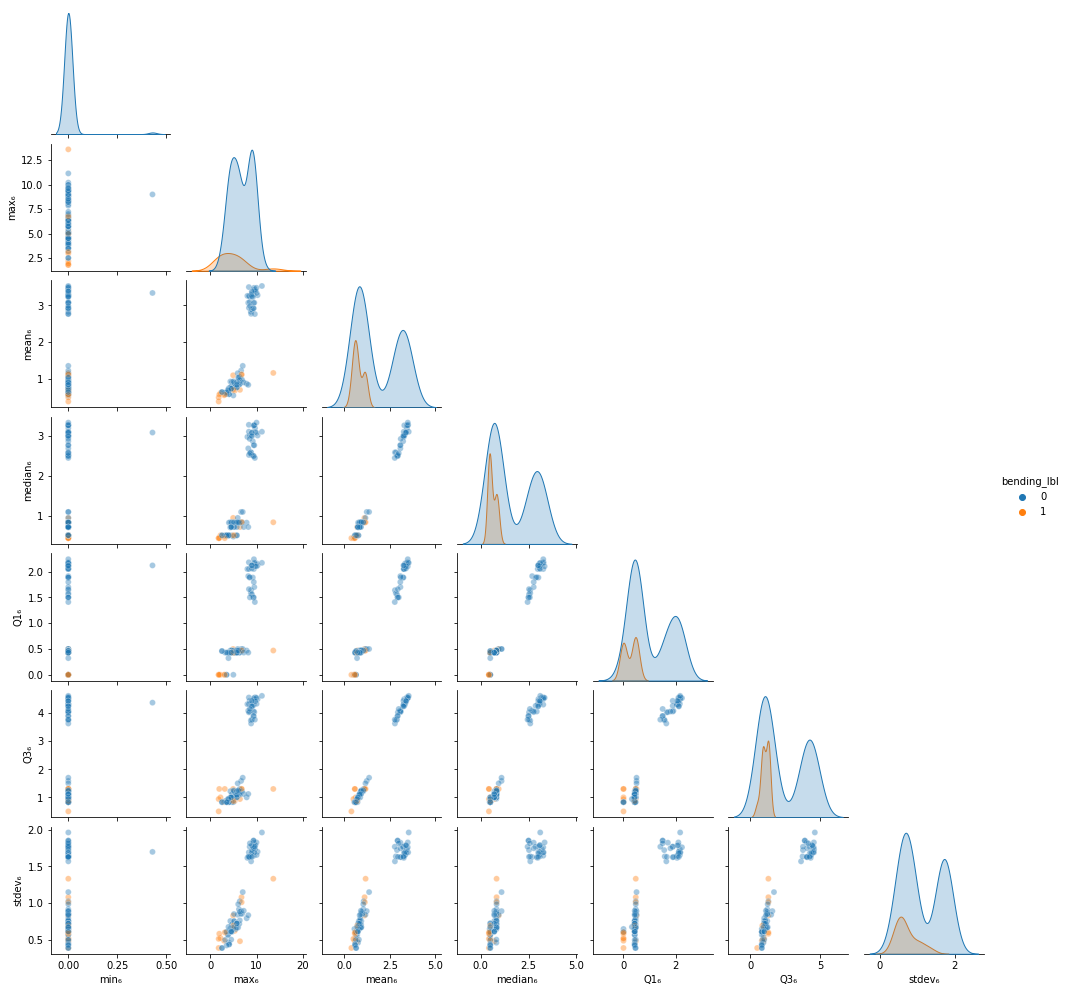

In [8]:
# Using some visualization to further decide which features are most important
# Visualization may help confirm the choice, or reject it in favor of something else

simplefilter(action="ignore", category=UserWarning)

display(allTS_lbld_df)

pairplot = sns.pairplot(allTS_lbld_df.loc[:, ["min₁", "max₁", "mean₁", "median₁", "Q1₁", "Q3₁", "stdev₁", "bending_lbl"]], hue = "bending_lbl", height=2, aspect=1, corner=True, plot_kws=dict(alpha=0.4))
pairplot = sns.pairplot(allTS_lbld_df.loc[:, ["min₂", "max₂", "mean₂", "median₂", "Q1₂", "Q3₂", "stdev₂", "bending_lbl"]], hue = "bending_lbl", height=2, aspect=1, corner=True, plot_kws=dict(alpha=0.4))
pairplot = sns.pairplot(allTS_lbld_df.loc[:, ["min₃", "max₃", "mean₃", "median₃", "Q1₃", "Q3₃", "stdev₃", "bending_lbl"]], hue = "bending_lbl", height=2, aspect=1, corner=True, plot_kws=dict(alpha=0.4))
pairplot = sns.pairplot(allTS_lbld_df.loc[:, ["min₄", "max₄", "mean₄", "median₄", "Q1₄", "Q3₄", "stdev₄", "bending_lbl"]], hue = "bending_lbl", height=2, aspect=1, corner=True, plot_kws=dict(alpha=0.4))
pairplot = sns.pairplot(allTS_lbld_df.loc[:, ["min₅", "max₅", "mean₅", "median₅", "Q1₅", "Q3₅", "stdev₅", "bending_lbl"]], hue = "bending_lbl", height=2, aspect=1, corner=True, plot_kws=dict(alpha=0.4))
pairplot = sns.pairplot(allTS_lbld_df.loc[:, ["min₆", "max₆", "mean₆", "median₆", "Q1₆", "Q3₆", "stdev₆", "bending_lbl"]], hue = "bending_lbl", height=2, aspect=1, corner=True, plot_kws=dict(alpha=0.4))


# Orange dots are instances classified as "bending"
plt.show()


>For classification, and important feature whose label distributions have a good division. Smaller overlap in their histrograms, suggest strong seperation of classes and thus better classification.

>The distribution graphs (and scatterplots), mainly confirmed our previous finding. Min and stdev would make poor features since each of their class distributions are strongly overlapping for nearly all timeseries. Max looks clearly the best here, with most instances of seperation, in terms of position or density.

>Depending on the timeseries, the other features had varying results.

>So, we will stay with our previous choice of: max, mean, Q3


-----------
## 1.d.i
Binary Classification Using Logistic Regression

Assume that you want to use the training set to classify bending from other activities, i.e. you have a binary classification problem. Depict scatter plots of the features you specified in 1(c)iv extracted from time series 1, 2, and 6 of each instance, and use color to distinguish bending vs. other activities. (See p. 129 of the textbook).

folder                   file   min₁   max₁      mean₁  median₁  \
Instance                                                                      
1         bending1           dataset7.csv  36.25  48.00  43.969125    44.50   
2         bending1           dataset6.csv  37.00  48.00  43.454958    43.25   
3         bending1           dataset4.csv  33.00  47.75  42.179813    43.50   
4         bending1           dataset5.csv  33.00  45.75  41.678063    41.75   
5         bending1           dataset3.csv  35.00  47.40  43.954500    44.33   
...            ...                    ...    ...    ...        ...      ...   
65         cycling          dataset13.csv  19.00  43.75  35.879875    36.00   
66         cycling          dataset12.csv  18.50  44.25  35.752354    36.00   
67         cycling  dataset14_cleaned.csv  23.33  43.50  36.244083    36.75   
68         cycling          dataset15.csv  24.25  45.00  37.177042    36.25   
69         cycling           dataset8.csv  26.25  44.25  36.957458    36.29   

              Q1₁    Q3₁    stdev₁  min₂   max₂     mean₂  median₂    Q1₂  \
Instance                                                                    
1         43.3100  44.67  1.618364   0.0   1.50  0.413125     0.47  0.430   
2         42.5000  45.00  1.386098   0.0   1.58  0.378083     0.47  0.000   
3         39.1500  45.00  3.670666   0.0   3.00  0.696042     0.50  0.000   
4         41.3300  42.75  2.243490   0.0   2.83  0.535979     0.50  0.430   
5         43.0000  45.00  1.558835   0.0   1.70  0.426250     0.47  0.000   
...           ...    ...       ...   ...    ...       ...      ...    ...   
65        33.0000  39.50  4.614878   0.0  11.20  3.414312     2.92  1.655   
66        33.0000  39.33  4.614802   0.0  12.60  3.328104     2.83  1.775   
67        33.4575  39.25  3.822016   0.0   9.71  2.736021     2.17  1.220   
68        34.5000  40.25  3.581301   0.0   8.58  2.374208     1.92  1.300   
69        34.5000  40.25  3.434863   0.0   8.64  2.420083     2.05  1.250   

            Q3₂    stdev₂  min₃   max₃      mean₃  median₃    Q1₃      Q3₃  \
Instance                                                                     
1         0.500  0.263111  1.50  26.33  15.868021   16.250  14.25  18.0000   
2         0.500  0.315566  5.75  27.00  15.793333   15.000  13.00  18.2700   
3         1.120  0.630860  8.50  30.00  22.183625   23.000  20.50  24.3725   
4         0.710  0.405469  3.00  28.25  19.006562   19.125  16.50  22.0625   
5         0.500  0.338690  6.50  29.75  22.122354   23.000  19.75  24.0000   
...         ...       ...   ...    ...        ...      ...    ...      ...   
65        4.845  2.237955  7.67  26.50  16.690375   17.000  14.75  18.6900   
66        4.330  2.140576  5.00  27.00  16.055021   16.000  13.73  18.3300   
67        3.740  2.092002  7.00  28.50  18.435708   18.330  15.67  21.0000   
68        3.130  1.601799  5.50  26.75  16.531083   16.670  14.25  19.0000   
69        3.350  1.724901  7.00  26.50  15.313417   15.250  13.25  17.3300   

            stdev₃  min₄   max₄     mean₄  median₄     Q1₄     Q3₄    stdev₄  \
Instance                                                                       
1         3.742420   0.0   5.17  0.666354    0.470  0.0000  0.9400  0.788985   
2         3.847638   0.0  10.03  0.849354    0.500  0.4300  1.1200  0.995761   
3         3.810469   0.0   5.15  0.989917    0.830  0.4300  1.3000  0.953730   
4         4.087107   0.0   6.42  0.841875    0.500  0.4300  1.1200  0.928801   
5         3.030943   0.0   4.44  0.497313    0.430  0.0000  0.8300  0.550657   
...            ...   ...    ...       ...      ...     ...     ...       ...   
65        3.009363   0.0   8.87  3.128354    2.870  1.7225  4.3225  1.779470   
66        3.446146   0.0   9.46  2.871125    2.650  1.5000  3.7800  1.704820   
67        4.021629   0.0   9.78  3.129792    2.895  1.7750  4.2400  1.810499   
68        3.430906   0.0   8.05  2.910604    2.620  1.6400  3.9175  1.600137   
69     

max₁      mean₁    Q3₁   max₂     mean₂    Q3₂   max₆     mean₆  \
Instance                                                                     
1         48.00  43.969125  44.67   1.50  0.413125  0.500   2.96  0.555313   
2         48.00  43.454958  45.00   1.58  0.378083  0.500   5.26  0.679646   
3         47.75  42.179813  45.00   3.00  0.696042  1.120   2.18  0.613521   
4         45.75  41.678063  42.75   2.83  0.535979  0.710   1.79  0.383292   
5         47.40  43.954500  45.00   1.70  0.426250  0.500   1.79  0.493292   
...         ...        ...    ...    ...       ...    ...    ...       ...   
65        43.75  35.879875  39.50  11.20  3.414312  4.845   8.50  3.093021   
66        44.25  35.752354  39.33  12.60  3.328104  4.330   9.39  3.069667   
67        43.50  36.244083  39.25   9.71  2.736021  3.740  11.15  3.530500   
68        45.00  37.177042  40.25   8.58  2.374208  3.130   9.34  2.921729   
69        44.25  36.957458  40.25   8.64  2.420083  3.350   8.34  2.934625   

             Q3₆  bending_lbl  
Instance                       
1         0.8300            1  
2         0.8700            1  
3         1.0000            1  
4         0.5000            1  
5         0.9400            1  
...          ...          ...  
65        4.0600            0  
66        4.0600            0  
67        4.6175            0  
68        3.9000            0  
69        4.0300            0  

[69 rows x 10 columns]

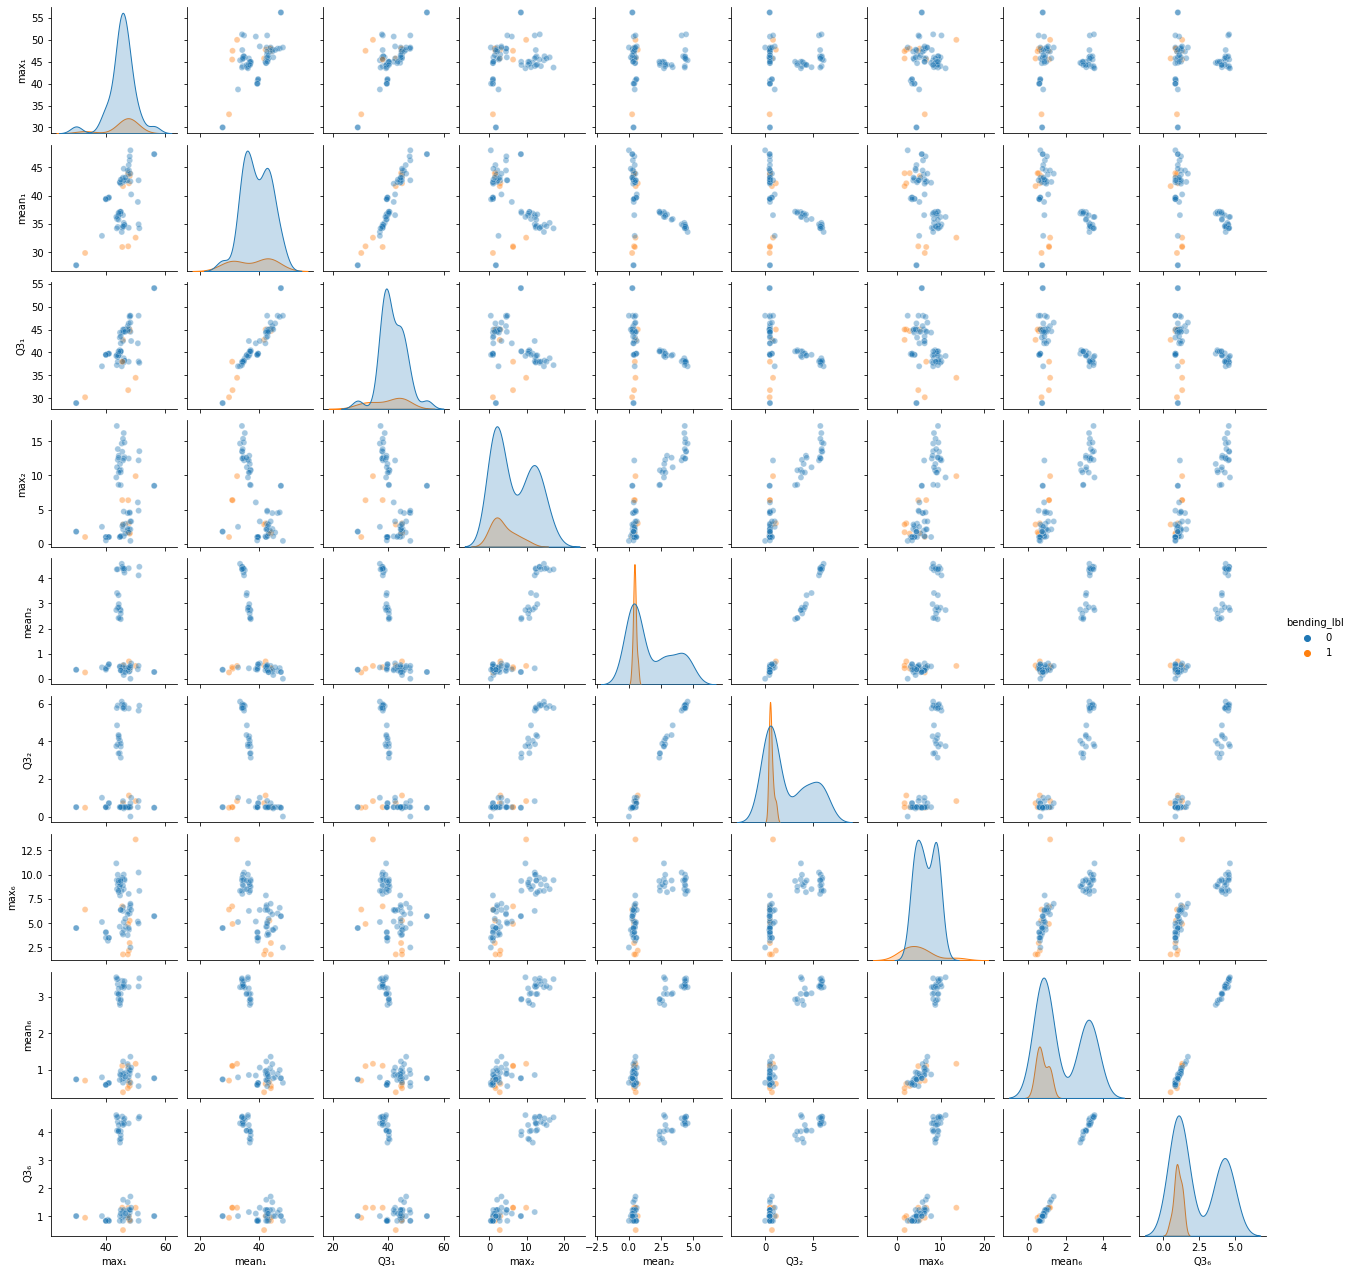

In [9]:
# display(trainTS_df)

# creating a labeled training set
trainTS_lbld_df = trainTS_df.copy()

num_rows = trainTS_df.shape[0]
# print(allTS_df.iloc[85]["folder"])
bending_label = []
for i in range(num_rows):
    if "bending" in trainTS_df.iloc[i]["folder"]:
        bending_label.append(1)
    else:
        bending_label.append(0)

# adding the "bending" label column to the dataframe 
trainTS_lbld_df["bending_lbl"] = bending_label
print()
display(trainTS_lbld_df)


pruned_trainTS_lbld_df = trainTS_lbld_df.copy()

# pruning the training set to exclude the non-selected features and time series 3, 4, and 5
for col in pruned_trainTS_lbld_df.columns:
#     if ("folder" in col) or ("file" in col) or ("min" in col) or ("stdev" in col) or ("mean" in col) or ("median" in col) or ("₃" in col) or ("₄" in col) or ("₅" in col):
    if ("folder" in col) or ("file" in col) or ("min" in col) or ("stdev" in col) or ("Q1" in col) or ("median" in col) or ("₃" in col) or ("₄" in col) or ("₅" in col):
        pruned_trainTS_lbld_df.drop(columns=col, inplace=True)

        
display(pruned_trainTS_lbld_df)

pairplot = sns.pairplot(pruned_trainTS_lbld_df, hue = "bending_lbl", height=2, aspect=1, plot_kws=dict(alpha=0.4))

# Orange dots are instances classified as "bending"
plt.show()


-----------
## 1.d.ii
Binary Classification Using Logistic Regression

Break each time series in your training set into two (approximately) equal length time series. Now instead of 6 time series for each of the training instances, you have 12 time series for each training instance. Repeat the experiment in 1(d)i, i.e depict scatter plots of the features extracted from both parts of the time series 1,2, and 12. Do you see any considerable difference in the results with those of 1(d)i?

In [10]:

split_n =2
    
stats = ["min_ts", "max_ts", "mean_ts", "median_ts", "Q1_ts", "Q3_ts", "stdev_ts"]
stat_colL = []

for i in range(split_n*6):
    for stat in stats:
#         print(stat+sub)
        stat_colL.append(stat+str(i+1)+".")

# print(stat_colL)

stat_colL.insert(0, "file")
stat_colL.insert(0, "folder")


trainTS_df_expanded = pd.DataFrame(columns=stat_colL)
setsT = [(train_set_filesL, trainTS_df_expanded)]

# It's set up like this incase I need to add a test_set tuple later
for set_filesL, ts_df in setsT:

#     ts_df = pd.DataFrame(columns=stat_colL)
    ts_df.index.name = "Instance"

    inst = 0
    # loop through all test dataset "csv" files
    for file in set_filesL:

        file_df = pd.read_csv(file, skiprows=4)

        folder_name = file[13: file.find("/", file.find("/", 13))]
        file_name = file[file.find("/", 13)+1:]

#         display(file_df)


        # print(file_df.shape[0])
        break_rows = file_df.shape[0]//split_n
        # print(break_rows)
        modulus = file_df.shape[0]%split_n

        break_dfL = []
        for i in range(split_n):

            if i+1 <= modulus:
                # since not all numbers in set l are divisors of 480, we will have some timeseries with 1 more or less rows
                new_break_rows = break_rows + 1
                df = file_df[(0+i*new_break_rows):(new_break_rows+i*new_break_rows)]
            else:
                df = file_df[(modulus+i*break_rows):(modulus+break_rows+i*break_rows)]
#             break_dfL[i].append(df)
            break_dfL.append(df)

        # extracting domain type features for all time series
        instance_valsL = []
        instance_valsL.append([folder_name])
        instance_valsL.append([file_name])

        for break_df in break_dfL:

            # loop through all (ie 12) time series and add their stats
            for ts_name in list(break_dfL[0].columns)[1:]:

                df = break_df[ts_name]

                # statistical attribute values for a single time series
                attr_valsL = []
                attr_valsL.append(df.min())
                attr_valsL.append(df.max())
                attr_valsL.append(df.mean())
                attr_valsL.append(df.quantile(.50))
                attr_valsL.append(df.quantile(.25))
                attr_valsL.append(df.quantile(.75))
                attr_valsL.append(df.std())

    #             print(attr_valuesL)

                instance_valsL.append(attr_valsL)



        # flattening the list to input into single dataframe row
        instance_valsL_flat = [item for sublist in instance_valsL for item in sublist]

        ts_df.loc[0+inst] = instance_valsL_flat
        inst += 1

    ts_df.index +=1

num_rows = trainTS_df_expanded.shape[0]
bending_label = []
for i in range(num_rows):
    if "bending" in trainTS_df_expanded.iloc[i]["folder"]:
        bending_label.append(1)
    else:
        bending_label.append(0)

# adding the "bending" label column to the dataframe 
trainTS_df_expanded["bending_lbl"] = bending_label


display(trainTS_df_expanded)


folder                   file  min_ts1.  max_ts1.  mean_ts1.  \
Instance                                                                   
1         bending1           dataset7.csv     36.67     45.00  43.486208   
2         bending1           dataset6.csv     39.00     48.00  44.117042   
3         bending1           dataset4.csv     33.75     47.75  43.278875   
4         bending1           dataset5.csv     33.00     45.75  41.621208   
5         bending1           dataset3.csv     36.50     46.50  44.057167   
...            ...                    ...       ...       ...        ...   
65         cycling          dataset13.csv     19.00     43.75  35.694167   
66         cycling          dataset12.csv     20.00     44.25  35.692167   
67         cycling  dataset14_cleaned.csv     27.00     42.67  36.342750   
68         cycling          dataset15.csv     24.25     45.00  36.954208   
69         cycling           dataset8.csv     26.25     43.40  36.865417   

          median_ts1.  Q1_ts1.  Q3_ts1.  stdev_ts1.  min_ts2.  max_ts2.  \
Instance                                                                  
1               43.71  42.3300  44.5000    1.281976       0.0      1.30   
2               45.00  43.5000  45.0000    1.359836       0.0      1.30   
3               45.00  42.0000  45.2500    3.473355       0.0      3.00   
4               42.33  39.6525  44.2500    3.118644       0.0      2.83   
5               44.50  43.2500  45.0000    1.556971       0.0      1.50   
...               ...      ...      ...         ...       ...       ...   
65              36.00  33.1875  39.5625    4.778355       0.0     11.20   
66              35.50  33.0000  39.2500    4.643595       0.0     11.39   
67              36.75  33.6700  39.0000    3.648495       0.0      9.71   
68              36.00  34.2500  40.2500    3.772836       0.0      8.18   
69              36.25  34.3100  40.0000    3.462793       0.0      7.46   

          mean_ts2.  median_ts2.  Q1_ts2.  Q3_ts2.  stdev_ts2.  min_ts3.  \
Instance                                                                   
1          0.378667        0.470    0.000     0.50    0.284434      4.00   
2          0.250042        0.000    0.000     0.50    0.314099      6.25   
3          0.673292        0.485    0.000     1.00    0.634285     11.00   
4          0.623083        0.500    0.430     0.83    0.489595      3.00   
5          0.381042        0.470    0.000     0.50    0.329540     14.25   
...             ...          ...      ...      ...         ...       ...   
65         3.658042        3.090    1.885     5.10    2.349525      7.67   
66         3.324208        2.865    1.560     4.44    2.162230      5.00   
67         2.691917        2.170    1.195     3.77    2.017423      9.50   
68         2.392667        1.920    1.300     3.27    1.523329      5.50   
69         2.387250        2.085    1.300     3.35    1.625296      7.00   

          max_ts3.  mean_ts3.  median_ts3.  Q1_ts3.  Q3_ts3.  stdev_ts3.  \
Instance                                                                   
1            26.33  16.397250       16.875  14.6275  18.0000    3.469237   
2            27.00  17.744167       18.000  15.1875  20.0000    4.010149   
3            30.00  23.141250       23.750  21.5000  24.8125    3.123258   
4            28.25  19.081458       19.500  15.2500  24.0000    5.102939   
5            29.25  23.096792       24.000  21.7500  24.0000    2.410625   
...            ...        ...          ...      ...      ...         ...   
65           22.75  16.436500       16.875  14.2500  18.5000    3.094596   
66           27.00  16.010708       16.000  14.0000  18.0625    3.172460   
67           28.00  18.578875       18.415  16.2500  21.0000    3.546805   
68           26.75  17.121542       17.330  15.0000  19.2500    3.603285   
69           26.50  15.117208       15.000  13.0000  17.0000    3.005934   

          min_ts4.  max_ts4.  mean_ts4.  median_ts4.  Q1_ts4.  Q3_ts4

max_ts1.  mean_ts1.  Q3_ts1.  max_ts2.  mean_ts2.  Q3_ts2.  \
Instance                                                               
1            45.00  43.486208  44.5000      1.30   0.378667     0.50   
2            48.00  44.117042  45.0000      1.30   0.250042     0.50   
3            47.75  43.278875  45.2500      3.00   0.673292     1.00   
4            45.75  41.621208  44.2500      2.83   0.623083     0.83   
5            46.50  44.057167  45.0000      1.50   0.381042     0.50   
...            ...        ...      ...       ...        ...      ...   
65           43.75  35.694167  39.5625     11.20   3.658042     5.10   
66           44.25  35.692167  39.2500     11.39   3.324208     4.44   
67           42.67  36.342750  39.0000      9.71   2.691917     3.77   
68           45.00  36.954208  40.2500      8.18   2.392667     3.27   
69           43.40  36.865417  40.0000      7.46   2.387250     3.35   

          max_ts6.  mean_ts6.  Q3_ts6.  max_ts7.  mean_ts7.  Q3_ts7.  \
Instance                                                               
1             2.28   0.524875   0.8300     48.00  44.452042  44.7500   
2             5.26   0.815417   1.1200     46.50  42.792875  43.0000   
3             1.53   0.640958   1.2200     46.00  41.080750  44.5000   
4             1.79   0.419083   0.7100     43.67  41.734917  42.0000   
5             1.79   0.598250   1.0000     47.40  43.851833  45.0000   
...            ...        ...      ...       ...        ...      ...   
65            8.50   3.249542   4.3450     43.33  36.065583  39.5000   
66            9.39   3.172417   4.3500     44.00  35.812542  39.3725   
67            9.57   3.547750   4.7025     43.50  36.145417  39.2700   
68            9.07   3.005375   3.9375     44.67  37.399875  40.2500   
69            8.26   2.964792   4.0375     44.25  37.049500  40.2500   

          max_ts8.  mean_ts8.  Q3_ts8.  max_ts12.  mean_ts12.  Q3_ts12.  \
Instance                                                                  
1             1.50   0.447583   0.5000       2.96    0.585750    0.8300   
2             1.58   0.506125   0.5000       4.06    0.543875    0.7100   
3             2.86   0.718792   1.2275       2.18    0.586083    0.8700   
4             1.12   0.448875   0.5000       1.50    0.347500    0.5000   
5             1.70   0.471458   0.5000       1.50    0.388333    0.7100   
...            ...        ...      ...        ...         ...       ...   
65           10.54   3.170583   4.5075       7.89    2.936500    3.7000   
66           12.60   3.332000   4.2750       8.81    2.966917    3.7400   
67            9.63   2.780125   3.6850      11.15    3.513250    4.5000   
68            8.58   2.355750   3.0075       9.34    2.838083    3.8325   
69            8.64   2.452917   3.3775       8.34    2.904458    3.7700   

          bending_lbl  
Instance               
1                   1  
2                   1  
3                   1  
4                   1  
5                   1  
...               ...  
65                  0  
66                  0  
67                  0  
68                  0  
69                  0  

[69 rows x 19 columns]

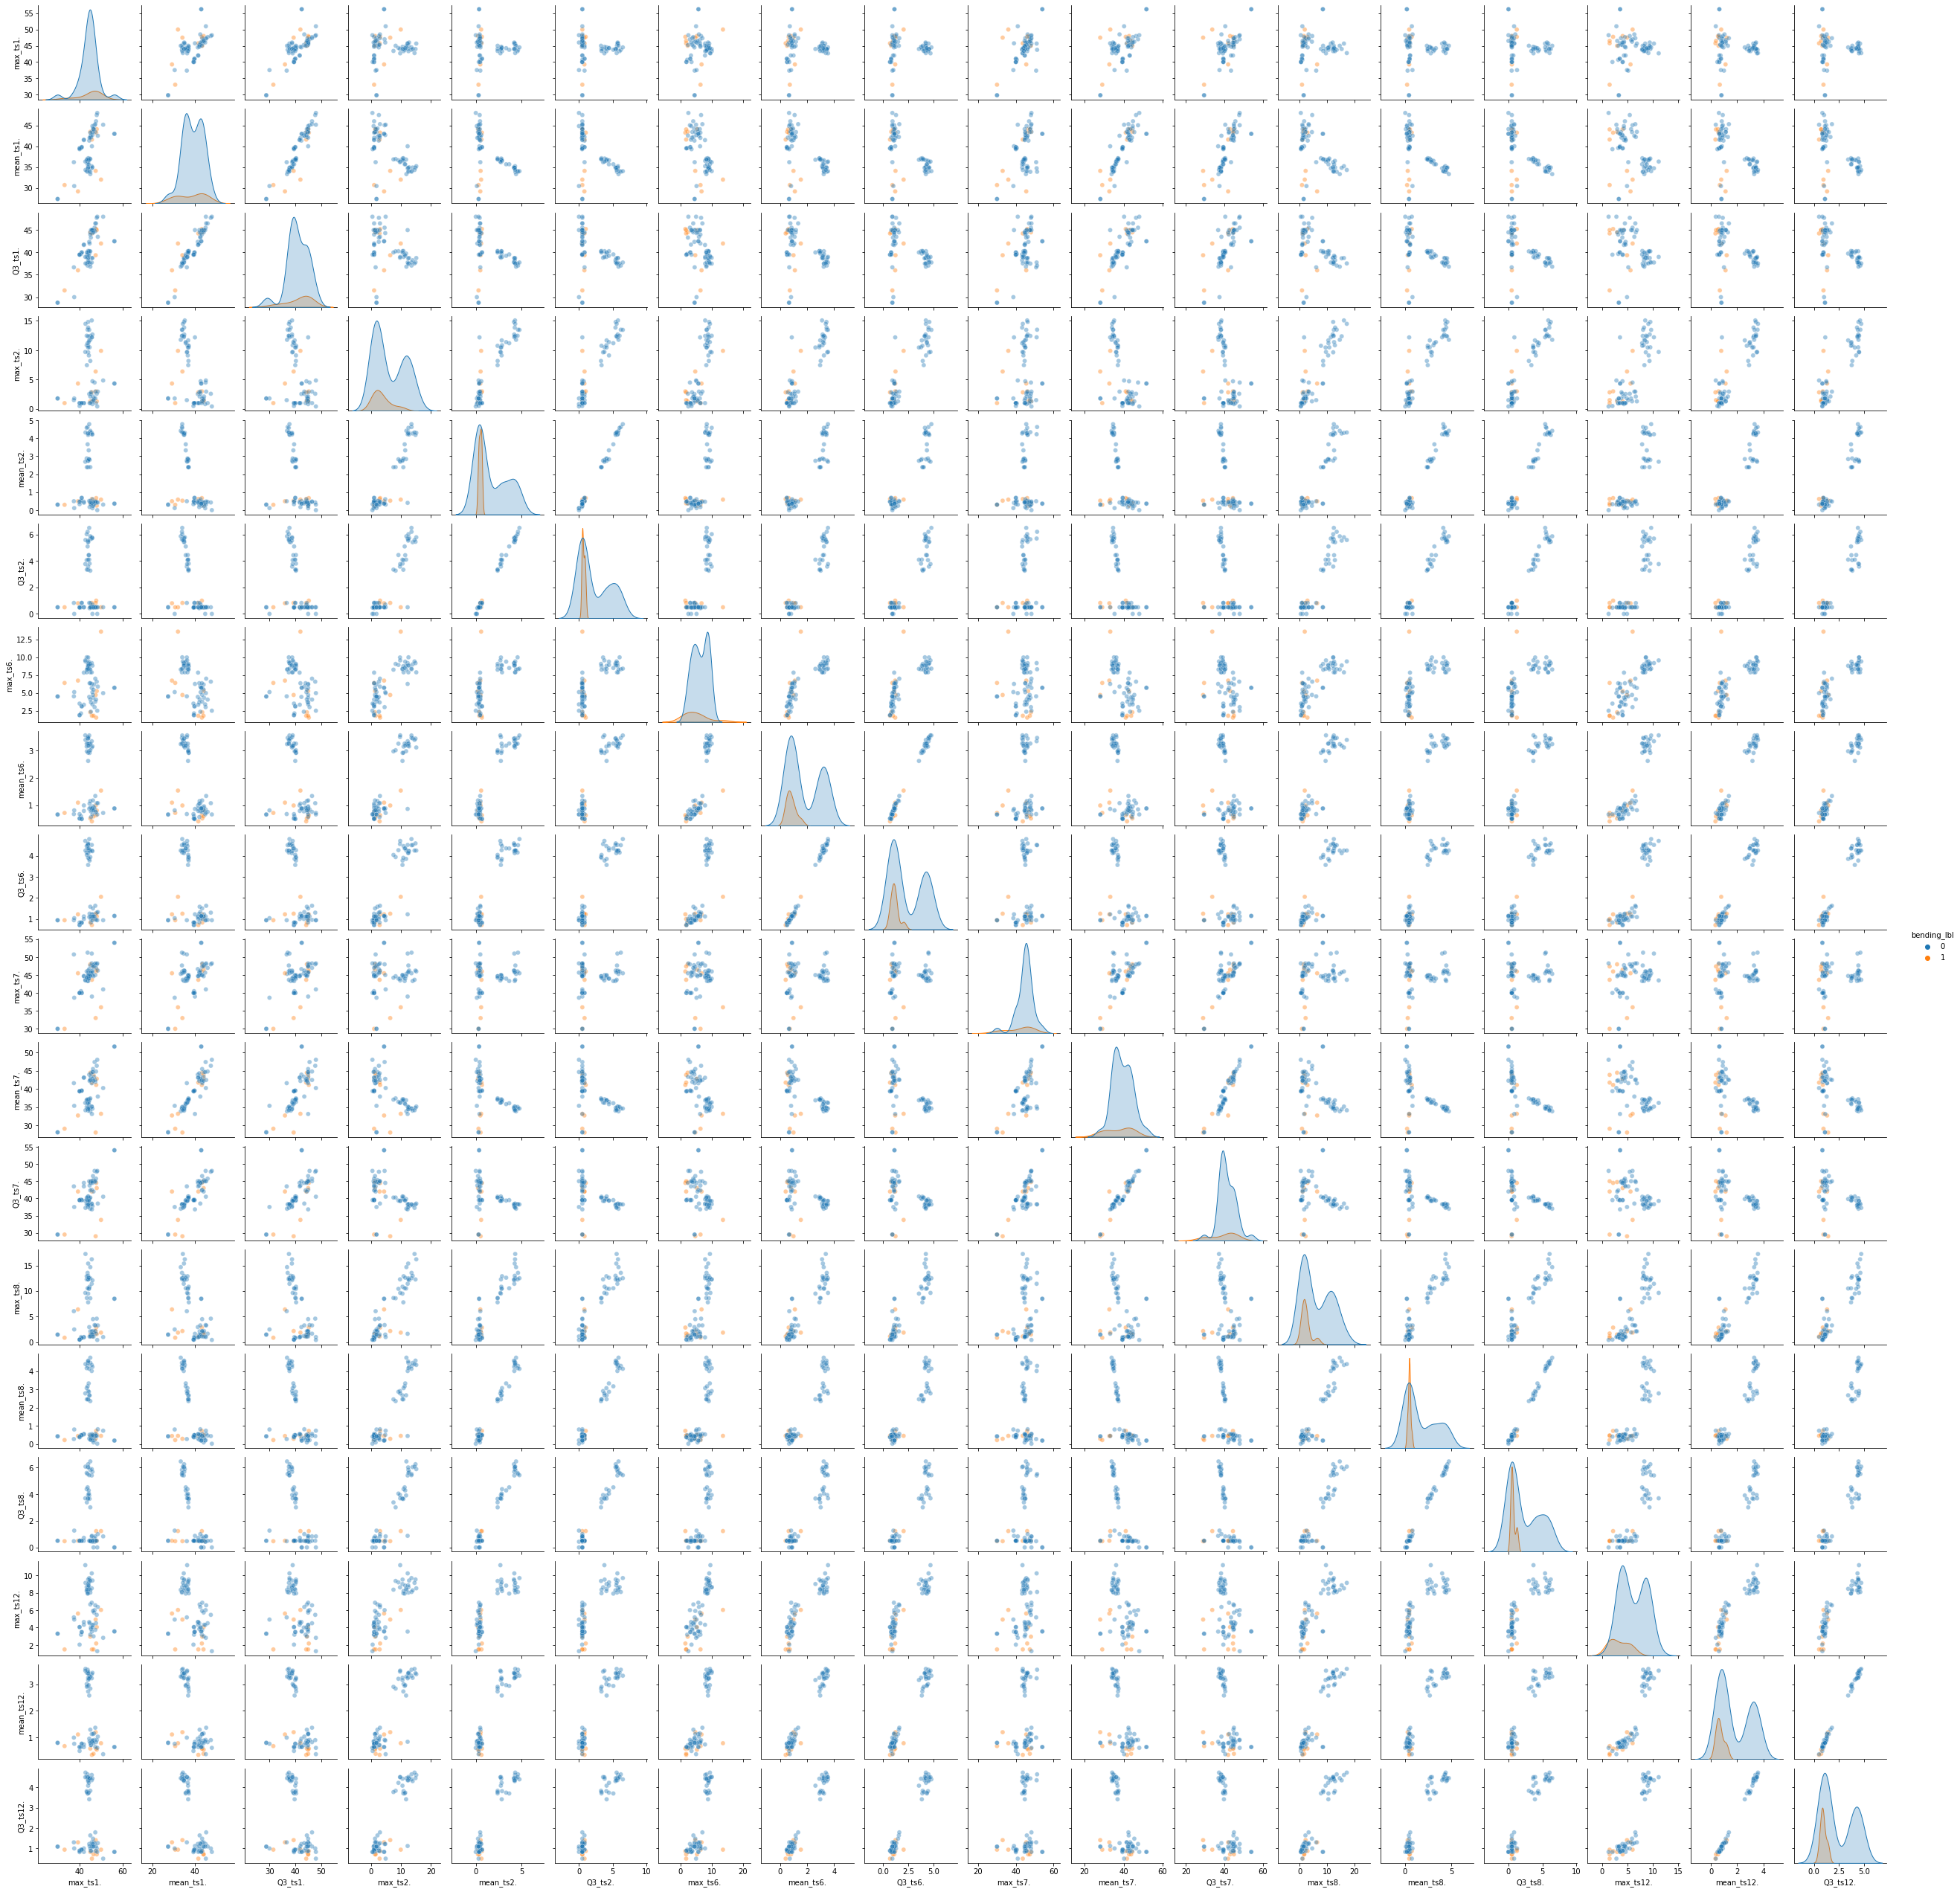

In [11]:
pruned_trainTS_df_expanded = trainTS_df_expanded.copy()

# pruning the training set to only include the 3 selected features (from c.iv) and time series 1, 2, and 6
# TA said there was a typo, and it is meant to be 6 time series (includind both parts after the split)
for col in pruned_trainTS_df_expanded.columns:
    if ("ts1." not in col) and ("ts2." not in col) and ("ts6." not in col) and ("ts7." not in col) and ("ts8." not in col) and ("ts12." not in col) and ("bending_lbl" not in col):
        pruned_trainTS_df_expanded.drop(columns=col, inplace=True)
#     elif ("min" in col) or ("mean" in col) or ("median" in col) or ("stdev" in col):
    elif ("min" in col) or ("Q1" in col) or ("median" in col) or ("stdev" in col):
        pruned_trainTS_df_expanded.drop(columns=col, inplace=True)
#     else:
#         print(col)

        
display(pruned_trainTS_df_expanded)


# depict scatter plots of the features extracted from both parts of the time series 1,2, and 12
pairplot = sns.pairplot(pruned_trainTS_df_expanded, hue = "bending_lbl", height=2, aspect=1, plot_kws=dict(alpha=0.4))

# Orange dots are instances classified as "bending"
plt.show()



max_ts1.  mean_ts1.  Q3_ts1.  max_ts2.  mean_ts2.  Q3_ts2.  \
Instance                                                               
1            45.00  43.486208  44.5000      1.30   0.378667     0.50   
2            48.00  44.117042  45.0000      1.30   0.250042     0.50   
3            47.75  43.278875  45.2500      3.00   0.673292     1.00   
4            45.75  41.621208  44.2500      2.83   0.623083     0.83   
5            46.50  44.057167  45.0000      1.50   0.381042     0.50   
...            ...        ...      ...       ...        ...      ...   
65           43.75  35.694167  39.5625     11.20   3.658042     5.10   
66           44.25  35.692167  39.2500     11.39   3.324208     4.44   
67           42.67  36.342750  39.0000      9.71   2.691917     3.77   
68           45.00  36.954208  40.2500      8.18   2.392667     3.27   
69           43.40  36.865417  40.0000      7.46   2.387250     3.35   

          max_ts6.  mean_ts6.  Q3_ts6.  bending_lbl  
Instance                                             
1             2.28   0.524875   0.8300            1  
2             5.26   0.815417   1.1200            1  
3             1.53   0.640958   1.2200            1  
4             1.79   0.419083   0.7100            1  
5             1.79   0.598250   1.0000            1  
...            ...        ...      ...          ...  
65            8.50   3.249542   4.3450            0  
66            9.39   3.172417   4.3500            0  
67            9.57   3.547750   4.7025            0  
68            9.07   3.005375   3.9375            0  
69            8.26   2.964792   4.0375            0  

[69 rows x 10 columns]

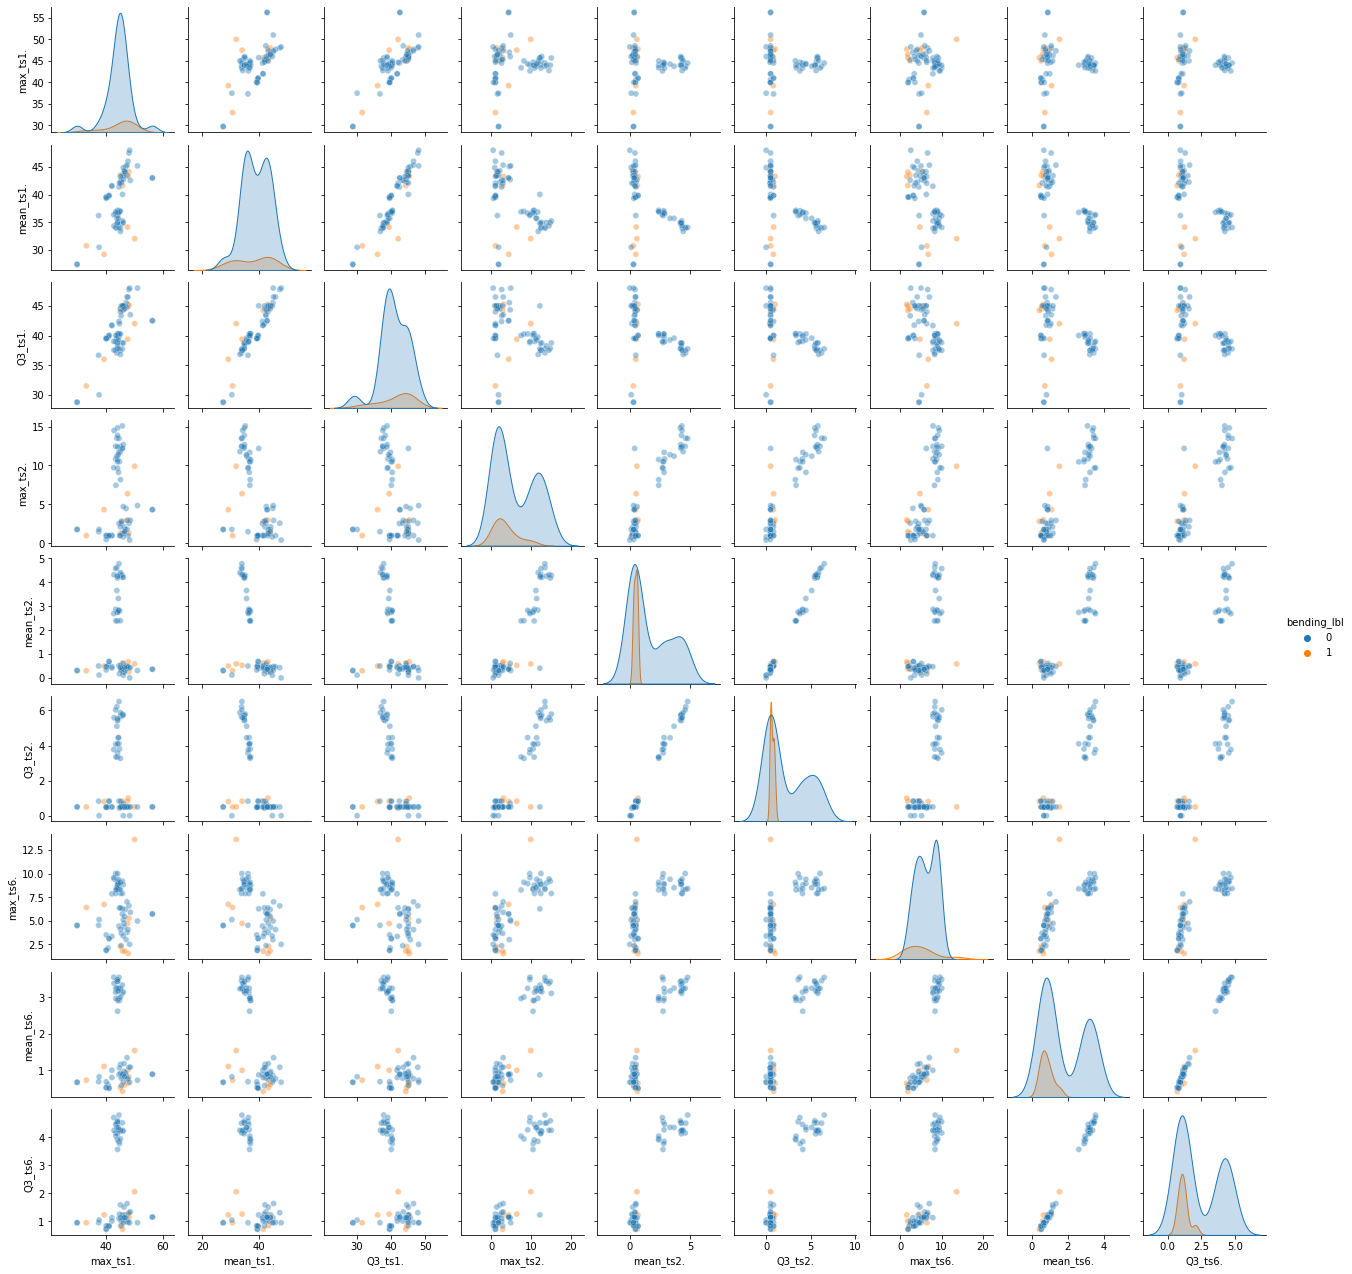

max_ts7.  mean_ts7.  Q3_ts7.  max_ts8.  mean_ts8.  Q3_ts8.  \
Instance                                                               
1            48.00  44.452042  44.7500      1.50   0.447583   0.5000   
2            46.50  42.792875  43.0000      1.58   0.506125   0.5000   
3            46.00  41.080750  44.5000      2.86   0.718792   1.2275   
4            43.67  41.734917  42.0000      1.12   0.448875   0.5000   
5            47.40  43.851833  45.0000      1.70   0.471458   0.5000   
...            ...        ...      ...       ...        ...      ...   
65           43.33  36.065583  39.5000     10.54   3.170583   4.5075   
66           44.00  35.812542  39.3725     12.60   3.332000   4.2750   
67           43.50  36.145417  39.2700      9.63   2.780125   3.6850   
68           44.67  37.399875  40.2500      8.58   2.355750   3.0075   
69           44.25  37.049500  40.2500      8.64   2.452917   3.3775   

          max_ts12.  mean_ts12.  Q3_ts12.  bending_lbl  
Instance                                                
1              2.96    0.585750    0.8300            1  
2              4.06    0.543875    0.7100            1  
3              2.18    0.586083    0.8700            1  
4              1.50    0.347500    0.5000            1  
5              1.50    0.388333    0.7100            1  
...             ...         ...       ...          ...  
65             7.89    2.936500    3.7000            0  
66             8.81    2.966917    3.7400            0  
67            11.15    3.513250    4.5000            0  
68             9.34    2.838083    3.8325            0  
69             8.34    2.904458    3.7700            0  

[69 rows x 10 columns]

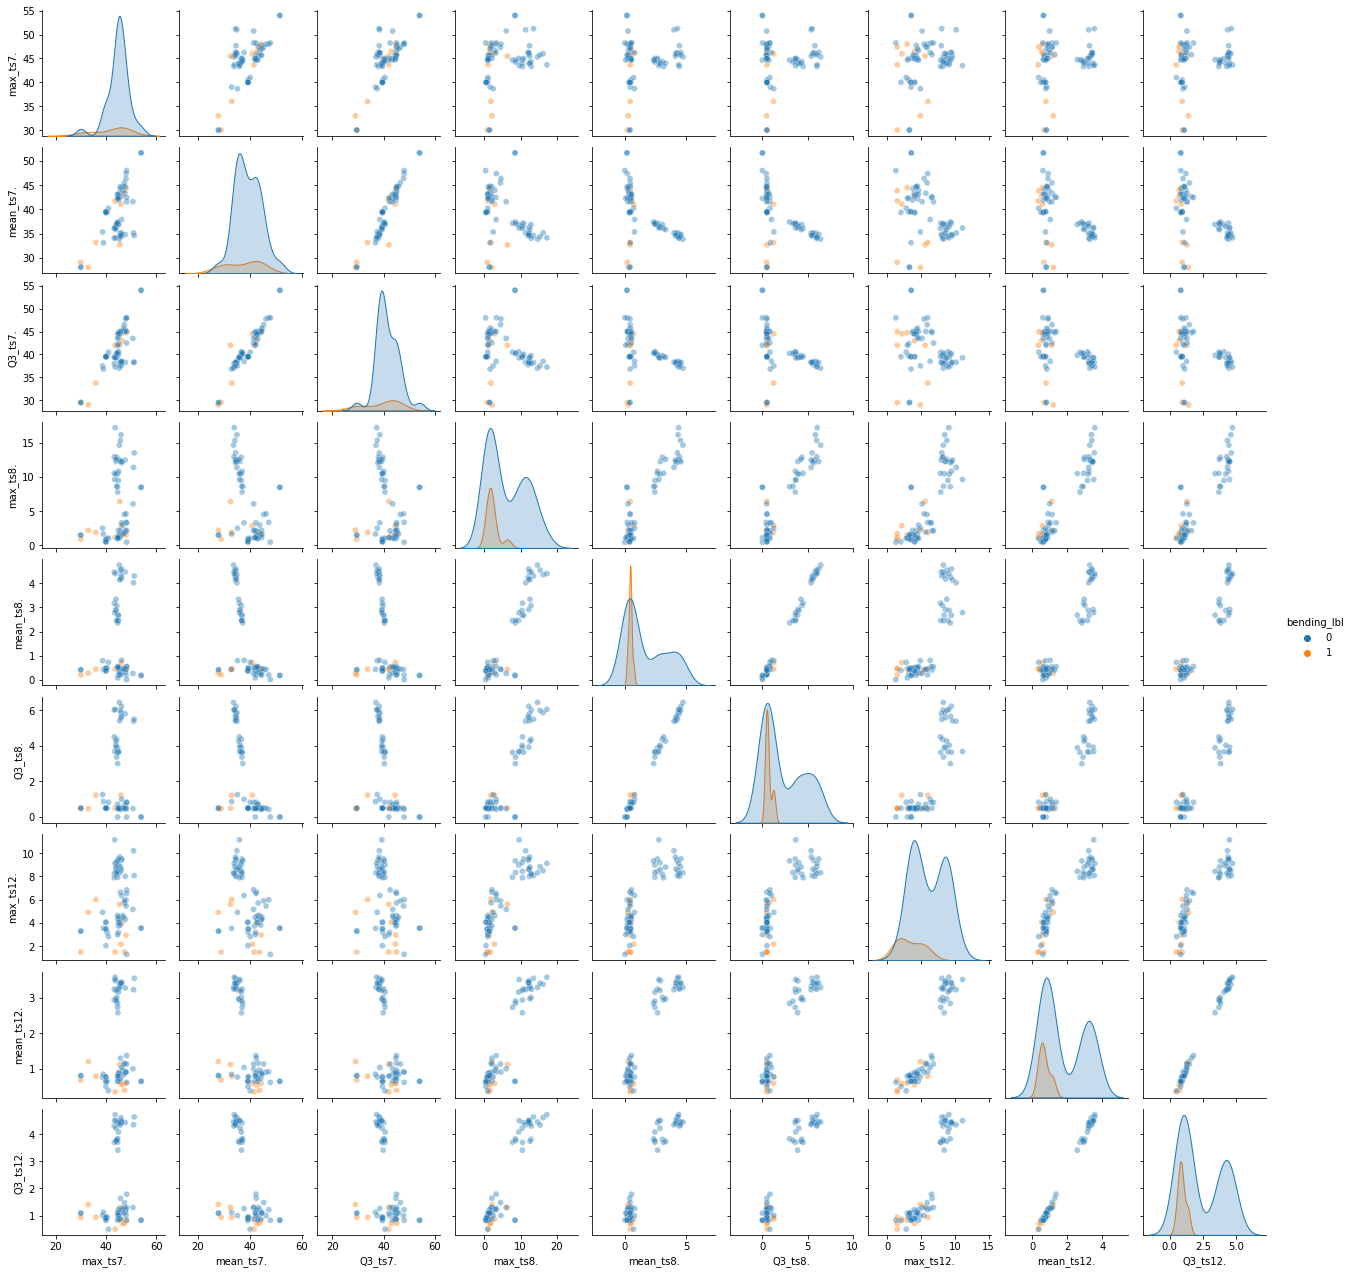

In [12]:
# Other than what the TA explicitly asked for, I included these smaller pairplot since they are easier to see and interpret


pruned_trainTS_df_expanded = trainTS_df_expanded.copy()

# pruning the training set to only include the 3 selected features (from c.iv) and time series 1, 2, and 12
for col in pruned_trainTS_df_expanded.columns:
    if ("ts1." not in col) and ("ts2." not in col) and ("ts6." not in col) and ("bending_lbl" not in col):
        pruned_trainTS_df_expanded.drop(columns=col, inplace=True)
#     elif ("min" in col) or ("mean" in col) or ("median" in col) or ("stdev" in col):
    elif ("min" in col) or ("Q1" in col) or ("median" in col) or ("stdev" in col):
        pruned_trainTS_df_expanded.drop(columns=col, inplace=True)
        
display(pruned_trainTS_df_expanded)
# depict scatter plots of the features extracted from both parts of the time series 1,2, and 12
pairplot = sns.pairplot(pruned_trainTS_df_expanded, hue = "bending_lbl", height=2, aspect=1, plot_kws=dict(alpha=0.4))
# Orange dots are instances classified as "bending"
plt.show()


pruned_trainTS_df_expanded = trainTS_df_expanded.copy()

# pruning the training set to only include the 3 selected features (from c.iv) and time series 1, 2, and 12
for col in pruned_trainTS_df_expanded.columns:
    if ("ts7." not in col) and ("ts8." not in col) and ("ts12." not in col) and ("bending_lbl" not in col):
        pruned_trainTS_df_expanded.drop(columns=col, inplace=True)
#     elif ("min" in col) or ("mean" in col) or ("median" in col) or ("stdev" in col):
    elif ("min" in col) or ("Q1" in col) or ("median" in col) or ("stdev" in col):
        pruned_trainTS_df_expanded.drop(columns=col, inplace=True)
        
display(pruned_trainTS_df_expanded)
# depict scatter plots of the features extracted from both parts of the time series 1,2, and 12
pairplot = sns.pairplot(pruned_trainTS_df_expanded, hue = "bending_lbl", height=2, aspect=1, plot_kws=dict(alpha=0.4))
# Orange dots are instances classified as "bending"
plt.show()


>I don't see any considerable differences. If anything, the distributions look a tiny bit worse with regard to the seperatability of their classes; i.e. the amount of overlap looks to be a bit more. 

-----------
## 1.d.iii
Binary Classification Using Logistic Regression

Break each time series in your training set into l ∈ {1, 2, . . . , 20} time series of approximately equal length and use logistic regression5 to solve the binary classification problem, using time-domain features. Remember that breaking each of the time series does not change the number of instances. It only changes the number of features for each instance. Calculate the p-values for your logistic regression parameters in each model corresponding to each value of l and refit a logistic regression model using your pruned set of features.6 Alternatively, you can use backward selection using sklearn.feature selection or glm in R. Use 5-fold cross-validation to determine the best value of the pair (l, p), where p is the number of features used in recursive feature elimination. Explain what the right way and the wrong way are to perform cross-validation in this problem.7 Obviously, use the right way! Also, you may encounter the problem of class imbalance, which may make some of your folds not having any instances of the rare class. In such a case, you can use stratified cross validation. Research what it means and use it if needed.
In the following, you can see an example of applying Python’s Recursive Feature Elimination, which is a backward selection algorithm, to logistic re- gression.

In [13]:
# because of all the computation involved (e.g. for the cross validation), this cell long to load
# many of the next cells are take long to load too

splitL = list(range(1, 21, 1))


for split_n in splitL:
    
    stats = ["min_ts", "max_ts", "mean_ts", "median_ts", "Q1_ts", "Q3_ts", "stdev_ts"]
    stat_colL = []

    for i in range(split_n*6):
        for stat in stats:
            stat_colL.append(stat+str(i+1)+".")

    stat_colL.insert(0, "file")
    stat_colL.insert(0, "folder")


    trainTS_df_expanded = pd.DataFrame(columns=stat_colL)
    setsT = [(train_set_filesL, trainTS_df_expanded)]

    # It's set up like this incase I need to add a test_set tuple later
    for set_filesL, ts_df in setsT:

    #     ts_df = pd.DataFrame(columns=stat_colL)
        ts_df.index.name = "Instance"

        inst = 0
        # loop through all test dataset "csv" files
        for file in set_filesL:

            file_df = pd.read_csv(file, skiprows=4)

            folder_name = file[13: file.find("/", file.find("/", 13))]
            file_name = file[file.find("/", 13)+1:]


            # print(file_df.shape[0])
            break_rows = file_df.shape[0]//split_n
            # print(break_rows)
            modulus = file_df.shape[0]%split_n

            break_dfL = []
            for i in range(split_n):
                # I am using this so that the new timeseries order is 1,2,3,1.5,2.5,3.5 -- rather than 1,1.5,2,2.5,3,3.5
                # The Piazza TAs said to have such an ordering

                if i+1 <= modulus:
                    # since not all numbers in set l are divisors of 480, we will have some timeseries with 1 more or less rows
                    new_break_rows = break_rows + 1
                    df = file_df[(0+i*new_break_rows):(new_break_rows+i*new_break_rows)]
                else:
                    df = file_df[(modulus+i*break_rows):(modulus+break_rows+i*break_rows)]
    #             break_dfL[i].append(df)
                break_dfL.append(df)


            # extracting domain type features for all time series
            instance_valsL = []
            instance_valsL.append([folder_name])
            instance_valsL.append([file_name])

            for break_df in break_dfL:

                # loop through all (ie 12) time series and add their stats
                for ts_name in list(break_dfL[0].columns)[1:]:

                    df = break_df[ts_name]

                    # statistical attribute values for a single time series
                    attr_valsL = []
                    attr_valsL.append(df.min())
                    attr_valsL.append(df.max())
                    attr_valsL.append(df.mean())
                    attr_valsL.append(df.quantile(.50))
                    attr_valsL.append(df.quantile(.25))
                    attr_valsL.append(df.quantile(.75))
                    attr_valsL.append(df.std())

        #             print(attr_valuesL)

                    instance_valsL.append(attr_valsL)



            # flattening the list to input into single dataframe row
            instance_valsL_flat = [item for sublist in instance_valsL for item in sublist]

            ts_df.loc[0+inst] = instance_valsL_flat
            inst += 1

        ts_df.index +=1

    num_rows = trainTS_df_expanded.shape[0]
    bending_label = []
    for i in range(num_rows):
        if "bending" in trainTS_df_expanded.iloc[i]["folder"]:
            bending_label.append(1)
        else:
            bending_label.append(0)

    # adding the "bending" label column to the dataframe 
    trainTS_df_expanded["bending_lbl"] = bending_label


    # split training set into its features and class variable

    # display(trainTS_df_expanded.iloc[:, 1:-1])
    trainX = trainTS_df_expanded.iloc[:, 2:-1]
    trainY = trainTS_df_expanded.iloc[:, -1]

    # creating the logistic regression classifier and doing feature selection based on the 5-fold cross validation
    log_reg_model = LogisticRegression(penalty="none")
    # or put parameter C=float("inf")

    # first we create our validator for RFECV -- using the suggest stratified cross validation
    validator = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    # random state for reproducability and consistency of future answers

    # running a Recursive feature elimination with cross-validation to select the number of features.
    attr_selector = RFECV(estimator=log_reg_model, cv=validator, scoring="accuracy")
    attr_selector.fit(trainX, trainY)


    # the sklearn link for RFECV said that attribute cv_results_ should be used instead of grid_scores_ now
    # But it didn't work; so I used the old method; may need to change it if/when using the newer version
    print("For pair (" + str(split_n) + ",", str(attr_selector.n_features_) + "), the (accuracy) score is", round(max(attr_selector.grid_scores_), 4))




For pair (1, 7), the (accuracy) score is 1.0
For pair (2, 7), the (accuracy) score is 1.0
For pair (3, 4), the (accuracy) score is 0.9857
For pair (4, 18), the (accuracy) score is 0.9714
For pair (5, 1), the (accuracy) score is 0.9714
For pair (6, 1), the (accuracy) score is 0.9714
For pair (7, 18), the (accuracy) score is 0.9714
For pair (8, 27), the (accuracy) score is 0.9714
For pair (9, 29), the (accuracy) score is 0.9571
For pair (10, 29), the (accuracy) score is 0.9714
For pair (11, 25), the (accuracy) score is 0.9714
For pair (12, 1), the (accuracy) score is 0.9714
For pair (13, 1), the (accuracy) score is 0.9857
For pair (14, 1), the (accuracy) score is 0.9714
For pair (15, 69), the (accuracy) score is 0.9714
For pair (16, 12), the (accuracy) score is 0.9857
For pair (17, 4), the (accuracy) score is 0.9714
For pair (18, 2), the (accuracy) score is 0.9857
For pair (19, 1), the (accuracy) score is 0.9857
For pair (20, 13), the (accuracy) score is 0.9857


-----------
## 1.d.iv

Report the confusion matrix and show the ROC and AUC for your classifier on train data. Report the parameters of your logistic regression βi’s as well as the p-values associated with them.

In [14]:
# With our current random state, we have two best (l, p) pairs
# I will use the (1, 5) since it requires less computation than the alternative
# The l = 1 dataset is simply our original trainTS_lbld_df from d.i

# split training set into its features and class variable

# display(trainTS_df_expanded.iloc[:, 1:-1])
trainX = trainTS_lbld_df.iloc[:, 2:-1]
trainY = trainTS_lbld_df.iloc[:, -1]

# creating the logistic regression classifier and doing feature selection based on the 5-fold cross validation
log_reg_model = LogisticRegression(penalty="none")
# or put parameter C=float("inf")

# first we create our validator for RFECV -- using the suggest stratified cross validation
validator = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
# included a random state for reproducability

# running a Recursive feature elimination with cross-validation to select the number of features.
attr_selector = RFECV(estimator=log_reg_model, cv=validator, scoring="accuracy")
attr_selector.fit(trainX, trainY)


# chosen = [f for i, f in enumerate(feature) if selector.support_[i]]

features = list(trainTS_lbld_df.columns)[2:-1]
print("The selected features are the following:")
# "The mask of selected features."
for i, attr in enumerate(attr_selector.support_):
    # attr_selector.support_ returns an array of True or False for if the feature is picked or not
    if attr:
        print(features[i])



The selected features are the following:
mean₁
Q3₁
max₂
min₅
max₅
mean₅
Q1₅


In [15]:
# Report the parameters of your logistic regression βi’s as well as the p-values associated with them.

best_pruned_trainTS_df = trainTS_lbld_df.copy()

for col in best_pruned_trainTS_df.columns:
    if (col != "Q3₁") and (col != "max₂") and (col != "min₅") and (col != "max₅") and (col != "Q1₅") and (col != "bending_lbl"):
        best_pruned_trainTS_df.drop(columns=col, inplace=True)

# display(best_pruned_trainTS_df)

trainY = best_pruned_trainTS_df["bending_lbl"]
trainX_all = best_pruned_trainTS_df[["Q3₁", "max₂", "min₅", "max₅", "Q1₅"]]
# adding an intercept 
trainX_all_const = sm.add_constant(trainX_all, prepend=True)

# creating logistic regression model (using statsmodels since we want its summary results)
model = sm.Logit(trainY, trainX_all_const)
results = model.fit(method="bfgs")
# "Perfect separation detected, results not available"
display(results.summary())


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 27
         Function evaluations: 30
         Gradient evaluations: 30


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            bending_lbl   No. Observations:                   69
Model:                          Logit   Df Residuals:                       63
Method:                           MLE   Df Model:                            5
Date:                Fri, 08 Oct 2021   Pseudo R-squ.:                   1.000
Time:                        19:53:16   Log-Likelihood:            -1.5602e-05
converged:                       True   LL-Null:                       -26.718
Covariance Type:            nonrobust   LLR p-value:                 2.738e-10
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.0993   2.87e+08  -3.83e-09      1.000   -5.62e+08    5.62e+08
Q3₁           -7.3704   3.97e+06  -1.86e-06      1.000   -7.77e+06    7.77e+06
max₂          -2.4004   3.86e+06  -6.22e-07      1.000   -7.56e+06    7.56e+06
min₅           6.7364   3.23e+06   2.08e-06      1.000   -6.34e+06    6.34e+06
max₅           6.7383      3e+06   2.25e-06      1.000   -5.88e+06    5.88e+06
Q1₅            4.3825   3.12e+06   1.41e-06      1.000   -6.11e+06    6.11e+06
==============================================================================

Complete Separation: The results show that there iscomplete separation.
In this case the Maximum Likelihood Estimator does not exist and the parameters
are not identified.
"""

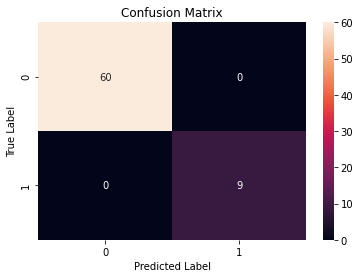

TN = 60 
FP = 0 
FN = 0 
TP = 9


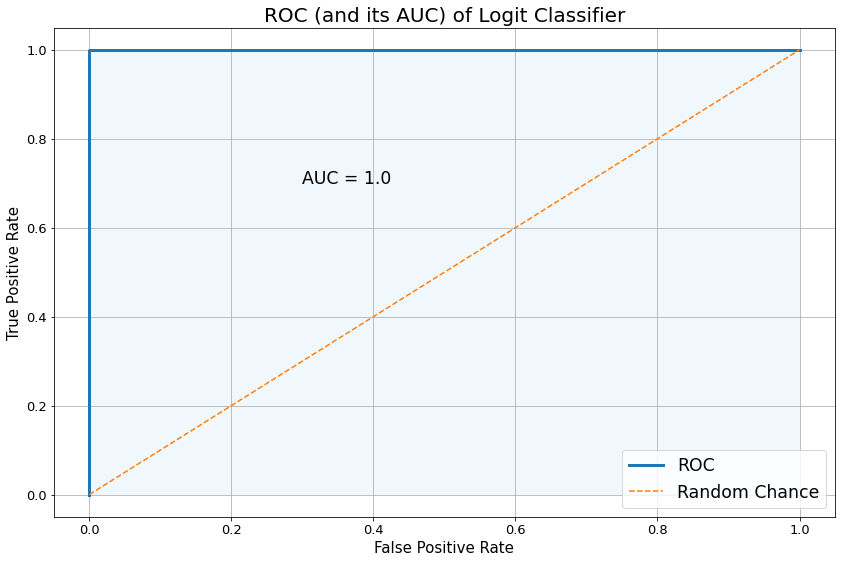

In [16]:
# Report the confusion matrix and show the ROC and AUC for your classifier on train data.

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html


# using the sklearn log_reg_model from before
log_reg_model.fit(trainX_all_const, trainY)
# not sure if we are supposed to include const

# our log-reg classifier's label predictions
prediction = log_reg_model.predict(trainX_all_const)
prediction_prob = log_reg_model.predict_proba(trainX_all_const)



# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
matrix = confusion_matrix(trainY, prediction.round())
# print(matrix)

# https://seaborn.pydata.org/generated/seaborn.heatmap.html
sns.heatmap(matrix, annot=True)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

matrix_flat = matrix.flatten()
tn = matrix_flat[0]
fp = matrix_flat[1]
fn = matrix_flat[2]
tp = matrix_flat[3]
print("TN =", tn, "\nFP =", fp, "\nFN =", fn, "\nTP =", tp)



#showing the receiver operating characteristic curve (Curve) 

# The second positional paramter of roc takes y_score: probability estimates of the "positive" class
# log_reg_model.predict_proba returns probability of the sample for each class in the model, 
# where classes are ordered as they are in self.classes_ (ie log_reg_model.classes_); here positive is index 1 of each array

# pos_label is the label of the positive class
fpr, tpr, thresh = roc_curve(trainY, prediction_prob[:, 1], pos_label=1)

# area under the ROC curve
auc_val = auc(fpr, tpr)
# print(auc_val)

# setting plot size

fig, ax = plt.subplots(figsize=(14, 9))
# plots the predicitve power (i.e. prob curve) of our classifier
ax.plot(fpr, tpr, label="ROC", linewidth=3)
# plots the predictive power we would expect with random guessing
ax.plot([0, 1], [0, 1], "--", label="Random Chance")
ax.legend(loc="lower right", fontsize="xx-large")
kwargs = {"fc":"xkcd:sky blue", "alpha":0.1}
# The blue shaded region represnts the AOC -- ie it covers 100% of the area under ROC; 
# our classifier get perfect seperation of the classes with a tpr of 100% and a fpr of 0%
ax.fill_between(np.arange(0,1.1,0.2), 1, 0, **kwargs)

plt.grid(True)
plt.text(0.3, 0.7, "AUC = %s" %auc_val, fontsize="xx-large")
plt.tick_params(labelsize=13)
plt.xlabel("False Positive Rate", fontsize=15)
plt.ylabel("True Positive Rate", fontsize=15)
plt.title("ROC (and its AUC) of Logit Classifier", fontsize=20)


plt.show()



As mentioned in the output aboe, the selected features are the following: Q3₁, max₂, min₅, max₅, and Q1₅.

However, our model's summary results give p-value ~ 1.0 for all the parameters. This is because perfect seperation was detected, so the "Maximum Likelihood Estimator does not exist" and the parameters are likely not properly identified.

-----------
## 1.d.v

Test the classifier on the test set. Remember to break the time series in your test set into the same number of time series into which you broke your training set. Remember that the classifier has to be tested using the features extracted from the test set. Compare the accuracy on the test set with the cross-validation accuracy you obtained previously.

In [17]:
# Since 1=1 in our best (l,p) pair, we don't need to break the test set

# creating a labeled testing set
testTS_lbld_df = testTS_df.copy()

num_rows = testTS_df.shape[0]
# print(allTS_df.iloc[85]["folder"])
bending_label = []
for i in range(num_rows):
    if "bending" in testTS_df.iloc[i]["folder"]:
        bending_label.append(1)
    else:
        bending_label.append(0)
testTS_lbld_df["bending_lbl"] = bending_label
# display(testTS_lbld_df)

best_pruned_testTS_df = testTS_lbld_df.copy()

# pruning based on the feature selection with cross validation in d.iii
for col in best_pruned_testTS_df.columns:
    if (col != "Q3₁") and (col != "max₂") and (col != "min₅") and (col != "max₅") and (col != "Q1₅") and (col != "bending_lbl"):
        best_pruned_testTS_df.drop(columns=col, inplace=True)

display(best_pruned_testTS_df)

testY = best_pruned_testTS_df["bending_lbl"]
testX_all = best_pruned_testTS_df[["Q3₁", "max₂", "min₅", "max₅", "Q1₅"]]
# adding an intercept 
testX_all_const = sm.add_constant(testX_all, prepend=True)



Q3₁   max₂   min₅   max₅      Q1₅  bending_lbl
Instance                                                    
1         42.0000   1.30  27.25  38.25  33.0000            1
2         43.6700   1.22  27.67  38.50  32.0000            1
3         37.7500  14.50   6.75  26.00  14.7500            0
4         36.7500  13.05   7.25  25.00  14.6275            0
5         38.2500  13.44   7.00  24.50  14.2500            0
6         26.5000   6.87  10.67  30.00  20.5000            1
7         30.0000   7.76   0.00  33.00  15.0000            1
8         46.5000   3.90   0.00  23.00   9.3300            0
9         44.5000   2.12   2.00  21.25  12.7500            0
10        45.3725   3.34   1.33  21.33  13.0000            0
11        43.5000   4.44   1.00  28.00  10.1875            0
12        46.5000   4.87   2.00  24.00  16.5000            0
13        45.3300   1.00   4.75  26.75  17.6275            0
14        29.0000   1.79   0.00  21.00   5.5000            0
15        48.0000   3.11   0.00  12.75   2.0000            0
16        48.0000   0.43   0.00  12.00   4.6700            0
17        40.2500   8.58   7.00  25.50  17.9500            0
18        40.2500   9.91  10.50  24.33  18.0000            0
19        40.0625  14.17   7.50  24.25  16.0000            0

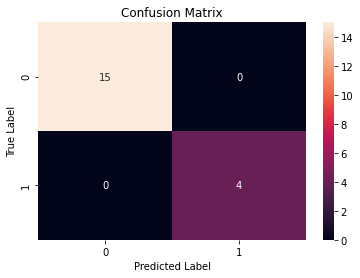

TN = 15 
FP = 0 
FN = 0 
TP = 4


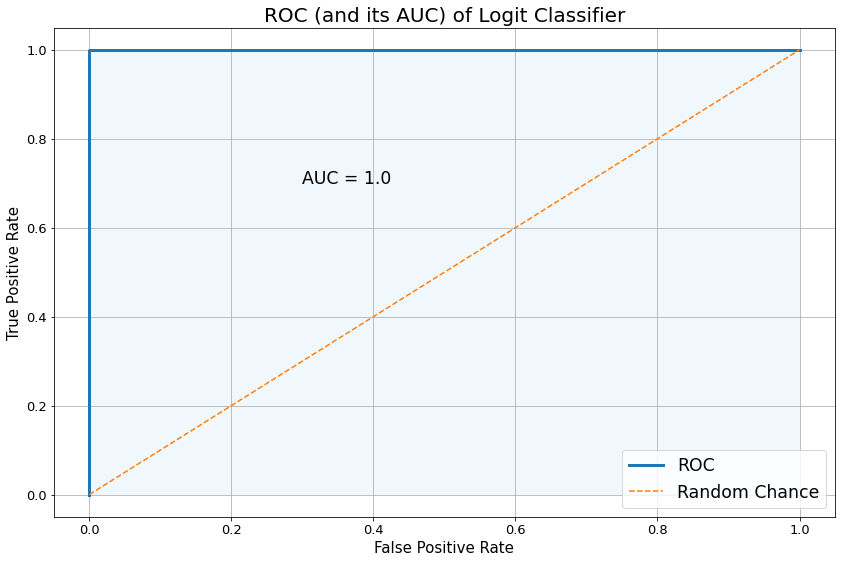

In [18]:
# https://seaborn.pydata.org/generated/seaborn.heatmap.html

# Report the confusion matrix and show the ROC and AUC for your classifier on testing data.
# Compare the accuracy on the test set with the cross-validation accuracy you obtained previously (in d.iv)

# So, we use the sklearn log_reg_model from before: 
log_reg_model.fit(trainX_all_const, trainY)
# But now, we predict the labels for the test set

# our log-reg classifier's label predictions for the test set
prediction = log_reg_model.predict(testX_all_const)
prediction_prob = log_reg_model.predict_proba(testX_all_const)

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
matrix = confusion_matrix(testY, prediction.round())

sns.heatmap(matrix, annot=True)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

matrix_flat = matrix.flatten()
tn = matrix_flat[0]
fp = matrix_flat[1]
fn = matrix_flat[2]
tp = matrix_flat[3]
print("TN =", tn, "\nFP =", fp, "\nFN =", fn, "\nTP =", tp)


#showing the receiver operating characteristic curve (Curve) 

# The second positional paramter of roc takes y_score: probability estimates of the "positive" class
# log_reg_model.predict_proba returns probability of the sample for each class in the model, 
# where classes are ordered as they are in self.classes_ (ie log_reg_model.classes_); here positive is index 1 of each array

# pos_label is the label of the positive class
fpr, tpr, thresh = roc_curve(testY, prediction_prob[:, 1], pos_label=1)

# area under the ROC curve
auc_val = auc(fpr, tpr)

# setting plot size

fig, ax = plt.subplots(figsize=(14, 9))
# plots the predicitve power (i.e. prob curve) of our classifier
ax.plot(fpr, tpr, label="ROC", linewidth=3)
# plots the predictive power we would expect with random guessing
ax.plot([0, 1], [0, 1], "--", label="Random Chance")
ax.legend(loc="lower right", fontsize="xx-large")
kwargs = {"fc":"xkcd:sky blue", "alpha":0.1}
# The blue shaded region represnts the AOC -- ie it covers 100% of the area under ROC; 
# our classifier get perfect seperation of the classes with a tpr of 100% and a fpr of 0%
ax.fill_between(np.arange(0,1.1,0.2), 1, 0, **kwargs)

plt.grid(True)
plt.text(0.3, 0.7, "AUC = %s" %auc_val, fontsize="xx-large")
plt.tick_params(labelsize=13)
plt.xlabel("False Positive Rate", fontsize=15)
plt.ylabel("True Positive Rate", fontsize=15)
plt.title("ROC (and its AUC) of Logit Classifier", fontsize=20)


plt.show()



>This testing accuracy of the classifer and the previous cross-validation accuracy are the same -- at 100%. <br>
>Both have a perfect ROC with AOC = 1


-----------
## 1.d.vi

Do your classes seem to be well-separated to cause instability in calculating logistic regression parameters?


>The logistic regression model's summary results also outputted the following information: <br>
>Complete Separation: The results show that there is complete separation.
In this case the Maximum Likelihood Estimator does not exist and the parameters
are not identified. <br>

>So, the answer is yes. There is clearly perfect seperation (also visualized bt the ROC/AUC), and due to this the logistic regression parameters were unable to be properly calculated; all the feature p-values were ~1.


-----------
## 1.d.vii

From the confusion matrices you obtained, do you see imbalanced classes? If yes, build a logistic regression model based on case-control sampling and adjust its parameters. Report the confusion matrix, ROC, and AUC of the model.

Yes, there are imbalances; especially with the test set.

A dataset is imbalanced when members of certain class(es) are rare. This is the case here. This is clearly the case for our training set since there are only 9 positive (i.e. 1) labels -- out of 69.


In [19]:
# https://stats.stackexchange.com/questions/365696/valueerror-requesting-3-fold-cross-validation-but-provided-less-than-3-examples
# Finding the best (l, p) pair after case-control sampling (per the 5:1 standard), by oversampling the rare cases 

# because of all the computation involved (e.g. for the cross validation), this cell long to load

trainTS_df_oversampledL = []

splitL = list(range(1, 21, 1))

print("Oversampled the case instances (with label=1) to get a case-control ratio of 5:1.")
print("With the case-control sampling, the training set ratio changed from 9:60 to 300:60\n")

for split_n in splitL:
    
    stats = ["min_ts", "max_ts", "mean_ts", "median_ts", "Q1_ts", "Q3_ts", "stdev_ts"]
    stat_colL = []

    for i in range(split_n*6):
        for stat in stats:
    #         print(stat+sub)
            stat_colL.append(stat+str(i+1)+".")

    # print(stat_colL)

    stat_colL.insert(0, "file")
    stat_colL.insert(0, "folder")


    trainTS_df_expanded = pd.DataFrame(columns=stat_colL)
    setsT = [(train_set_filesL, trainTS_df_expanded)]

    # It's set up like this incase I need to add a test_set tuple later
    for set_filesL, ts_df in setsT:

    #     ts_df = pd.DataFrame(columns=stat_colL)
        ts_df.index.name = "Instance"

        inst = 0
        # loop through all test dataset "csv" files
        for file in set_filesL:

            file_df = pd.read_csv(file, skiprows=4)

        #     print(file)
        #     file_name = file[file.find("AReM/")]
            # "/" after "AReM" is at index 12
            folder_name = file[13: file.find("/", file.find("/", 13))]
            file_name = file[file.find("/", 13)+1:]

    #         display(file_df)


            # print(file_df.shape[0])
            break_rows = file_df.shape[0]//split_n
            # print(break_rows)
            modulus = file_df.shape[0]%split_n

            break_dfL = []
            for i in range(split_n):
                # I am using this so that the new timeseries is 1,2,3,1.5,2.5,3.5 -- rather than 1,1.5,2,2.5,3,3.5
                # The Piazza TAs said to have such an ordering

    #             if len(break_dfL) < split_n:
    #                 break_dfL.append([])

                if i+1 <= modulus:
                    # since not all numbers in set l are divisors of 480, we will have some timeseries with 1 more or less rows
                    new_break_rows = break_rows + 1
                    df = file_df[(0+i*new_break_rows):(new_break_rows+i*new_break_rows)]
                else:
                    df = file_df[(modulus+i*break_rows):(modulus+break_rows+i*break_rows)]
    #             break_dfL[i].append(df)
                break_dfL.append(df)

    #         display(df_p1)
    #         display(df_p2)
    #         break

            # extracting domain type features for all time series
            instance_valsL = []
            instance_valsL.append([folder_name])
            instance_valsL.append([file_name])

            for break_df in break_dfL:

                # loop through all (ie 12) time series and add their stats
                for ts_name in list(break_dfL[0].columns)[1:]:

                    df = break_df[ts_name]

                    # statistical attribute values for a single time series
                    attr_valsL = []
                    attr_valsL.append(df.min())
                    attr_valsL.append(df.max())
                    attr_valsL.append(df.mean())
                    attr_valsL.append(df.quantile(.50))
                    attr_valsL.append(df.quantile(.25))
                    attr_valsL.append(df.quantile(.75))
                    attr_valsL.append(df.std())

        #             print(attr_valuesL)

                    instance_valsL.append(attr_valsL)



            # flattening the list to input into single dataframe row
            instance_valsL_flat = [item for sublist in instance_valsL for item in sublist]

            ts_df.loc[0+inst] = instance_valsL_flat
            inst += 1

        ts_df.index +=1

    num_rows = trainTS_df_expanded.shape[0]
    bending_label = []
    for i in range(num_rows):
        if "bending" in trainTS_df_expanded.iloc[i]["folder"]:
            bending_label.append(1)
        else:
            bending_label.append(0)

    # adding the "bending" label column to the dataframe 
    trainTS_df_expanded["bending_lbl"] = bending_label

    
    # will do case-control (over)sampling to address the imbalanced classes
    # per the class lecture, we want a case-control ratio of 5:1; it currently is 9:60
    # Since we don't want to lose valuable control instance data by undersampling, we will oversample the controls such that is is 300:60    
    
    case_num = trainTS_df_expanded.loc[trainTS_df_expanded["bending_lbl"] == 1].shape[0]
    control_num = trainTS_df_expanded.loc[trainTS_df_expanded["bending_lbl"] == 0].shape[0]
    control_df = trainTS_df_expanded.loc[trainTS_df_expanded["bending_lbl"] == 0]
    case_df = trainTS_df_expanded.loc[trainTS_df_expanded["bending_lbl"] == 1]
    case_df = case_df.sample(n=(int(control_num)*5), replace=True, random_state=1)
    # case_df = resample(case_df, replace=True, n_samples=(int(control_num)*5), random_state=1)
    # What is the difference between sample() and resample
    
    trainTS_df_oversampled = pd.concat([case_df, control_df], ignore_index=True)
    trainTS_df_oversampledL.append(trainTS_df_oversampled)
    # display(trainTS_df_oversampled)    
    
    
    # split training set into its features and class variable

    # display(trainTS_df_expanded.iloc[:, 1:-1])
    trainX = trainTS_df_oversampled.iloc[:, 2:-1]
    trainY = trainTS_df_oversampled.iloc[:, -1]

    # creating the logistic regression classifier and doing feature selection based on the 5-fold cross validation
    log_reg_model = LogisticRegression(penalty="none")
    # or put parameter C=float("inf")

    # first we create our validator for RFECV -- using the suggest stratified cross validation
    validator = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    # random state for reproducability and consistency of future answers

    # running a Recursive feature elimination with cross-validation to select the number of features.
    attr_selector = RFECV(estimator=log_reg_model, cv=validator, scoring="accuracy")
    attr_selector.fit(trainX, trainY)


    # the sklearn link for RFECV said that attribute cv_results_ should be used instead of grid_scores_ now
    # But it didn't work; so I used the old method; may need to change it if/when using the newer version
    print("For pair (" + str(split_n) + ",", str(attr_selector.n_features_) + "), the (accuracy) score is", round(max(attr_selector.grid_scores_), 4))



Oversampled the case instances (with label=1) to get a case-control ratio of 5:1.
With the case-control sampling, the training set ratio changed from 9:60 to 300:60

For pair (1, 3), the (accuracy) score is 1.0
For pair (2, 13), the (accuracy) score is 0.9972
For pair (3, 2), the (accuracy) score is 0.9972
For pair (4, 2), the (accuracy) score is 0.9972
For pair (5, 2), the (accuracy) score is 1.0
For pair (6, 3), the (accuracy) score is 0.9972
For pair (7, 2), the (accuracy) score is 0.9972
For pair (8, 4), the (accuracy) score is 0.9972
For pair (9, 3), the (accuracy) score is 1.0
For pair (10, 3), the (accuracy) score is 0.9972
For pair (11, 5), the (accuracy) score is 1.0
For pair (12, 2), the (accuracy) score is 0.9972
For pair (13, 13), the (accuracy) score is 1.0
For pair (14, 5), the (accuracy) score is 1.0
For pair (15, 5), the (accuracy) score is 1.0
For pair (16, 6), the (accuracy) score is 1.0
For pair (17, 2), the (accuracy) score is 0.9972
For pair (18, 5), the (accuracy)

>After case-control sampling, we have multiple (l, p) pairs with a perfect accuracy score (1.0). <br>
>Like before, among the best pairs, I will use the one requiring least (splitting) computation -- which is the first one (1, 3).

In [20]:

# split training set into its features and class variable

# picking the oversamples training set with l = 1 and splitting it into train/test sets
trainX = trainTS_df_oversampledL[0].iloc[:, 2:-1]
trainY = trainTS_df_oversampledL[0].iloc[:, -1]

# creating the logistic regression classifier and doing feature selection based on the 5-fold cross validation
log_reg_model = LogisticRegression(penalty="none")
# or put parameter C=float("inf")

# first we create our validator for RFECV -- using the suggest stratified cross validation
validator = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
# included random_state for reproducability

# running a Recursive feature elimination with cross-validation to select the number of features.
attr_selector = RFECV(estimator=log_reg_model, cv=validator, scoring="accuracy")
attr_selector.fit(trainX, trainY)


# chosen = [f for i, f in enumerate(feature) if selector.support_[i]]

features = list(trainTS_df_oversampled.columns)[2:-1]
print("The (new) selected features are the following:")
# "The mask of selected features."
for i, attr in enumerate(attr_selector.support_):
    # attr_selector.support_ returns an array of True or False for if the feature is picked or not
    if attr:
        print(features[i])
        

The (new) selected features are the following:
Q3_ts1.
max_ts5.
Q1_ts5.


Q3_ts1.  max_ts5.  Q1_ts5.  bending_lbl
0    31.8125     40.33     9.00            1
1    30.2700     23.25    17.00            1
2    31.8125     40.33     9.00            1
3    44.6700     30.75    20.50            1
4    44.6700     30.75    20.50            1
..       ...       ...      ...          ...
355  39.5000     26.50    14.75            0
356  39.3300     24.33    14.00            0
357  39.2500     27.00    15.75            0
358  40.2500     25.50    17.95            0
359  40.2500     22.25    14.00            0

[360 rows x 4 columns]

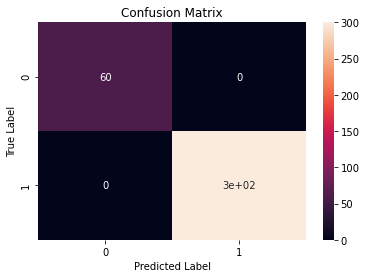

TN = 60 
FP = 0 
FN = 0 
TP = 300


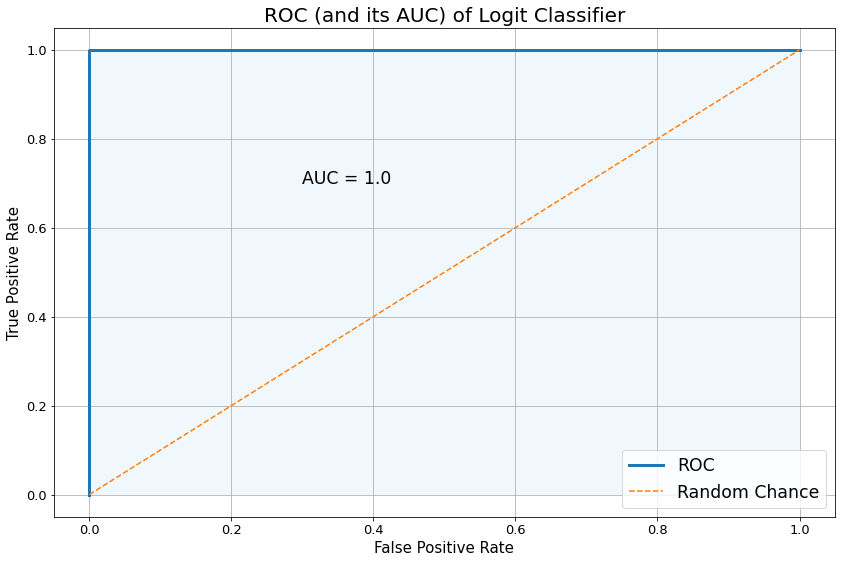

In [21]:

# Report the confusion matrix and show the ROC and AUC for your (new) classifier on testing data.
# Compare the accuracy on the test set with the cross-validation accuracy you obtained previously (in d.iv)

trainTS_os_pruned = trainTS_df_oversampledL[0].copy()

for col in trainTS_os_pruned.columns:
    if (col != "Q3_ts1.") and (col != "max_ts5.") and (col != "Q1_ts5.") and (col != "bending_lbl"):
        trainTS_os_pruned.drop(columns=col, inplace=True)

display(trainTS_os_pruned)

trainY = trainTS_os_pruned["bending_lbl"]
trainX_all = trainTS_os_pruned[["Q3_ts1.", "max_ts5.", "Q1_ts5."]]
# adding an intercept 
trainX_all_const = sm.add_constant(trainX_all, prepend=True)


# Now we train our logit model based on the case-control sampled training set
log_reg_model.fit(trainX_all_const, trainY)
# But now, we predict the labels for the test set

# our log-reg classifier's label predictions for the test set
prediction = log_reg_model.predict(trainX_all_const)
prediction_prob = log_reg_model.predict_proba(trainX_all_const)

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
matrix = confusion_matrix(trainY, prediction.round())
# print(matrix)

# https://seaborn.pydata.org/generated/seaborn.heatmap.html
sns.heatmap(matrix, annot=True)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

matrix_flat = matrix.flatten()
tn = matrix_flat[0]
fp = matrix_flat[1]
fn = matrix_flat[2]
tp = matrix_flat[3]
print("TN =", tn, "\nFP =", fp, "\nFN =", fn, "\nTP =", tp)


#showing the receiver operating characteristic curve (Curve) 

# The second positional paramter of roc takes y_score: probability estimates of the "positive" class
# log_reg_model.predict_proba returns probability of the sample for each class in the model, 
# where classes are ordered as they are in self.classes_ (ie log_reg_model.classes_); here positive is index 1 of each array

# pos_label is the label of the positive class
fpr, tpr, thresh = roc_curve(trainY, prediction_prob[:, 1], pos_label=1)

# area under the ROC curve
auc_val = auc(fpr, tpr)

# setting plot size

fig, ax = plt.subplots(figsize=(14, 9))
# plots the predicitve power (i.e. prob curve) of our classifier
ax.plot(fpr, tpr, label="ROC", linewidth=3)
# plots the predictive power we would expect with random guessing
ax.plot([0, 1], [0, 1], "--", label="Random Chance")
ax.legend(loc="lower right", fontsize="xx-large")
kwargs = {"fc":"xkcd:sky blue", "alpha":0.1}
# The blue shaded region represnts the AOC -- ie it covers 100% of the area under ROC; 
# our classifier get perfect seperation of the classes with a tpr of 100% and a fpr of 0%
ax.fill_between(np.arange(0,1.1,0.2), 1, 0, **kwargs)

plt.grid(True)
plt.text(0.3, 0.7, "AUC = %s" %auc_val, fontsize="xx-large")
plt.tick_params(labelsize=13)
plt.xlabel("False Positive Rate", fontsize=15)
plt.ylabel("True Positive Rate", fontsize=15)
plt.title("ROC (and its AUC) of Logit Classifier", fontsize=20)


plt.show()



In [22]:
# Testing the classifier -- training on our oversampled dataset with pair (1, 3) -- on our test set

# Since 1=1 in our best (l,p) pair, we don't need to break the test set

# creating a labeled testing set
testTS_lbld_df = testTS_df.copy()

num_rows = testTS_df.shape[0]
# print(allTS_df.iloc[85]["folder"])
bending_label = []
for i in range(num_rows):
    if "bending" in testTS_df.iloc[i]["folder"]:
        bending_label.append(1)
    else:
        bending_label.append(0)
testTS_lbld_df["bending_lbl"] = bending_label
# display(testTS_lbld_df)

best_pruned_testTS_df = testTS_lbld_df.copy()

# pruning based on the feature selection with cross validation in d.iii
for col in best_pruned_testTS_df.columns:
    if (col != "Q3₁") and (col != "max₅") and (col != "Q1₅") and (col != "bending_lbl"):
        best_pruned_testTS_df.drop(columns=col, inplace=True)

# display(best_pruned_testTS_df)

testY = best_pruned_testTS_df["bending_lbl"]
testX_all = best_pruned_testTS_df[["Q3₁", "max₅", "Q1₅"]]
# adding an intercept 
testX_all_const = sm.add_constant(testX_all, prepend=True)

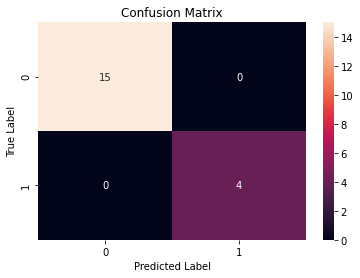

TN = 15 
FP = 0 
FN = 0 
TP = 4


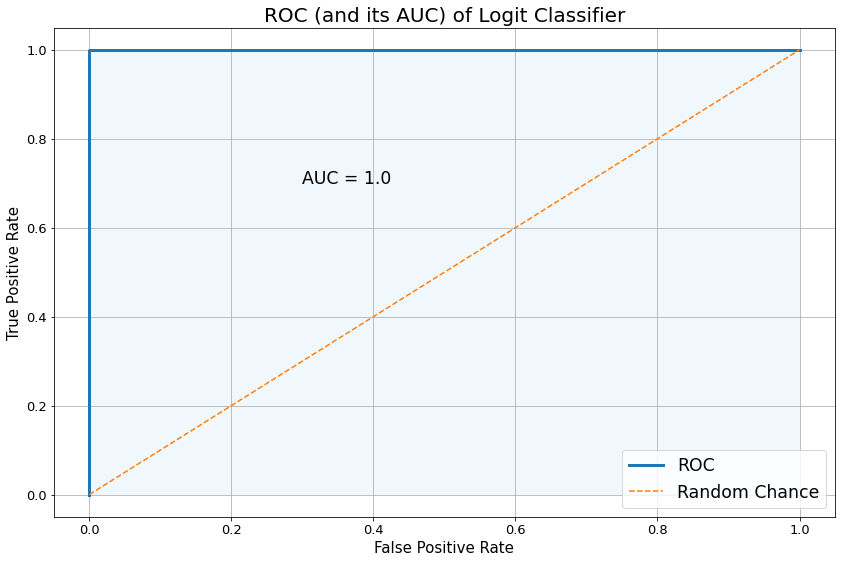

In [23]:
# Report the confusion matrix and show the ROC and AUC for your (new) classifier on testing data.
# Compare the accuracy on the test set with the cross-validation accuracy you obtained previously (in d.iv)

# Now we train our logit model based on the case-control sampled training set
log_reg_model.fit(trainX_all_const, trainY)
# But now, we predict the labels for the test set

# our log-reg classifier's label predictions for the test set
prediction = log_reg_model.predict(testX_all_const)
prediction_prob = log_reg_model.predict_proba(testX_all_const)

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
matrix = confusion_matrix(testY, prediction.round())
# print(matrix)

# https://seaborn.pydata.org/generated/seaborn.heatmap.html
sns.heatmap(matrix, annot=True)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

matrix_flat = matrix.flatten()
tn = matrix_flat[0]
fp = matrix_flat[1]
fn = matrix_flat[2]
tp = matrix_flat[3]
print("TN =", tn, "\nFP =", fp, "\nFN =", fn, "\nTP =", tp)


#showing the receiver operating characteristic curve (Curve) 

# The second positional paramter of roc takes y_score: probability estimates of the "positive" class
# log_reg_model.predict_proba returns probability of the sample for each class in the model, 
# where classes are ordered as they are in self.classes_ (ie log_reg_model.classes_); here positive is index 1 of each array

# pos_label is the label of the positive class
fpr, tpr, thresh = roc_curve(testY, prediction_prob[:, 1], pos_label=1)

# area under the ROC curve
auc_val = auc(fpr, tpr)

# setting plot size

fig, ax = plt.subplots(figsize=(14, 9))
# plots the predicitve power (i.e. prob curve) of our classifier
ax.plot(fpr, tpr, label="ROC", linewidth=3)
# plots the predictive power we would expect with random guessing
ax.plot([0, 1], [0, 1], "--", label="Random Chance")
ax.legend(loc="lower right", fontsize="xx-large")
kwargs = {"fc":"xkcd:sky blue", "alpha":0.1}
# The blue shaded region represnts the AOC -- ie it covers 100% of the area under ROC; 
# our classifier get perfect seperation of the classes with a tpr of 100% and a fpr of 0%
ax.fill_between(np.arange(0,1.1,0.2), 1, 0, **kwargs)

plt.grid(True)
plt.text(0.3, 0.7, "AUC = %s" %auc_val, fontsize="xx-large")
plt.tick_params(labelsize=13)
plt.xlabel("False Positive Rate", fontsize=15)
plt.ylabel("True Positive Rate", fontsize=15)
plt.title("ROC (and its AUC) of Logit Classifier", fontsize=20)


plt.show()



-----------
## 1.e.i
Binary Classification Using L1-penalized logistic regression

Repeat 1(d)iii using L1-penalized logistic regression, i.e. instead of using p- values for variable selection, use L1 regularization. Note that in this problem, you have to cross-validate for both l, the number of time series into which you break each of your instances, and λ, the weight of L1 penalty in your logistic regression objective function (or C, the budget). Packages usually perform cross-validation for λ automatically.

In [24]:

# because of all the computation involved (e.g. for the cross validation), this cell take VERY long to load
# Since it outputs everything at once, it may feel like it froze, but it didn't

# create a master dataframe to store the l, C, mean_CV_score
logit_df = pd.DataFrame(columns = ["l", "C*", "mean_CV_score*"])

splitL = list(range(1, 21, 1))


for split_n in splitL:
    
    stats = ["min_ts", "max_ts", "mean_ts", "median_ts", "Q1_ts", "Q3_ts", "stdev_ts"]
    stat_colL = []

    for i in range(split_n*6):
        for stat in stats:
    #         print(stat+sub)
            stat_colL.append(stat+str(i+1)+".")

    # print(stat_colL)

    stat_colL.insert(0, "file")
    stat_colL.insert(0, "folder")


    trainTS_df_expanded = pd.DataFrame(columns=stat_colL)
    setsT = [(train_set_filesL, trainTS_df_expanded)]

    # It's set up like this incase I need to add a test_set tuple later
    for set_filesL, ts_df in setsT:

    #     ts_df = pd.DataFrame(columns=stat_colL)
        ts_df.index.name = "Instance"

        inst = 0
        # loop through all test dataset "csv" files
        for file in set_filesL:

            file_df = pd.read_csv(file, skiprows=4)

            folder_name = file[13: file.find("/", file.find("/", 13))]
            file_name = file[file.find("/", 13)+1:]

    #         display(file_df)


            # print(file_df.shape[0])
            break_rows = file_df.shape[0]//split_n
            # print(break_rows)
            modulus = file_df.shape[0]%split_n

            break_dfL = []
            for i in range(split_n):
                # I am using this so that the new timeseries is 1,2,3,1.5,2.5,3.5 -- rather than 1,1.5,2,2.5,3,3.5
                # The Piazza TAs said to have such an ordering

                if i+1 <= modulus:
                    # since not all numbers in set l are divisors of 480, we will have some timeseries with 1 more or less rows
                    new_break_rows = break_rows + 1
                    df = file_df[(0+i*new_break_rows):(new_break_rows+i*new_break_rows)]
                else:
                    df = file_df[(modulus+i*break_rows):(modulus+break_rows+i*break_rows)]
    #             break_dfL[i].append(df)
                break_dfL.append(df)


            # extracting domain type features for all time series
            instance_valsL = []
            instance_valsL.append([folder_name])
            instance_valsL.append([file_name])

            for break_df in break_dfL:

                # loop through all (ie 12) time series and add their stats
                for ts_name in list(break_dfL[0].columns)[1:]:

                    df = break_df[ts_name]

                    # statistical attribute values for a single time series
                    attr_valsL = []
                    attr_valsL.append(df.min())
                    attr_valsL.append(df.max())
                    attr_valsL.append(df.mean())
                    attr_valsL.append(df.quantile(.50))
                    attr_valsL.append(df.quantile(.25))
                    attr_valsL.append(df.quantile(.75))
                    attr_valsL.append(df.std())

        #             print(attr_valuesL)

                    instance_valsL.append(attr_valsL)



            # flattening the list to input into single dataframe row
            instance_valsL_flat = [item for sublist in instance_valsL for item in sublist]

            ts_df.loc[0+inst] = instance_valsL_flat
            inst += 1

        ts_df.index +=1

    num_rows = trainTS_df_expanded.shape[0]
    bending_label = []
    for i in range(num_rows):
        if "bending" in trainTS_df_expanded.iloc[i]["folder"]:
            bending_label.append(1)
        else:
            bending_label.append(0)

    # adding the "bending" label column to the dataframe 
    trainTS_df_expanded["bending_lbl"] = bending_label


    # split training set into its features and class variable

    # display(trainTS_df_expanded.iloc[:, 1:-1])
    trainX = trainTS_df_expanded.iloc[:, 2:-1]
    trainY = trainTS_df_expanded.iloc[:, -1]

    # creating the logistic regression classifier and doing feature selection based on the 5-fold cross validation
    # setting penalty to l1 and solver to liblinear per instructions
    log_reg_model = LogisticRegressionCV(penalty="l1", solver="liblinear", cv=5, random_state=1, scoring="accuracy")

    log_reg_model.fit(trainX, trainY)
    
    # Find the index of the best C for current value of L
    bestC = log_reg_model.C_
    bestC_ind = list(log_reg_model.Cs_).index(bestC)

    # Calculate the mean_CV_score for each value of C from scores_ attribute of the classifier
    # default C iterations is 10
    mean_cv_scoreL = [[], [], [], [], [], [], [], [], [], []]

    # it is an array of 5 cross validation arrays, each with the 10 C iterations values
    CV_Cs = log_reg_model.scores_[1]
    
    for fold in CV_Cs:
        for i in range(len(fold)):      
            mean_cv_scoreL[i].append(list(fold)[i])
            
    mean_cv_scoreL = [round(statistics.mean(c_list), 4) for c_list in mean_cv_scoreL]
#     print(mean_cv_scoreL)
        
    # Use the index found in step 1 to get the mean CV score of the best C
    bestC_mean_CVscore = mean_cv_scoreL[bestC_ind]
    
    # Add a row with l , C and mean_CV_score to a master dataframe.
    logit_df = logit_df.append({"l":split_n, "C*":np.around(bestC, 4)[0], "mean_CV_score*":bestC_mean_CVscore}, ignore_index=True)
#     inst += 1
    

    # Couldn't figure out why without this it wouldn't load
    if split_n == 20:
        break

display(logit_df)


l         C*  mean_CV_score*
0    1.0     2.7826          0.9571
1    2.0     0.3594          0.9429
2    3.0     0.3594          0.9429
3    4.0     0.3594          0.9429
4    5.0     0.3594          0.9429
5    6.0     0.3594          0.9429
6    7.0  1291.5497          0.9571
7    8.0     2.7826          0.9571
8    9.0     0.3594          0.9571
9   10.0     2.7826          0.9571
10  11.0     0.3594          0.9571
11  12.0     0.3594          0.9714
12  13.0     2.7826          0.9571
13  14.0     0.3594          0.9571
14  15.0     0.3594          0.9429
15  16.0     0.3594          0.9429
16  17.0     0.3594          0.9429
17  18.0     0.0464          0.9429
18  19.0     0.3594          0.9571
19  20.0     2.7826          0.9714

>As we see in the table above, the best model will have an (~ accuracy) score of 0.9714, at l=20 and its C* = 2.7826.

-----------
## 1.e.ii
Binary Classification Using L1-penalized logistic regression

Compare the L1-penalized with variable selection using p-values. Which one performs better? Which one is easier to implement?

>By comparing the resulting in e.i and d.iii, it would seem that the variable selection using the p-values of the best (l, p) pair from stratified cross validation performed better than the L1-penalized method. The best (accuracy) score with the d.ii method -- using p-values -- was 1, whereas the best score with the L1 penalized model was only 0.9714. <br>
>Also, I would imagine the p-values approach to be easier to impliment since for L1 penalized we had to cross-validate for both the "l"s and "C"s, making it more computationally heavy.

-----------
## 1.f.i
Multi-class Classification (The Realistic Case)

Find the best l in the same way as you found it in 1(e)i to build an L1- penalized multinomial regression model to classify all activities in your train- ing set. Report your test error. Research how confusion matrices and ROC curves are defined for multiclass classification and show them for this problem
if possible.

In [25]:

trainTS_multi_df = trainTS_df.copy()
testTS_multi_df = testTS_df.copy()
# display(allTS_lbld_df)

for set_df, set_multi_df in [(trainTS_df, trainTS_multi_df), (testTS_df, testTS_multi_df)]:
    num_rows = set_df.shape[0]
    # print(allTS_df.iloc[85]["folder"])
    label = []
    for i in range(num_rows):
        if "bending" in set_df.iloc[i]["folder"]:
            label.append("bending")
        else:
            label.append(set_df.iloc[i]["folder"])

    # adding the "bending" label column to the dataframe 
    set_multi_df["label"] = label


In [26]:

splitL = list(range(1, 21, 1))


for split_n in splitL:
    
    stats = ["min_ts", "max_ts", "mean_ts", "median_ts", "Q1_ts", "Q3_ts", "stdev_ts"]
    stat_colL = []

    for i in range(split_n*6):
        for stat in stats:
    #         print(stat+sub)
            stat_colL.append(stat+str(i+1)+".")

    # print(stat_colL)

    stat_colL.insert(0, "file")
    stat_colL.insert(0, "folder")


    trainTS_df_expanded = pd.DataFrame(columns=stat_colL)
    testTS_df_expanded = pd.DataFrame(columns=stat_colL)
    setsT = [(train_set_filesL, trainTS_df_expanded), (test_set_filesL, testTS_df_expanded)]

    # It's set up like this incase I need to add a test_set tuple later
    for set_filesL, ts_df in setsT:

    #     ts_df = pd.DataFrame(columns=stat_colL)
        ts_df.index.name = "Instance"

        inst = 0
        # loop through all test dataset "csv" files
        for file in set_filesL:

            file_df = pd.read_csv(file, skiprows=4)

            folder_name = file[13: file.find("/", file.find("/", 13))]
            file_name = file[file.find("/", 13)+1:]


            break_rows = file_df.shape[0]//split_n
            # print(break_rows)
            modulus = file_df.shape[0]%split_n

            break_dfL = []
            for i in range(split_n):
                # I am using this so that the new timeseries is 1,2,3,1.5,2.5,3.5 -- rather than 1,1.5,2,2.5,3,3.5
                # The Piazza TAs said to have such an ordering

                if i+1 <= modulus:
                    # since not all numbers in set l are divisors of 480, we will have some timeseries with 1 more or less rows
                    new_break_rows = break_rows + 1
                    df = file_df[(0+i*new_break_rows):(new_break_rows+i*new_break_rows)]
                else:
                    df = file_df[(modulus+i*break_rows):(modulus+break_rows+i*break_rows)]
                break_dfL.append(df)

            # extracting domain type features for all time series
            instance_valsL = []
            instance_valsL.append([folder_name])
            instance_valsL.append([file_name])

            for break_df in break_dfL:

                # loop through all (ie 12) time series and add their stats
                for ts_name in list(break_dfL[0].columns)[1:]:

                    df = break_df[ts_name]

                    # statistical attribute values for a single time series
                    attr_valsL = []
                    attr_valsL.append(df.min())
                    attr_valsL.append(df.max())
                    attr_valsL.append(df.mean())
                    attr_valsL.append(df.quantile(.50))
                    attr_valsL.append(df.quantile(.25))
                    attr_valsL.append(df.quantile(.75))
                    attr_valsL.append(df.std())

                    instance_valsL.append(attr_valsL)


            # flattening the list to input into single dataframe row
            instance_valsL_flat = [item for sublist in instance_valsL for item in sublist]

            ts_df.loc[0+inst] = instance_valsL_flat
            inst += 1

        ts_df.index +=1
    
    trainTS_mult_df = trainTS_df_expanded.copy()
    testTS_mult_df = testTS_df_expanded.copy()
    # display(allTS_lbld_df)

    for set_df, set_mult_df in [(trainTS_df, trainTS_mult_df), (testTS_df, testTS_mult_df)]:
        num_rows = set_df.shape[0]
        # print(allTS_df.iloc[85]["folder"])
        label = []
        for i in range(num_rows):
            if "bending" in set_df.iloc[i]["folder"]:
                label.append("bending")
            else:
                label.append(set_df.iloc[i]["folder"])

        # adding the "bending" label column to the dataframe 
        set_mult_df["label"] = label
    

    # split training set into its features and class variable

    # display(trainTS_df_expanded.iloc[:, 1:-1])
    trainX = trainTS_mult_df.iloc[:, 2:-1]
    trainY = trainTS_mult_df.iloc[:, -1]
    testX = testTS_mult_df.iloc[:, 2:-1]
    testY = testTS_mult_df.iloc[:, -1]

    
    # creating the logistic regression classifier and doing feature selection based on the 5-fold cross validation
    # setting penalty to l1 and solver to a type that can accomodate multi-class computation and l1
    log_reg_model = LogisticRegressionCV(penalty="l1", solver="saga", cv=5, random_state=7, scoring="accuracy", multi_class="multinomial")
    
    log_reg_model.fit(trainX, trainY)
    

    filterwarnings('ignore')
    
    test_score = log_reg_model.score(testX, testY)
    print("Testing (accuracy) score -- with l =", split_n, "-- is", round(test_score, 4))
    


Testing (accuracy) score -- with l = 1 -- is 0.8947
Testing (accuracy) score -- with l = 2 -- is 0.8947
Testing (accuracy) score -- with l = 3 -- is 0.8947
Testing (accuracy) score -- with l = 4 -- is 0.8947
Testing (accuracy) score -- with l = 5 -- is 0.8947
Testing (accuracy) score -- with l = 6 -- is 0.8421
Testing (accuracy) score -- with l = 7 -- is 0.8421
Testing (accuracy) score -- with l = 8 -- is 0.8421
Testing (accuracy) score -- with l = 9 -- is 0.8421
Testing (accuracy) score -- with l = 10 -- is 0.8947
Testing (accuracy) score -- with l = 11 -- is 0.8947
Testing (accuracy) score -- with l = 12 -- is 0.8421
Testing (accuracy) score -- with l = 13 -- is 0.8947
Testing (accuracy) score -- with l = 14 -- is 0.8947
Testing (accuracy) score -- with l = 15 -- is 0.8421
Testing (accuracy) score -- with l = 16 -- is 0.8947
Testing (accuracy) score -- with l = 17 -- is 0.8421
Testing (accuracy) score -- with l = 18 -- is 0.8421
Testing (accuracy) score -- with l = 19 -- is 0.8421
Te

In [27]:
split_n = 1

stats = ["min_ts", "max_ts", "mean_ts", "median_ts", "Q1_ts", "Q3_ts", "stdev_ts"]
stat_colL = []

for i in range(split_n*6):
    for stat in stats:
#         print(stat+sub)
        stat_colL.append(stat+str(i+1)+".")

# print(stat_colL)

stat_colL.insert(0, "file")
stat_colL.insert(0, "folder")


trainTS_df_expanded = pd.DataFrame(columns=stat_colL)
testTS_df_expanded = pd.DataFrame(columns=stat_colL)
setsT = [(train_set_filesL, trainTS_df_expanded), (test_set_filesL, testTS_df_expanded)]

# It's set up like this incase I need to add a test_set tuple later
for set_filesL, ts_df in setsT:

#     ts_df = pd.DataFrame(columns=stat_colL)
    ts_df.index.name = "Instance"

    inst = 0
    # loop through all test dataset "csv" files
    for file in set_filesL:

        file_df = pd.read_csv(file, skiprows=4)

    #     print(file)
    #     file_name = file[file.find("AReM/")]
        # "/" after "AReM" is at index 12
        folder_name = file[13: file.find("/", file.find("/", 13))]
        file_name = file[file.find("/", 13)+1:]

#         display(file_df)


        # print(file_df.shape[0])
        break_rows = file_df.shape[0]//split_n
        # print(break_rows)
        modulus = file_df.shape[0]%split_n

        break_dfL = []
        for i in range(split_n):
            # I am using this so that the new timeseries is 1,2,3,1.5,2.5,3.5 -- rather than 1,1.5,2,2.5,3,3.5
            # The Piazza TAs said to have such an ordering

            if i+1 <= modulus:
                # since not all numbers in set l are divisors of 480, we will have some timeseries with 1 more or less rows
                new_break_rows = break_rows + 1
                df = file_df[(0+i*new_break_rows):(new_break_rows+i*new_break_rows)]
            else:
                df = file_df[(modulus+i*break_rows):(modulus+break_rows+i*break_rows)]
#             break_dfL[i].append(df)
            break_dfL.append(df)


        # extracting domain type features for all time series
        instance_valsL = []
        instance_valsL.append([folder_name])
        instance_valsL.append([file_name])

        for break_df in break_dfL:

            # loop through all (ie 12) time series and add their stats
            for ts_name in list(break_dfL[0].columns)[1:]:

                df = break_df[ts_name]

                # statistical attribute values for a single time series
                attr_valsL = []
                attr_valsL.append(df.min())
                attr_valsL.append(df.max())
                attr_valsL.append(df.mean())
                attr_valsL.append(df.quantile(.50))
                attr_valsL.append(df.quantile(.25))
                attr_valsL.append(df.quantile(.75))
                attr_valsL.append(df.std())

    #             print(attr_valuesL)

                instance_valsL.append(attr_valsL)



        # flattening the list to input into single dataframe row
        instance_valsL_flat = [item for sublist in instance_valsL for item in sublist]

        ts_df.loc[0+inst] = instance_valsL_flat
        inst += 1

    ts_df.index +=1

#     print(trainTS_df_expanded.shape)
trainTS_mult_df = trainTS_df_expanded.copy()
testTS_mult_df = testTS_df_expanded.copy()
# display(allTS_lbld_df)

for set_df, set_mult_df in [(trainTS_df, trainTS_mult_df), (testTS_df, testTS_mult_df)]:
    num_rows = set_df.shape[0]
    # print(allTS_df.iloc[85]["folder"])
    label = []
    for i in range(num_rows):
        if "bending" in set_df.iloc[i]["folder"]:
            label.append("bending")
        else:
            label.append(set_df.iloc[i]["folder"])

    # adding the "bending" label column to the dataframe 
    set_mult_df["label"] = label


# split training set into its features and class variable

# display(trainTS_df_expanded.iloc[:, 1:-1])
trainX = trainTS_mult_df.iloc[:, 2:-1]
trainY = trainTS_mult_df.iloc[:, -1]
testX = testTS_mult_df.iloc[:, 2:-1]
testY = testTS_mult_df.iloc[:, -1]


# creating the logistic regression classifier and doing feature selection based on the 5-fold cross validation
# setting penalty to l1 and solver to a type that can accomodate multi-class computation and l1
log_reg_model = LogisticRegressionCV(penalty="l1", solver="saga", cv=5, random_state=7, scoring="accuracy", multi_class="multinomial")

#     display(trainY)
log_reg_model.fit(trainX, trainY)


prediction = log_reg_model.predict(testX)
matrix = confusion_matrix(testY, prediction)
print("Multi-class Confusion Matrix (with test set)")
print((matrix))


Multi-class Confusion Matrix (with test set)
[[3 1 0 0 0 0]
 [0 3 0 0 0 0]
 [0 0 3 0 0 0]
 [0 0 0 3 0 0]
 [0 0 1 0 2 0]
 [0 0 0 0 0 3]]


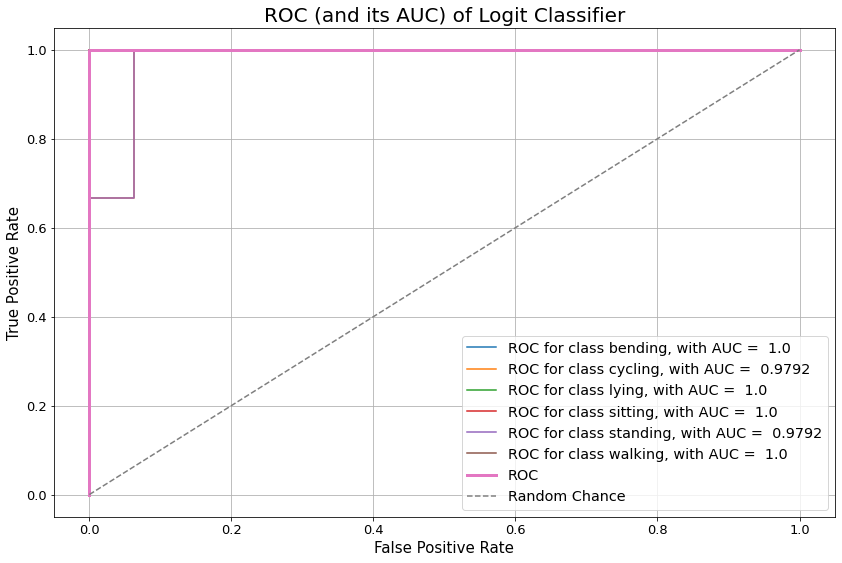

In [28]:
# roc and auc

prediction_prob = log_reg_model.predict_proba(testX)

fig, ax = plt.subplots(figsize=(14, 9))

for i, label in enumerate(log_reg_model.classes_):
    fpr, tpr, thresh = roc_curve(testY, prediction_prob[:, i], pos_label=label)
    auc_val = auc(fpr, tpr)
    ax.plot(fpr, tpr, label="ROC for class %s, with AUC =  %s" %(str(label), str(round(auc_val, 4))))



# plots the predicitve power (i.e. prob curve) of our classifier
ax.plot(fpr, tpr, label="ROC", linewidth=3)
# plots the predictive power we would expect with random guessing
ax.plot([0, 1], [0, 1], "--", label="Random Chance")
ax.legend(loc="lower right", fontsize="x-large")

plt.grid(True)
plt.tick_params(labelsize=13)
plt.xlabel("False Positive Rate", fontsize=15)
plt.ylabel("True Positive Rate", fontsize=15)
plt.title("ROC (and its AUC) of Logit Classifier", fontsize=20)

plt.show()



-----------
## 1.f.ii
Multi-class Classification (The Realistic Case)

Repeat 1(f)i using a Na ̈ıve Bayes’ classifier. Use both Gaussian and Multinomial priors and compare the results.

In [29]:
# https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html

# using guassian naive bayer classifier

splitL = list(range(1, 21, 1))


for split_n in splitL:
    
    stats = ["min_ts", "max_ts", "mean_ts", "median_ts", "Q1_ts", "Q3_ts", "stdev_ts"]
    stat_colL = []

    for i in range(split_n*6):
        for stat in stats:
            stat_colL.append(stat+str(i+1)+".")

    stat_colL.insert(0, "file")
    stat_colL.insert(0, "folder")


    trainTS_df_expanded = pd.DataFrame(columns=stat_colL)
    testTS_df_expanded = pd.DataFrame(columns=stat_colL)
    setsT = [(train_set_filesL, trainTS_df_expanded), (test_set_filesL, testTS_df_expanded)]

    for set_filesL, ts_df in setsT:
        ts_df.index.name = "Instance"

        inst = 0
        # loop through all test dataset "csv" files
        for file in set_filesL:

            file_df = pd.read_csv(file, skiprows=4)

        #     print(file)
        #     file_name = file[file.find("AReM/")]
            # "/" after "AReM" is at index 12
            folder_name = file[13: file.find("/", file.find("/", 13))]
            file_name = file[file.find("/", 13)+1:]

    #         display(file_df)


            # print(file_df.shape[0])
            break_rows = file_df.shape[0]//split_n
            # print(break_rows)
            modulus = file_df.shape[0]%split_n

            break_dfL = []
            for i in range(split_n):
                if i+1 <= modulus:
                    # since not all numbers in set l are divisors of 480, we will have some timeseries with 1 more or less rows
                    new_break_rows = break_rows + 1
                    df = file_df[(0+i*new_break_rows):(new_break_rows+i*new_break_rows)]
                else:
                    df = file_df[(modulus+i*break_rows):(modulus+break_rows+i*break_rows)]
    #             break_dfL[i].append(df)
                break_dfL.append(df)

            # extracting domain type features for all time series
            instance_valsL = []
            instance_valsL.append([folder_name])
            instance_valsL.append([file_name])

            for break_df in break_dfL:

                # loop through all (ie 12) time series and add their stats
                for ts_name in list(break_dfL[0].columns)[1:]:

                    df = break_df[ts_name]

                    # statistical attribute values for a single time series
                    attr_valsL = []
                    attr_valsL.append(df.min())
                    attr_valsL.append(df.max())
                    attr_valsL.append(df.mean())
                    attr_valsL.append(df.quantile(.50))
                    attr_valsL.append(df.quantile(.25))
                    attr_valsL.append(df.quantile(.75))
                    attr_valsL.append(df.std())

        #             print(attr_valuesL)

                    instance_valsL.append(attr_valsL)



            # flattening the list to input into single dataframe row
            instance_valsL_flat = [item for sublist in instance_valsL for item in sublist]

            ts_df.loc[0+inst] = instance_valsL_flat
            inst += 1

        ts_df.index +=1
    
    trainTS_mult_df = trainTS_df_expanded.copy()
    testTS_mult_df = testTS_df_expanded.copy()
    # display(allTS_lbld_df)

    for set_df, set_mult_df in [(trainTS_df, trainTS_mult_df), (testTS_df, testTS_mult_df)]:
        num_rows = set_df.shape[0]
        # print(allTS_df.iloc[85]["folder"])
        label = []
        for i in range(num_rows):
            if "bending" in set_df.iloc[i]["folder"]:
                label.append("bending")
            else:
                label.append(set_df.iloc[i]["folder"])

        # adding the "bending" label column to the dataframe 
        set_mult_df["label"] = label
    

    # split training set into its features and class variable

    # display(trainTS_df_expanded.iloc[:, 1:-1])
    trainX = trainTS_mult_df.iloc[:, 2:-1]
    trainY = trainTS_mult_df.iloc[:, -1]
    testX = testTS_mult_df.iloc[:, 2:-1]
    testY = testTS_mult_df.iloc[:, -1]

    
    # creating the logistic regression classifier and doing feature selection based on the 5-fold cross validation
    # setting penalty to l1 and solver to a type that can accomodate multi-class computation and l1
    gauss_model = GaussianNB()
    
#     display(trainY)
    gauss_model.fit(trainX, trainY)
    
    filterwarnings('ignore')
    
    test_score = gauss_model.score(testX, testY)
    print("Gaussian NB Classifier Testing (accuracy) score -- with l =", split_n, "-- is", round(test_score, 4))
    


Gaussian NB Classifier Testing (accuracy) score -- with l = 1 -- is 0.8947
Gaussian NB Classifier Testing (accuracy) score -- with l = 2 -- is 0.8421
Gaussian NB Classifier Testing (accuracy) score -- with l = 3 -- is 0.7895
Gaussian NB Classifier Testing (accuracy) score -- with l = 4 -- is 0.8947
Gaussian NB Classifier Testing (accuracy) score -- with l = 5 -- is 0.8947
Gaussian NB Classifier Testing (accuracy) score -- with l = 6 -- is 0.7895
Gaussian NB Classifier Testing (accuracy) score -- with l = 7 -- is 0.7895
Gaussian NB Classifier Testing (accuracy) score -- with l = 8 -- is 0.7895
Gaussian NB Classifier Testing (accuracy) score -- with l = 9 -- is 0.8421
Gaussian NB Classifier Testing (accuracy) score -- with l = 10 -- is 0.8421
Gaussian NB Classifier Testing (accuracy) score -- with l = 11 -- is 0.6316
Gaussian NB Classifier Testing (accuracy) score -- with l = 12 -- is 0.7368
Gaussian NB Classifier Testing (accuracy) score -- with l = 13 -- is 0.6842
Gaussian NB Classifie

In [30]:
split_n = 1

stats = ["min_ts", "max_ts", "mean_ts", "median_ts", "Q1_ts", "Q3_ts", "stdev_ts"]
stat_colL = []

for i in range(split_n*6):
    for stat in stats:
#         print(stat+sub)
        stat_colL.append(stat+str(i+1)+".")

# print(stat_colL)

stat_colL.insert(0, "file")
stat_colL.insert(0, "folder")


trainTS_df_expanded = pd.DataFrame(columns=stat_colL)
testTS_df_expanded = pd.DataFrame(columns=stat_colL)
setsT = [(train_set_filesL, trainTS_df_expanded), (test_set_filesL, testTS_df_expanded)]

for set_filesL, ts_df in setsT:

#     ts_df = pd.DataFrame(columns=stat_colL)
    ts_df.index.name = "Instance"

    inst = 0
    # loop through all test dataset "csv" files
    for file in set_filesL:

        file_df = pd.read_csv(file, skiprows=4)

        folder_name = file[13: file.find("/", file.find("/", 13))]
        file_name = file[file.find("/", 13)+1:]

#         display(file_df)


        # print(file_df.shape[0])
        break_rows = file_df.shape[0]//split_n
        # print(break_rows)
        modulus = file_df.shape[0]%split_n

        break_dfL = []
        for i in range(split_n):
            # I am using this so that the new timeseries is 1,2,3,1.5,2.5,3.5 -- rather than 1,1.5,2,2.5,3,3.5

            if i+1 <= modulus:
                # since not all numbers in set l are divisors of 480, we will have some timeseries with 1 more or less rows
                new_break_rows = break_rows + 1
                df = file_df[(0+i*new_break_rows):(new_break_rows+i*new_break_rows)]
            else:
                df = file_df[(modulus+i*break_rows):(modulus+break_rows+i*break_rows)]
#             break_dfL[i].append(df)
            break_dfL.append(df)

        # extracting domain type features for all time series
        instance_valsL = []
        instance_valsL.append([folder_name])
        instance_valsL.append([file_name])

        for break_df in break_dfL:

            # loop through all (ie 12) time series and add their stats
            for ts_name in list(break_dfL[0].columns)[1:]:

                df = break_df[ts_name]

                # statistical attribute values for a single time series
                attr_valsL = []
                attr_valsL.append(df.min())
                attr_valsL.append(df.max())
                attr_valsL.append(df.mean())
                attr_valsL.append(df.quantile(.50))
                attr_valsL.append(df.quantile(.25))
                attr_valsL.append(df.quantile(.75))
                attr_valsL.append(df.std())

                instance_valsL.append(attr_valsL)


        # flattening the list to input into single dataframe row
        instance_valsL_flat = [item for sublist in instance_valsL for item in sublist]

        ts_df.loc[0+inst] = instance_valsL_flat
        inst += 1

    ts_df.index +=1

#     print(trainTS_df_expanded.shape)
trainTS_mult_df = trainTS_df_expanded.copy()
testTS_mult_df = testTS_df_expanded.copy()
# display(allTS_lbld_df)

for set_df, set_mult_df in [(trainTS_df, trainTS_mult_df), (testTS_df, testTS_mult_df)]:
    num_rows = set_df.shape[0]
    # print(allTS_df.iloc[85]["folder"])
    label = []
    for i in range(num_rows):
        if "bending" in set_df.iloc[i]["folder"]:
            label.append("bending")
        else:
            label.append(set_df.iloc[i]["folder"])

    # adding the "bending" label column to the dataframe 
    set_mult_df["label"] = label


# split training set into its features and class variable

# display(trainTS_df_expanded.iloc[:, 1:-1])
trainX = trainTS_mult_df.iloc[:, 2:-1]
trainY = trainTS_mult_df.iloc[:, -1]
testX = testTS_mult_df.iloc[:, 2:-1]
testY = testTS_mult_df.iloc[:, -1]


gauss_model = GaussianNB()
gauss_model.fit(trainX, trainY)


prediction = gauss_model.predict(testX)
matrix = confusion_matrix(testY, prediction)
print("Multi-class Confusion Matrix (with test set)")
print((matrix))


Multi-class Confusion Matrix (with test set)
[[4 0 0 0 0 0]
 [0 3 0 0 0 0]
 [1 0 2 0 0 0]
 [0 0 0 3 0 0]
 [0 0 0 1 2 0]
 [0 0 0 0 0 3]]


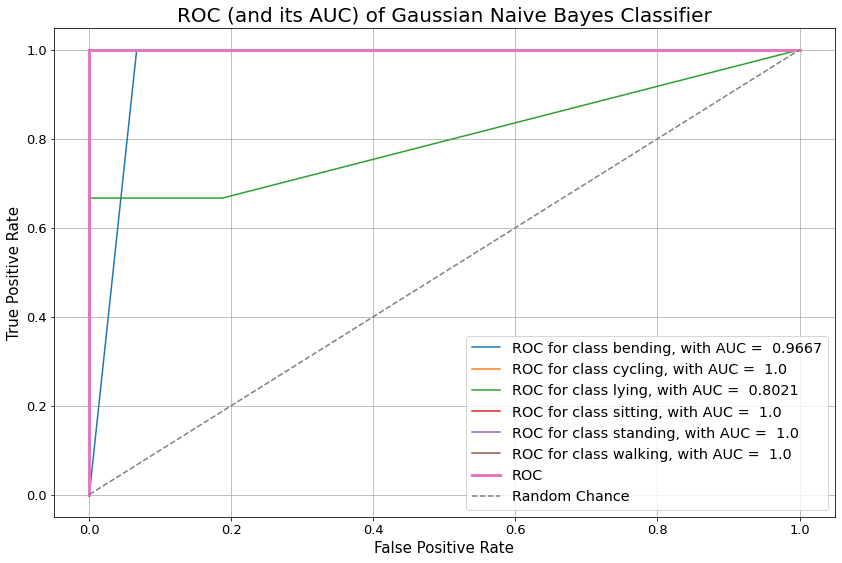

In [31]:
# roc and auc

prediction_prob = gauss_model.predict_proba(testX)

fig, ax = plt.subplots(figsize=(14, 9))

for i, label in enumerate(gauss_model.classes_):
    fpr, tpr, thresh = roc_curve(testY, prediction_prob[:, i], pos_label=label)
    auc_val = auc(fpr, tpr)
    ax.plot(fpr, tpr, label="ROC for class %s, with AUC =  %s" %(str(label), str(round(auc_val, 4))))




# plots the predicitve power (i.e. prob curve) of our classifier
ax.plot(fpr, tpr, label="ROC", linewidth=3)
# plots the predictive power we would expect with random guessing
ax.plot([0, 1], [0, 1], "--", label="Random Chance")
ax.legend(loc="lower right", fontsize="x-large")

plt.grid(True)
plt.tick_params(labelsize=13)
plt.xlabel("False Positive Rate", fontsize=15)
plt.ylabel("True Positive Rate", fontsize=15)
plt.title("ROC (and its AUC) of Gaussian Naive Bayes Classifier", fontsize=20)

plt.show()



In [32]:
# sklearn.naive_bayes.MultinomialNB

# using multinomial naive bayer classifier

splitL = list(range(1, 21, 1))


for split_n in splitL:
    
    stats = ["min_ts", "max_ts", "mean_ts", "median_ts", "Q1_ts", "Q3_ts", "stdev_ts"]
    stat_colL = []

    for i in range(split_n*6):
        for stat in stats:
    #         print(stat+sub)
            stat_colL.append(stat+str(i+1)+".")

    # print(stat_colL)

    stat_colL.insert(0, "file")
    stat_colL.insert(0, "folder")


    trainTS_df_expanded = pd.DataFrame(columns=stat_colL)
    testTS_df_expanded = pd.DataFrame(columns=stat_colL)
    setsT = [(train_set_filesL, trainTS_df_expanded), (test_set_filesL, testTS_df_expanded)]

    # It's set up like this incase I need to add a test_set tuple later
    for set_filesL, ts_df in setsT:

    #     ts_df = pd.DataFrame(columns=stat_colL)
        ts_df.index.name = "Instance"

        inst = 0
        # loop through all test dataset "csv" files
        for file in set_filesL:

            file_df = pd.read_csv(file, skiprows=4)

            folder_name = file[13: file.find("/", file.find("/", 13))]
            file_name = file[file.find("/", 13)+1:]


            break_rows = file_df.shape[0]//split_n
            # print(break_rows)
            modulus = file_df.shape[0]%split_n

            break_dfL = []
            for i in range(split_n):
                # I am using this so that the new timeseries is 1,2,3,1.5,2.5,3.5 -- rather than 1,1.5,2,2.5,3,3.5

                if i+1 <= modulus:
                    # since not all numbers in set l are divisors of 480, we will have some timeseries with 1 more or less rows
                    new_break_rows = break_rows + 1
                    df = file_df[(0+i*new_break_rows):(new_break_rows+i*new_break_rows)]
                else:
                    df = file_df[(modulus+i*break_rows):(modulus+break_rows+i*break_rows)]
    #             break_dfL[i].append(df)
                break_dfL.append(df)

            # extracting domain type features for all time series
            instance_valsL = []
            instance_valsL.append([folder_name])
            instance_valsL.append([file_name])

            for break_df in break_dfL:

                # loop through all (ie 12) time series and add their stats
                for ts_name in list(break_dfL[0].columns)[1:]:

                    df = break_df[ts_name]

                    # statistical attribute values for a single time series
                    attr_valsL = []
                    attr_valsL.append(df.min())
                    attr_valsL.append(df.max())
                    attr_valsL.append(df.mean())
                    attr_valsL.append(df.quantile(.50))
                    attr_valsL.append(df.quantile(.25))
                    attr_valsL.append(df.quantile(.75))
                    attr_valsL.append(df.std())

                    instance_valsL.append(attr_valsL)

            # flattening the list to input into single dataframe row
            instance_valsL_flat = [item for sublist in instance_valsL for item in sublist]

            ts_df.loc[0+inst] = instance_valsL_flat
            inst += 1

        ts_df.index +=1
    
    trainTS_mult_df = trainTS_df_expanded.copy()
    testTS_mult_df = testTS_df_expanded.copy()
    # display(allTS_lbld_df)

    for set_df, set_mult_df in [(trainTS_df, trainTS_mult_df), (testTS_df, testTS_mult_df)]:
        num_rows = set_df.shape[0]
        # print(allTS_df.iloc[85]["folder"])
        label = []
        for i in range(num_rows):
            if "bending" in set_df.iloc[i]["folder"]:
                label.append("bending")
            else:
                label.append(set_df.iloc[i]["folder"])

        # adding the "bending" label column to the dataframe 
        set_mult_df["label"] = label
    

    # split training set into its features and class variable

    # display(trainTS_df_expanded.iloc[:, 1:-1])
    trainX = trainTS_mult_df.iloc[:, 2:-1]
    trainY = trainTS_mult_df.iloc[:, -1]
    testX = testTS_mult_df.iloc[:, 2:-1]
    testY = testTS_mult_df.iloc[:, -1]

    
    multinom_model = MultinomialNB()
    multinom_model.fit(trainX, trainY)
    
    filterwarnings('ignore')
    
    test_score = multinom_model.score(testX, testY)
    print("Multinomial NB Classifier Testing (accuracy) score -- with l =", split_n, "-- is", round(test_score, 4))



Multinomial NB Classifier Testing (accuracy) score -- with l = 1 -- is 0.8947
Multinomial NB Classifier Testing (accuracy) score -- with l = 2 -- is 0.8421
Multinomial NB Classifier Testing (accuracy) score -- with l = 3 -- is 0.8421
Multinomial NB Classifier Testing (accuracy) score -- with l = 4 -- is 0.8421
Multinomial NB Classifier Testing (accuracy) score -- with l = 5 -- is 0.8421
Multinomial NB Classifier Testing (accuracy) score -- with l = 6 -- is 0.8421
Multinomial NB Classifier Testing (accuracy) score -- with l = 7 -- is 0.8421
Multinomial NB Classifier Testing (accuracy) score -- with l = 8 -- is 0.8421
Multinomial NB Classifier Testing (accuracy) score -- with l = 9 -- is 0.8421
Multinomial NB Classifier Testing (accuracy) score -- with l = 10 -- is 0.8421
Multinomial NB Classifier Testing (accuracy) score -- with l = 11 -- is 0.9474
Multinomial NB Classifier Testing (accuracy) score -- with l = 12 -- is 0.8421
Multinomial NB Classifier Testing (accuracy) score -- with l 

In [33]:
split_n = 11

stats = ["min_ts", "max_ts", "mean_ts", "median_ts", "Q1_ts", "Q3_ts", "stdev_ts"]
stat_colL = []

for i in range(split_n*6):
    for stat in stats:
#         print(stat+sub)
        stat_colL.append(stat+str(i+1)+".")


stat_colL.insert(0, "file")
stat_colL.insert(0, "folder")


trainTS_df_expanded = pd.DataFrame(columns=stat_colL)
testTS_df_expanded = pd.DataFrame(columns=stat_colL)
setsT = [(train_set_filesL, trainTS_df_expanded), (test_set_filesL, testTS_df_expanded)]

# It's set up like this incase I need to add a test_set tuple later
for set_filesL, ts_df in setsT:

#     ts_df = pd.DataFrame(columns=stat_colL)
    ts_df.index.name = "Instance"

    inst = 0
    # loop through all test dataset "csv" files
    for file in set_filesL:

        file_df = pd.read_csv(file, skiprows=4)

        folder_name = file[13: file.find("/", file.find("/", 13))]
        file_name = file[file.find("/", 13)+1:]

#         display(file_df)


        # print(file_df.shape[0])
        break_rows = file_df.shape[0]//split_n
        # print(break_rows)
        modulus = file_df.shape[0]%split_n

        break_dfL = []
        for i in range(split_n):

            if i+1 <= modulus:
                # since not all numbers in set l are divisors of 480, we will have some timeseries with 1 more or less rows
                new_break_rows = break_rows + 1
                df = file_df[(0+i*new_break_rows):(new_break_rows+i*new_break_rows)]
            else:
                df = file_df[(modulus+i*break_rows):(modulus+break_rows+i*break_rows)]
            break_dfL.append(df)

        instance_valsL = []
        instance_valsL.append([folder_name])
        instance_valsL.append([file_name])

        for break_df in break_dfL:

            # loop through all (ie 12) time series and add their stats
            for ts_name in list(break_dfL[0].columns)[1:]:

                df = break_df[ts_name]

                # statistical attribute values for a single time series
                attr_valsL = []
                attr_valsL.append(df.min())
                attr_valsL.append(df.max())
                attr_valsL.append(df.mean())
                attr_valsL.append(df.quantile(.50))
                attr_valsL.append(df.quantile(.25))
                attr_valsL.append(df.quantile(.75))
                attr_valsL.append(df.std())

                instance_valsL.append(attr_valsL)


        # flattening the list to input into single dataframe row
        instance_valsL_flat = [item for sublist in instance_valsL for item in sublist]

        ts_df.loc[0+inst] = instance_valsL_flat
        inst += 1

    ts_df.index +=1

trainTS_mult_df = trainTS_df_expanded.copy()
testTS_mult_df = testTS_df_expanded.copy()
# display(allTS_lbld_df)

for set_df, set_mult_df in [(trainTS_df, trainTS_mult_df), (testTS_df, testTS_mult_df)]:
    num_rows = set_df.shape[0]
    # print(allTS_df.iloc[85]["folder"])
    label = []
    for i in range(num_rows):
        if "bending" in set_df.iloc[i]["folder"]:
            label.append("bending")
        else:
            label.append(set_df.iloc[i]["folder"])

    # adding the "bending" label column to the dataframe 
    set_mult_df["label"] = label


# split training set into its features and class variable

# display(trainTS_df_expanded.iloc[:, 1:-1])
trainX = trainTS_mult_df.iloc[:, 2:-1]
trainY = trainTS_mult_df.iloc[:, -1]
testX = testTS_mult_df.iloc[:, 2:-1]
testY = testTS_mult_df.iloc[:, -1]


multinom_model = MultinomialNB()
multinom_model.fit(trainX, trainY)


prediction = multinom_model.predict(testX)
matrix = confusion_matrix(testY, prediction)
print("Multi-class Confusion Matrix (with test set)")
print((matrix))


Multi-class Confusion Matrix (with test set)
[[4 0 0 0 0 0]
 [0 3 0 0 0 0]
 [0 0 3 0 0 0]
 [0 0 0 2 1 0]
 [0 0 0 0 3 0]
 [0 0 0 0 0 3]]


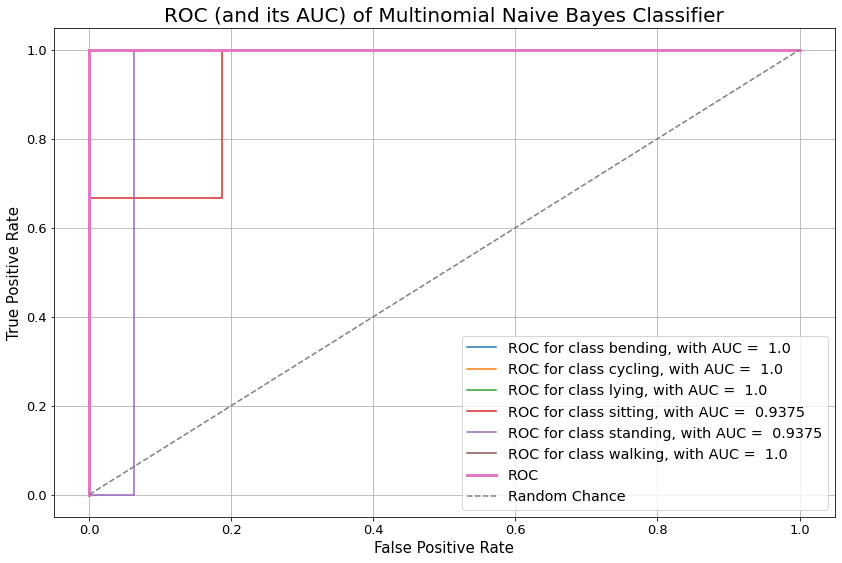

In [34]:
# roc and auc

prediction_prob = multinom_model.predict_proba(testX)

fig, ax = plt.subplots(figsize=(14, 9))

for i, label in enumerate(multinom_model.classes_):
    fpr, tpr, thresh = roc_curve(testY, prediction_prob[:, i], pos_label=label)
    auc_val = auc(fpr, tpr)
    ax.plot(fpr, tpr, label="ROC for class %s, with AUC =  %s" %(str(label), str(round(auc_val, 4))))


# plots the predicitve power (i.e. prob curve) of our classifier
ax.plot(fpr, tpr, label="ROC", linewidth=3)
# plots the predictive power we would expect with random guessing
ax.plot([0, 1], [0, 1], "--", label="Random Chance")
ax.legend(loc="lower right", fontsize="x-large")

plt.grid(True)
plt.tick_params(labelsize=13)
plt.xlabel("False Positive Rate", fontsize=15)
plt.ylabel("True Positive Rate", fontsize=15)
plt.title("ROC (and its AUC) of Multinomial Naive Bayes Classifier", fontsize=20)

plt.show()



>Overall, looking at the best test errors as well as the confussion matrix and ROC/AUC results, it appears that the Multinomial Naive Bayes classifier has a better performance compared to the Gaussian NB. The best accuracy score for the Multinomial NB Classifier was 0.9474. It's confusion matrix had one error.

>For the Gaussian, the best test accuracy rate was 0.8947. It's confusion matrix shows two errors. Visually by comparing the ROCs of the two models, it is similarly clear that the Multinomial model has better performance here (e.g. has a larger AUC).

-----------
## 1.f.iii
Multi-class Classification (The Realistic Case)

Which method is better for multi-class classification in this problem?

>Among the three models, in (f), the Gaussian Classifier appears to the worst. It has the lowest accuracy score, which is also visible with the ROC graph and confusion matrix mentioned below.

>In terms of the test accuracy score, the Multinomial NB Classifier still has the highest/best one at 0.9474 vs the Logistic Regression's 0.8947. However, if we look at the ROCs, the logit model's values are bigger; the total AUC values are larger than for the gaussian model -- although not by that much. So, depending on what performance metric we use (and the dataset), either could be considered the best multi-class classifier.

>But, just based on the error rate values, we can tentatively say the Gaussian NB Classifier had the better performance for our data (with this random_state). 

------------
## 2
ISLR 3.7.4

I collect a set of data (n = 100 observations) containing a single predictor and a quantitative response. I then fit a linear regression model to the data, as well as a separate cubic regression, i.e. Y = β0 +β1X +β2X2 +β3X3 +ε.

(a) Suppose that the true relationship between X and Y is linear, i.e. Y = β0 + β1X + ε. Consider the training residual sum of squares (RSS) for the linear regression, and also the training RSS for the cubic regression. Would we expect one to be lower than the other, would we expect them to be the same, or is there not enough information to tell? Justify your answer.
>We would expect the training RSS for the cubic regression to be lower than the RSS for linear regression. Generally, having more predictors (especially polynomial terms) leads to greater/closer fit with the training data. 

(b) Answer (a) using test rather than training RSS.
>Conversely from (a), the test RSS of a linear regression would be lower. Since we know that the true relationship of X and Y is linear, the linear model will likely have good generalization ability while cubic regression would overfit on the training data. Therefore, one would excpect the test RSS of the linear regression to be lower, and the test RSS of the cubic model to be higher.

(c) Suppose that the true relation ship between Xa nd Y is not linear, but we don’t know how far it is from linear. Consider the training RSS for the linear regression, and also the training RSS for the cubic regression. Would we expect one to be lower than the other, would we expect them to be the same, or is there not enough information to tell? Justify your answer.
>Polynomial regressions are more flexible than its linear counterpart. This means that it will fit the training data better/tighter and this results in a lower training RSS; this would be especially the case when the true relationship is non-linear. will have a better fit to non-linear data and so its training RSS will be lower. Therefore, the cubic regression train RSS would be lower.

(d) Answer (c) using test rather than training RSS.
>This would depend if the true relationship is still closer to a linear relationship or a cubic one. Since we don't know this, there isnt enough info to answer. If the relationship is close to linear, we have a scenario like (b), where a cubic model may overfit and result in higher test RSS. If the true relationship is closer to cubic, then the linear model would underfit and so test RSS of the cubic regression would be lower. This is the bias-variance trade-off.


------------
## 3
ISLR, 4.8.3

This problem relates to the QDA model, in which the observations within each class are drawn from a normal distribution with a class- specific mean vector and a class specific covariance matrix. We con- sider the simple case where p = 1; i.e. there is only one feature.

Suppose that we have K classes, and that if an observation belongs to the kth class then X comes from a one-dimensional normal dis- tribution, X ∼ N(μk,σk2). Recall that the density function for the one-dimensional normal distribution is given in (4.16). Prove that in this case, the Bayes classifier is not linear. Argue that it is in fact quadratic.

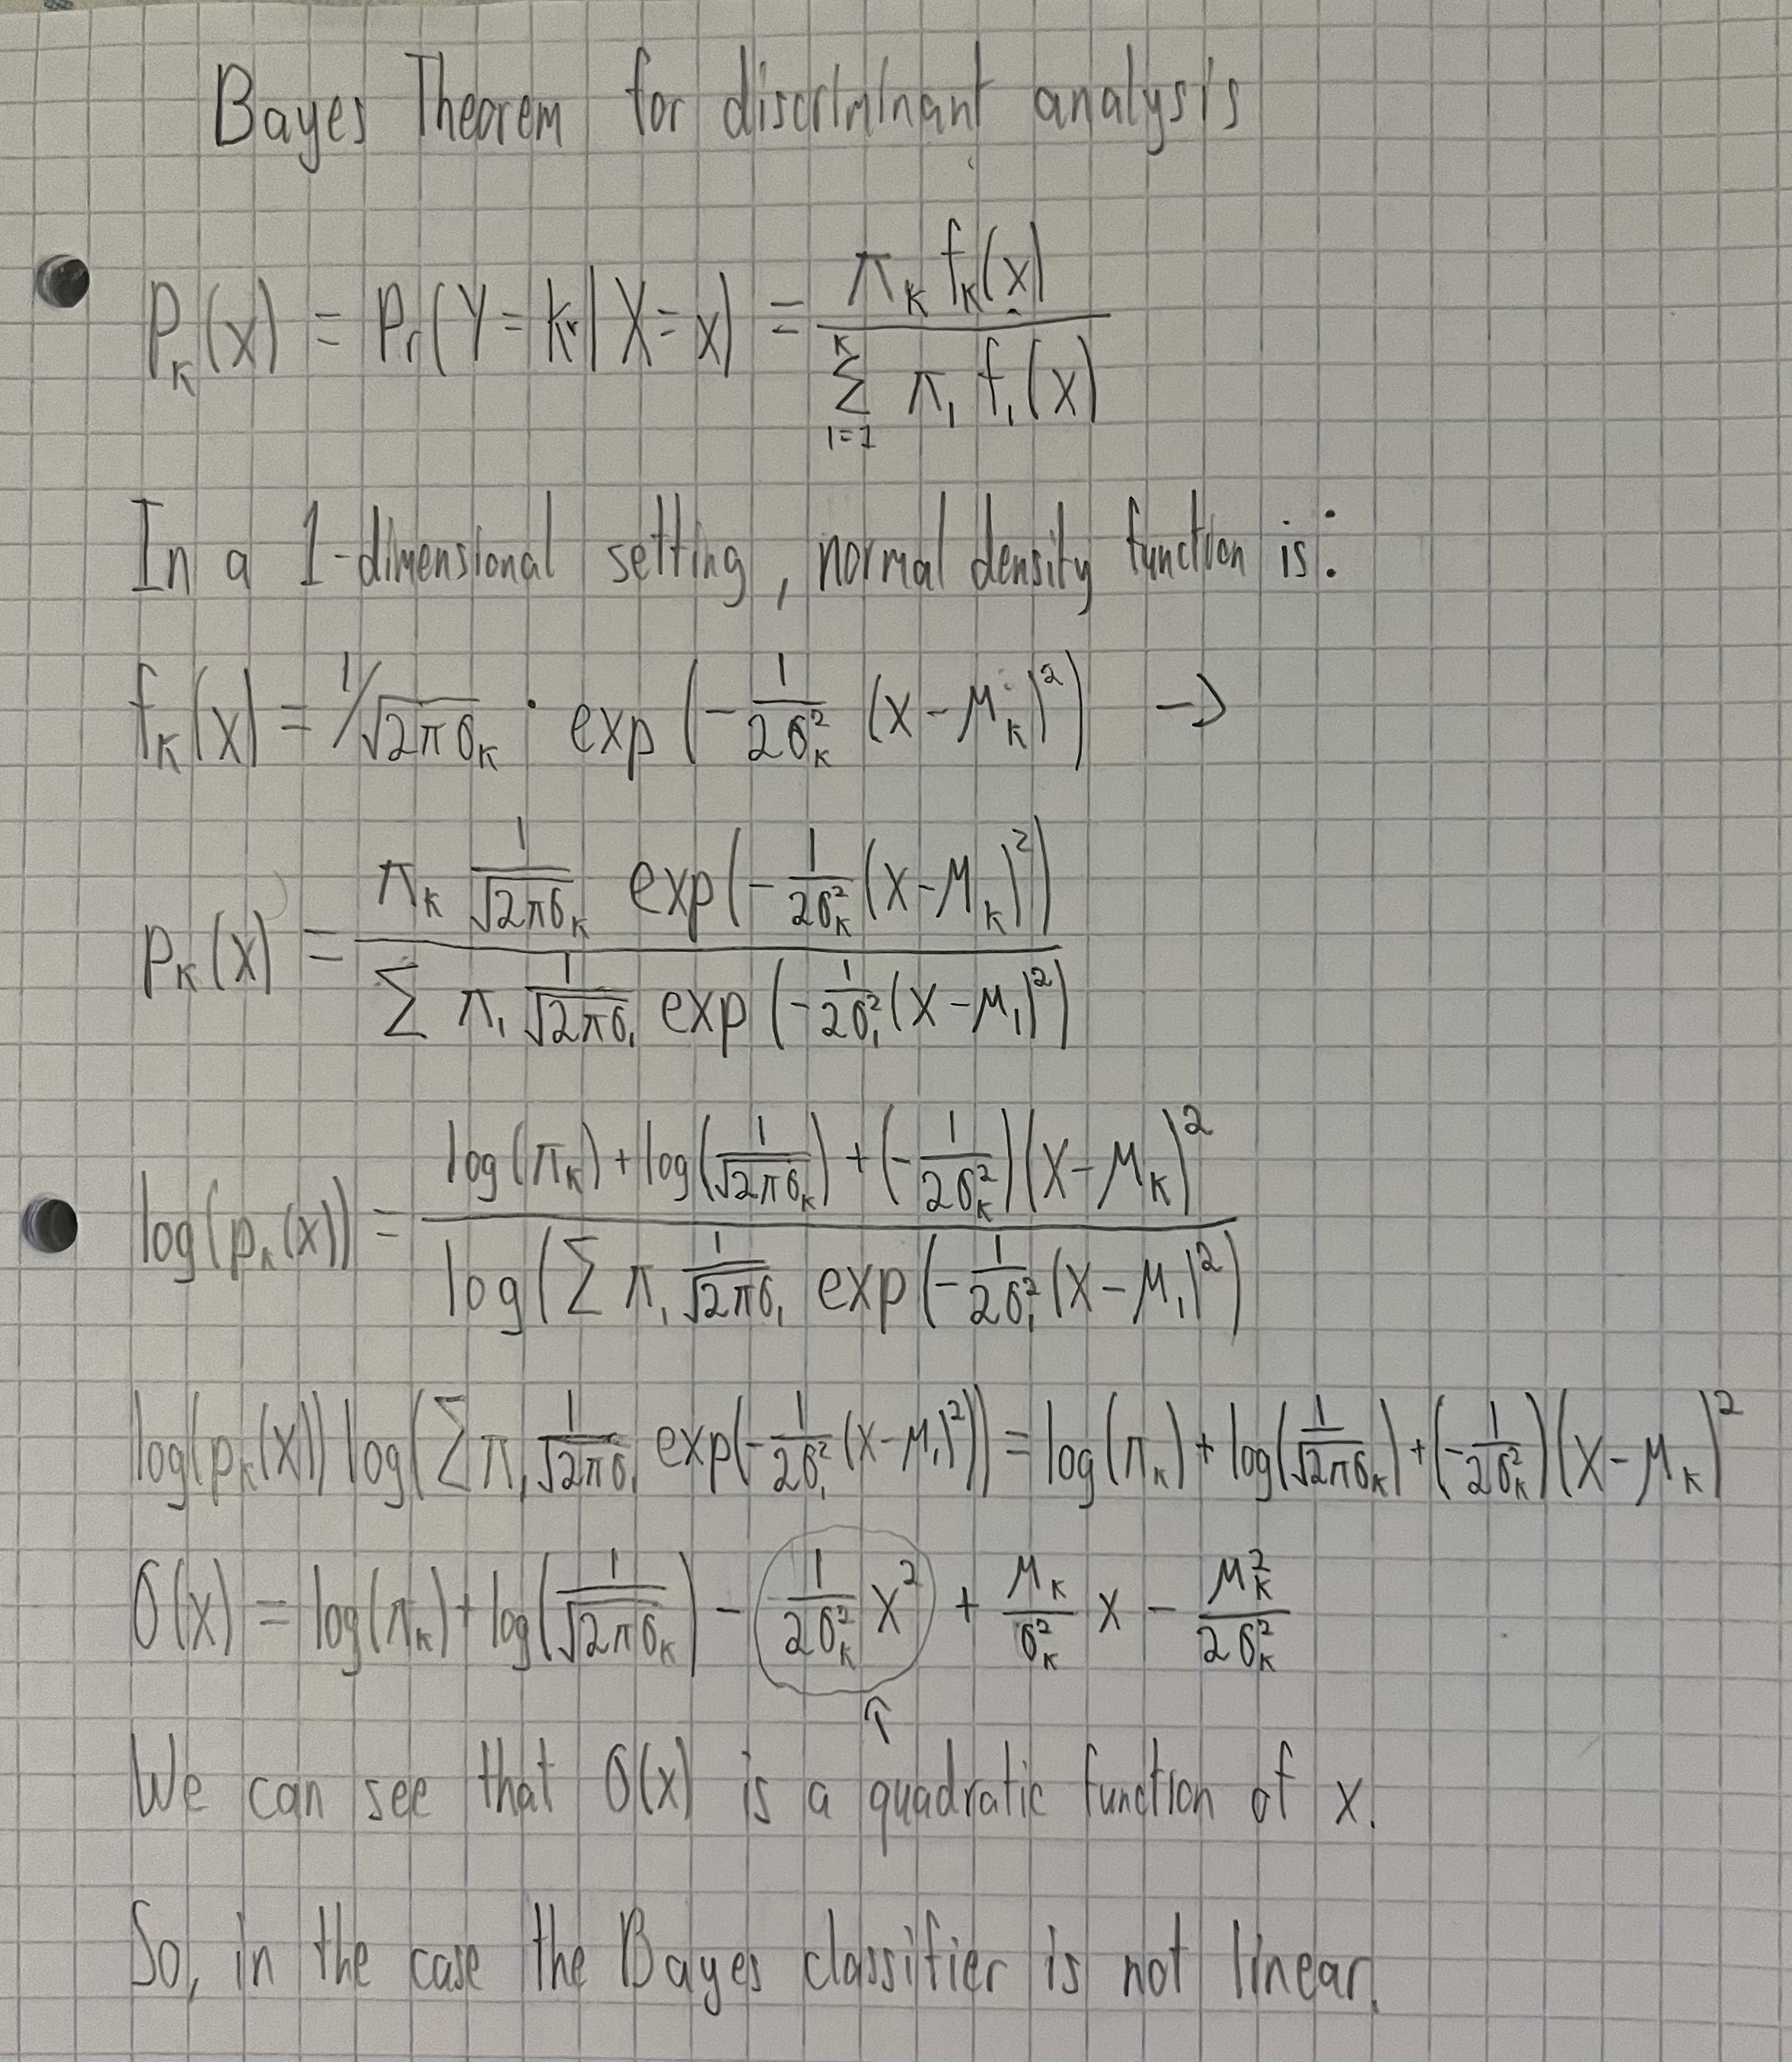

------------
## 4
ISLR 4.8.7


Suppose that we wish to predict whether a given stock will issue a dividend this year (“Yes” or “No”) based on X, last year’s percent profit. We examine a large number of companies and discover that the mean value of X for companies that issued a dividend was X ̄ = 10, while the mean for those that didn’t was X ̄ = 0. In addition, the variance of X for these two sets of companies was σˆ2 = 36. Finally, 80 % of companies issued dividends. Assuming that X follows a nor- mal distribution, predict the probability that a company will issue a dividend this year given that its percentage profit was X = 4 last year.

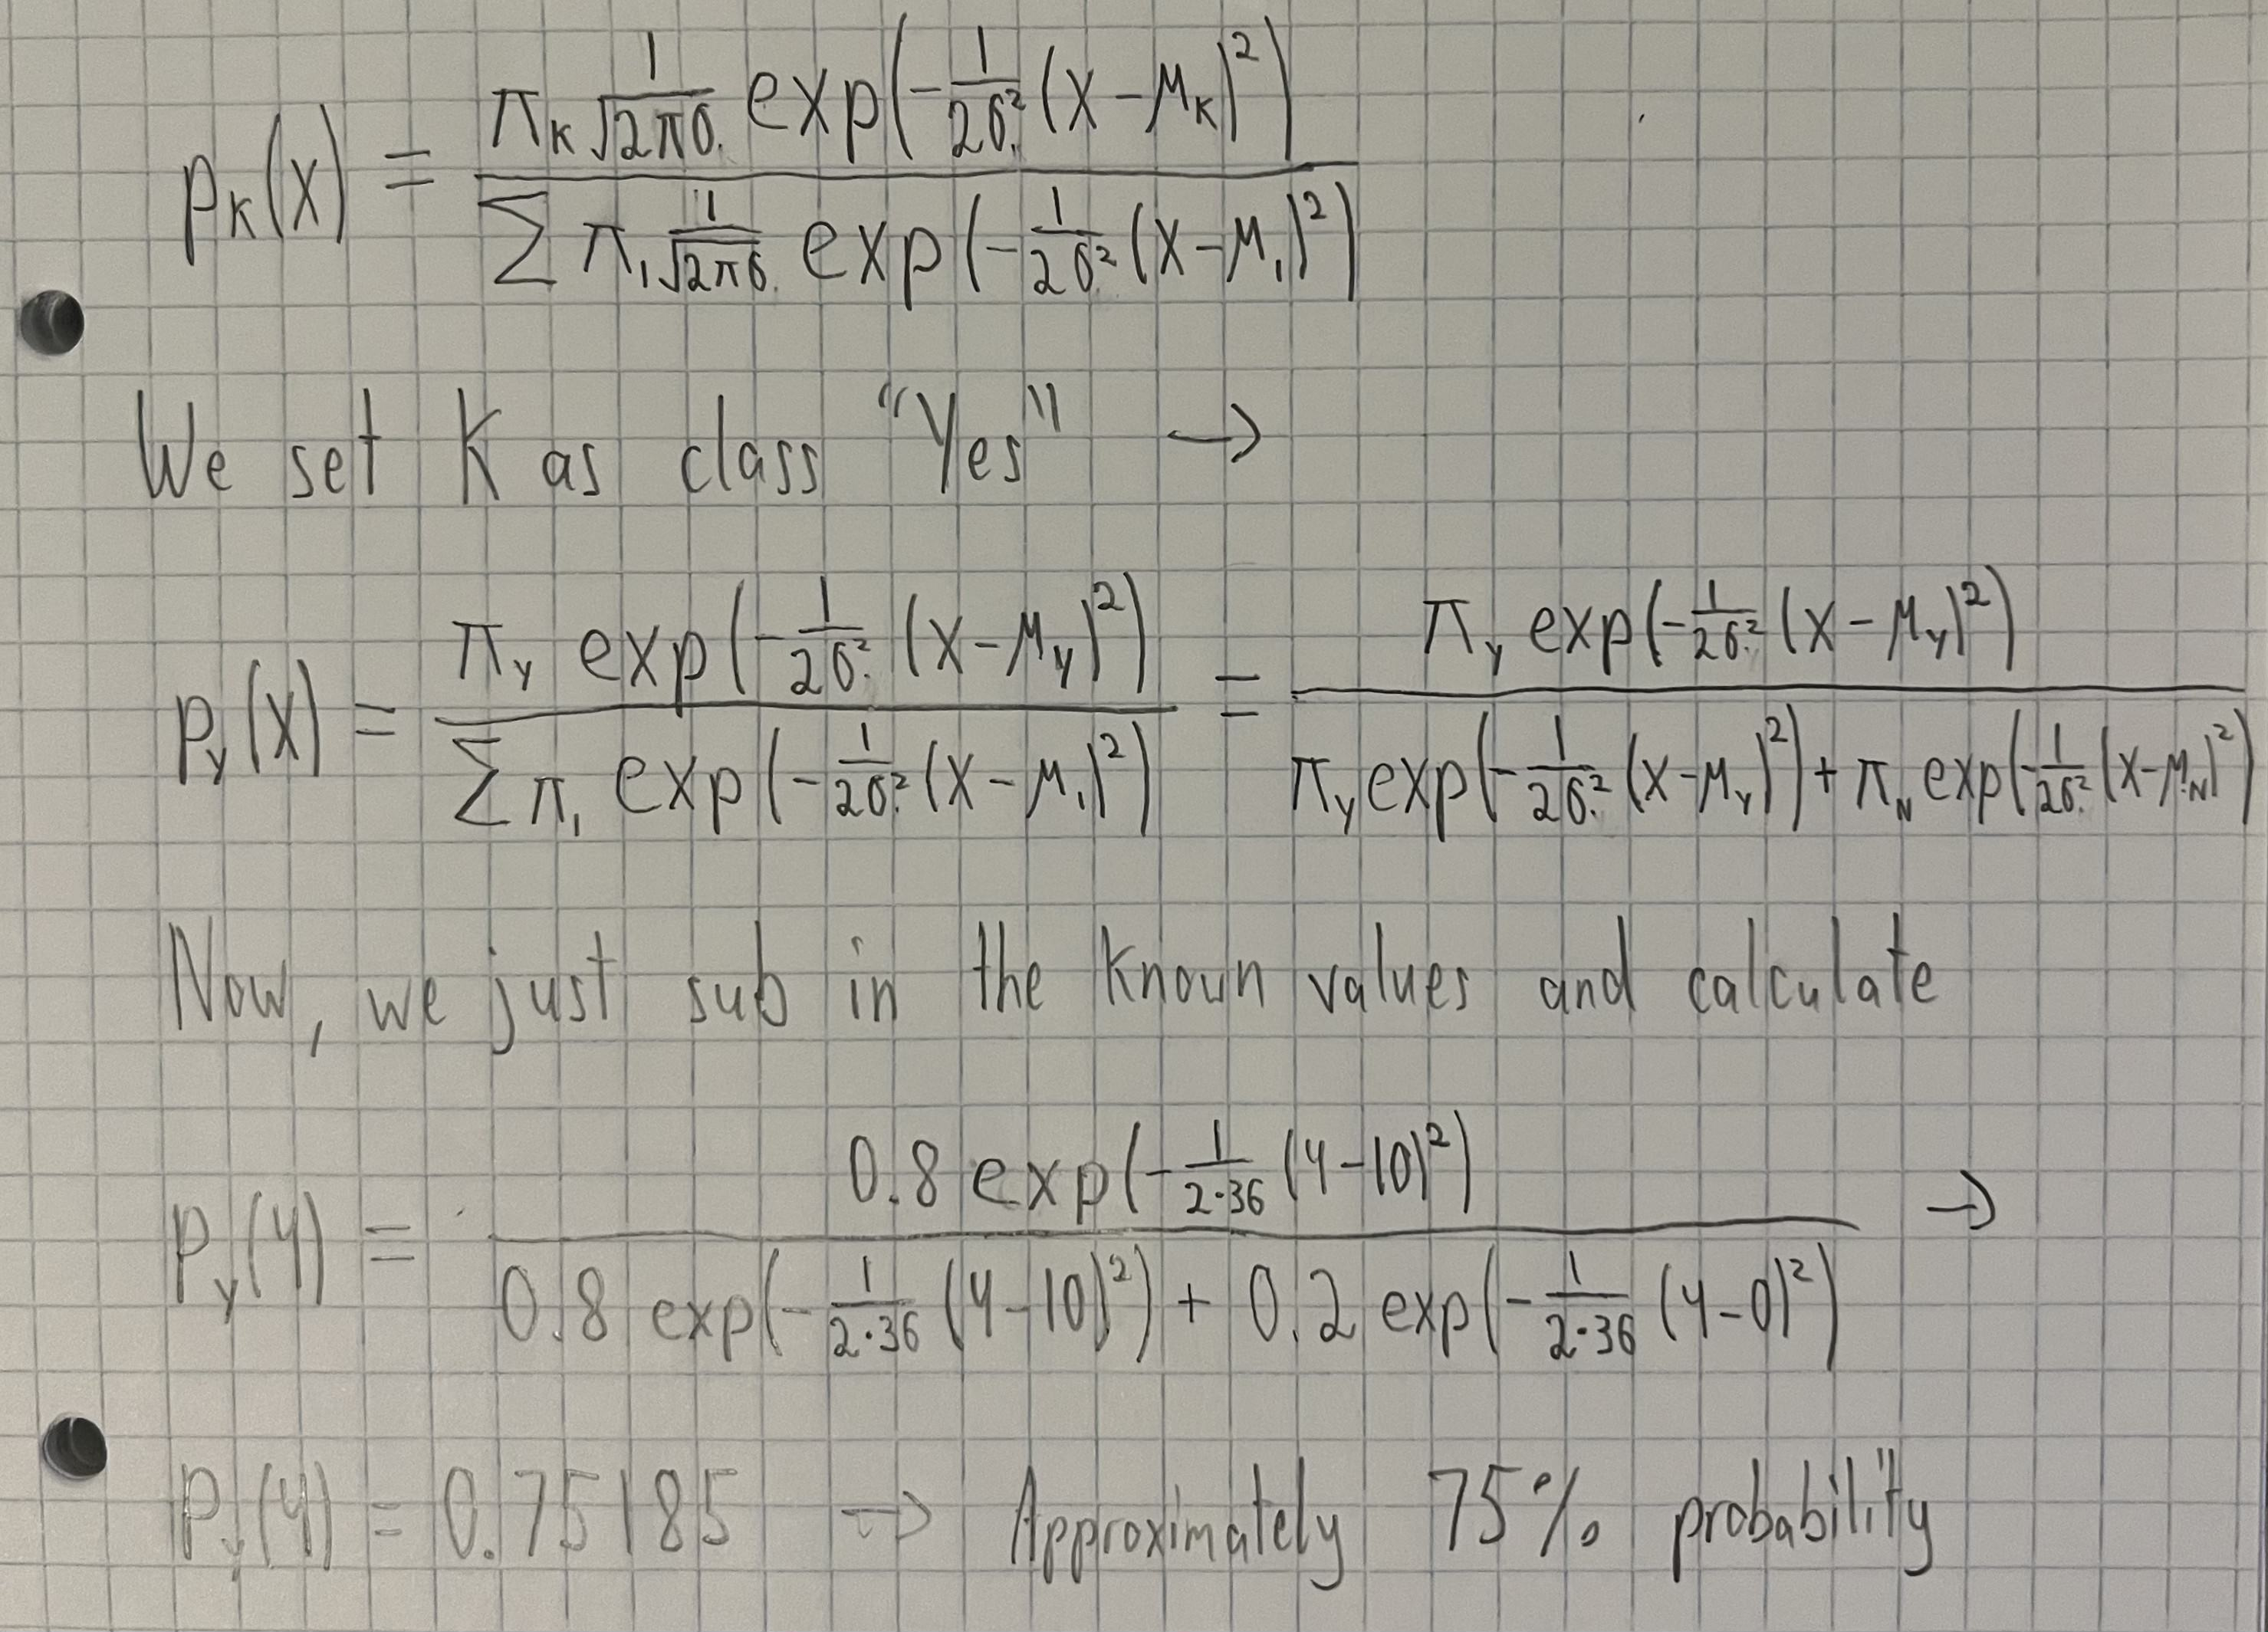

--------------------

In [35]:
# deleting the cleaned_files from your directory
# ie reseting the data folder to it's default format
# comment out, if you want to keep the cleaned_files
for name in clean_filesL:
    os.remove(name)